In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import time
from multiprocess import Pool
import os
from matplotlib import ticker

from breads.utils import broaden, filter_spec_with_spline

import sys
def rprint(st):
    sys.stdout.write('\r'+str(st))
    sys.stdout.flush()

https://zenodo.org/records/12735103
Evolution tables include each of the three metallicities (0.0, +0.5, -0.5) and come in three versions.
    "nc" denotes cloud-free models for the full evolution.
    "hybrid" includes clouds (fsed=2) above 1300 K and cloud-free below 1300 K (using the Sonora Bobcat models for T<900 K).
    "hybrid-grav" includes clouds (fsed=2) that clear between 1000 and 1300 K, with clouds in lower gravity models persisting to colder tempearatures, again using the Sonora Bobcat models for T<900 K.

loading: self.df = pd.read_pickle(/user/amadurowicz/51 Eri/pkl/hybrid-grav_f2_m+0.5_mass.pkl)
loading: /user/amadurowicz/51 Eri/interpDict/hybrid-grav_f2_m+0.5_mass.npy


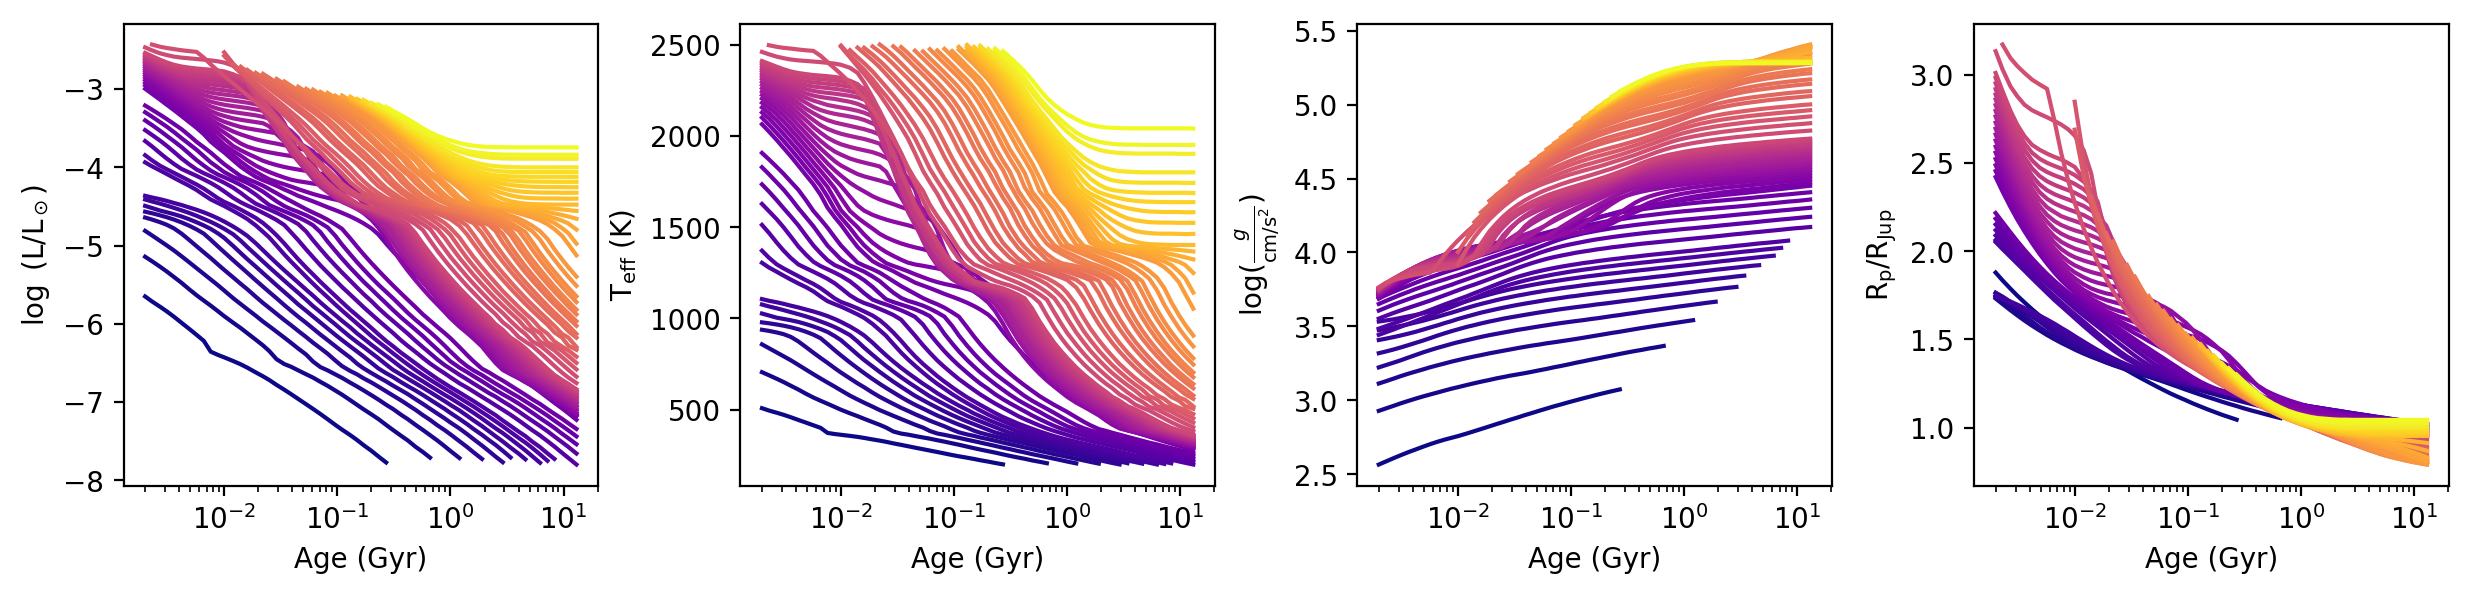

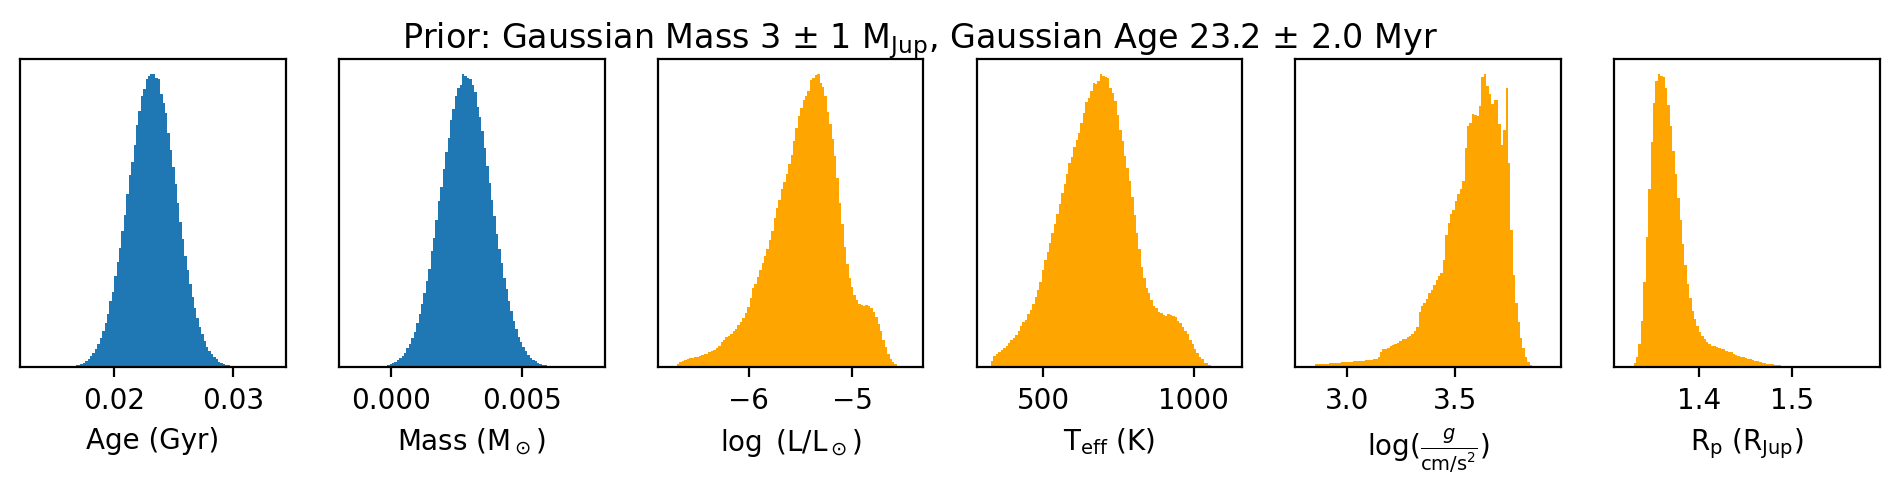

Age (Gyr) = 0.02 +/- 0.0
Mass/Mjup = 3.0 +/- 1.0
log L/Lsun = -5.45 +/- 0.35
Teff (K) = 680.08 +/- 127.81
log g = 3.57 +/- 0.15
R (Rjup) = 1.37 +/- 0.02


In [3]:
import sys
sys.path.insert(1, '/home/amadurowicz/diamondback/')

from diamondback_interpolator import DiamondbackEvolution

DBE = DiamondbackEvolution(clouds='hybrid-grav',mh=0.5)
DBE.line_plot()

Mjup = 1.898e27 #kg
Msun = 1.988e30 #kg
N = int(1e6)

mm, ms = 3, 1
agem, ages = 23.2, 2.
name = r'Prior: Gaussian Mass {} $\pm$ {}'.format(mm,ms)+' M$_\mathrm{Jup}$'+', Gaussian Age {} $\pm$ {} Myr'.format(agem,ages)
#mass_prior = np.random.uniform(low=1*Mjup/Msun, high=9*Mjup/Msun, size=N)
mass_prior = np.random.normal(loc=mm*Mjup/Msun, scale=ms*Mjup/Msun, size=N)
age_prior = np.random.normal(loc=agem/1000., scale=ages/1000., size=N)

DBE.calc_prior(age_prior,mass_prior,name)
DBE.prior_plot(name)
DBE.prior_print_summary(name)

v = DBE.eval_prior_function(name,3,[600.,700.,800.,900.,1000.])

In [5]:
#fname='/data/Dropbox (GPI)/GPIMAIN/Papers/2017/51_Eri_b/data/Data_Fig4.ascii')
class observed_spectra():
    def __init__(self,fname='Data_Fig4.ascii'):
        #  51  Eridani b  Spectral  Energy  Distribution
        #  Col  1  -  Wavelength  (micron)
        #  Col  2  -  Flux  (W.m^2.micron-1)
        #  Col  3  -  Flux  Error  (W.m^2.micron-1)
        self.fname = fname
    
    def load_data(self):
        self.data = np.loadtxt(self.fname)
        self.wavelength = self.data[:,0]
        self.flux = self.data[:,1]
        self.error = self.data[:,2]
        
        self.wave = np.array(self.wavelength)
        self.wavedict = self.bandsplit(self.wave) 
        self.fluxdict = self.bandsplit(self.flux)
        self.errordict = self.bandsplit(self.error)
        self.errordict['M'] /= 2
        
    def bandsplit(self,a):
        Ja = a[:37]
        Ha = a[37:74]
        K1a = a[74:111]
        K2a = a[111:-2]
        La = a[-2]
        Ma = a[-1]
        adict = {'J':Ja,'H':Ha,'K1':K1a,'K2':K2a,'L':La,'M':Ma}
        return adict
    
    #delta_lambda = lambda_i - lambda_j / lambda_c
    def Psi_ij(self,rho,bandps,band_wave,lambda_c,i,j):
        rho = rho/(lambda_c*1e-6/8*206265) #units of lambda/Dtel
        delta_lambda = (band_wave[i] - band_wave[j]) / lambda_c
        Psi_ij = bandps[0]*np.exp(-1/2*(rho/bandps[3]*delta_lambda)**2) + \
                 bandps[1]*np.exp(-1/2*(1/bandps[4]*delta_lambda)**2)
        if i == j:
            Psi_ij += bandps[2]
        return rho*delta_lambda, Psi_ij
    
    def create_covariance_model(self):
        #noise covariance model
        #Rajan https://arxiv.org/pdf/1705.03887.pdf
        #Greco & Brandt https://iopscience.iop.org/article/10.3847/1538-4357/833/2/134/pdf

        #Band     Aρ    Aλ    Aδ    σρ    σλ
        #Jps =  [0.43, 0.43, 0.14, 0.44, 0.05]
        #Hps =  [0.70, 0.27, 0.03, 0.45, 0.01]
        #K1ps = [0.51, 0.41, 0.07, 0.68, 0.004]
        #K2ps = [0.30, 0.62, 0.08, 0.43, 0.004]
        Jps =  [0.43, 0.43, 0.14, 0.44, 0.05]
        Hps =  [0.70, 0.27, 0.03, 0.45, 0.01]
        K1ps = [0.51, 0.41, 0.07, 0.68, 0.004]
        K2ps = [0.30, 0.62, 0.08, 0.43, 0.004]


        self.covdict = {'J':Jps,'H':Hps,'K1':K1ps,'K2':K2ps}

        #51 Eri b position
        rho = .454 #arcseconds

        #bandpass ranges -> centers
        #https://arxiv.org/pdf/1407.2314.pdf
        lambda_cs = {'J':(1.12+1.35)/2,'H':(1.50+1.80)/2,'K1':(1.9+2.19)/2,'K2':(2.13+2.4)/2}
        #print(lambda_cs)

        self.psidict = {}
        self.rdldict = {}
        for band in ['J','H','K1','K2']:
            band_wave = self.wavedict[band]
            L = len(band_wave)
            psis = np.zeros((L,L))
            rdls = np.zeros((L,L))

            for ii,i in enumerate(range(L)):
                for jj,j in enumerate(range(L)):
                    rdl, psi = self.Psi_ij(rho,self.covdict[band],band_wave,lambda_cs[band],i,j) 
                    rdls[jj,ii] = rdl
                    psis[jj,ii] = psi

            self.psidict[band] = psis
            self.rdldict[band] = rdls

    def create_Cinv(self):
        Cinv_dict = {}
        for band in ['J','H','K1','K2']:
            psi = self.psidict[band]
            flux = self.fluxdict[band]
            err = self.errordict[band]
        
            I,J=psi.shape
            covariance = np.zeros(psi.shape)
            for i in range(I):
                for j in range(J):
                    if i == j:
                        covariance[j,i] = err[i]**2
                    else:
                        covariance[j,i] = psi[j,i]*np.sqrt(err[i]**2*err[j]**2)
                        
            Cinv = np.linalg.inv(covariance)
            Cinv_dict[band] = Cinv
            
        self.Cinv_dict = Cinv_dict
            
    def covariance_plot(self):
        plt.figure(figsize=(4,3),dpi=150)
        rdl,psi=list(zip(*sorted(zip(self.rdldict['H'].ravel(), self.psidict['H'].ravel()))))
        plt.plot(rdl,psi,'k-')
        plt.xlim([-3,3])
        plt.ylim([0,1.1])

        plt.xlabel(r'$\rho \frac{\lambda_i - \lambda_j}{\lambda_c}$')
        plt.ylabel(r'$\Psi_{ij}$')
        plt.show()

        fig,ax=plt.subplots(2,2,figsize=(5,5),dpi=150)

        bandsquare = np.array([['J','H'],['K1','K2']])

        for i in range(2):
            for j in range(2):
                band = bandsquare[j,i]
                psi = self.psidict[band]
                ax[j,i].imshow(psi,origin='lower',vmin=0,vmax=1)
                ax[j,i].set_title('{}'.format(band))
                ax[j,i].axis('off')

        plt.subplots_adjust(wspace=0.2,hspace=0.2)
        plt.show()
        
    def run(self):
        self.load_data()
        self.create_covariance_model()
        self.create_Cinv()
        self.covariance_plot()

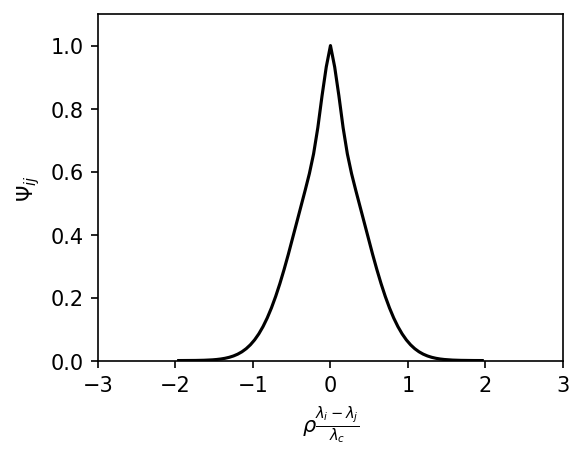

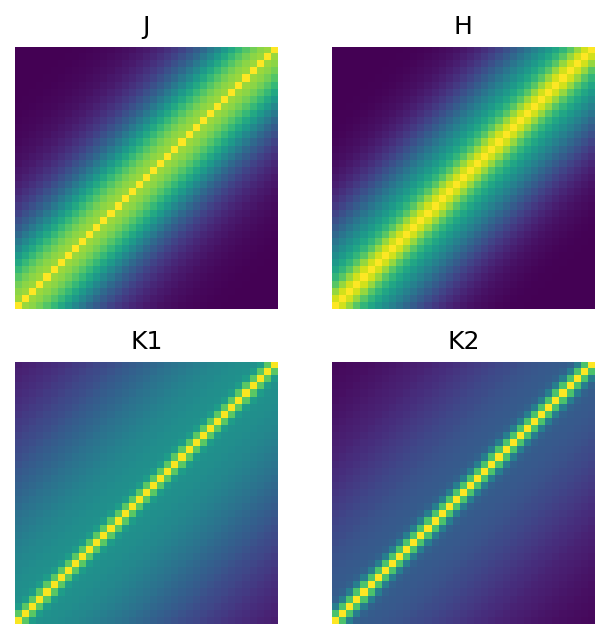

In [6]:
eri51b = observed_spectra()
eri51b.run()

In [7]:
F410M = 15.23
F430M = 15.46
F460M = 15.35
e = 0.25
F410Me = F410M+e
F430Me = F430M+e
F460Me = F460M+e

vega410 = 209.63*1e-6
vega430 = 190.67*1e-6
vega460 = 163.78*1e-6

#https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints
#magVega = -2.5 * log10(flux[MJy/sr] * PIXAR_SR[sr/pix] / fluxVega[MJy]).
# 1 Jy = 1e-26 W/m^2/Hz
#[Y W/m^2/um] = 2.99792458E+14 * [X1 W/m^2/Hz] / [X2 um]^2

def mag2flux(mag,vega):
    return 10**(mag/-2.5)*vega
def MJy_Wm2um(flux,w):     
    return 2.99792458e14*flux*1e6*1e-26/w**2 #MJy -> Jy -> W/m^2/Hz -> W/m^2/micron
def convert(mag,vega,w):
    return MJy_Wm2um(mag2flux(mag,vega),w)

F410M = convert(F410M,vega410,4.083)
F430M = convert(F430M,vega430,4.281)
F460M = convert(F460M,vega460,4.63)
F410Me = abs(F410M - convert(F410Me,vega410,4.083))
F430Me = abs(F430M - convert(F430Me,vega430,4.281))
F460Me = abs(F460M - convert(F460Me,vega460,4.63))

eri51b.wavedict['F410M'] = 4.083
eri51b.fluxdict['F410M'] = F410M
eri51b.errordict['F410M'] = F410Me

eri51b.wavedict['F430M'] = 4.281
eri51b.fluxdict['F430M'] = 0         #F430M
eri51b.errordict['F430M'] = F430M/3. #F430Me

eri51b.wavedict['F460M'] = 4.63
eri51b.fluxdict['F460M'] = 0         #F460M
eri51b.errordict['F460M'] = F460M/3. #F460Me

In [8]:
cubelist = glob.glob('saved/final/cube_*p.fits')

FSkeys = []
for cfile in cubelist:
    key = cfile.split('.')[-2].split('_')[-1]
    print(key)
    FSkeys.append(key)
    hdulist = fits.open(cfile)
    
    flux = hdulist[0].data[:,30,0]
    err = hdulist[1].data[:,30,0]
    wave = hdulist[4].data

    nanbool = np.logical_not(np.isnan(flux))
    flux = flux[nanbool]
    err = err[nanbool]
    wave = wave[nanbool]
    
    #[Y W/m^2/um] = 2.99792458E+14 * [X1 W/m^2/Hz] / [X2 um]^2
    #1 J y = 1e-26 W/m^2/Hz
    flux = flux*1e6*1e-26*2.99792458e14/(wave)**2 #MJY -> Jy -> W/m^2/Hz -> W/m^2/um
    err = err*1e6*1e-26*2.99792458e14/(wave)**2
    
    eri51b.wavedict[key] = wave
    eri51b.fluxdict[key] = flux
    eri51b.errordict[key] = err

a1n1p
a1n2p
a2n1p
a2n2p


In [9]:
#new resolution dictionary
#https://w.astro.berkeley.edu/~kalas/gpi/documents/GPI-overview-lo-res.pdf

eri51b.Rdict = {}
eri51b.Rdict['J'] = 37
eri51b.Rdict['H'] = 46.5
eri51b.Rdict['K1'] = 66
eri51b.Rdict['K2'] = 79
eri51b.Rdict['L'] = 10
eri51b.Rdict['M'] = 10
eri51b.Rdict['F410M'] = 10 
eri51b.Rdict['F430M'] = 10
eri51b.Rdict['F460M'] = 10
for key in FSkeys:
    eri51b.Rdict[key] = 2700

In [10]:
#eri51b.wavedict,eri51b.errordict,eri51b.fluxdict,eri51b.Rdict

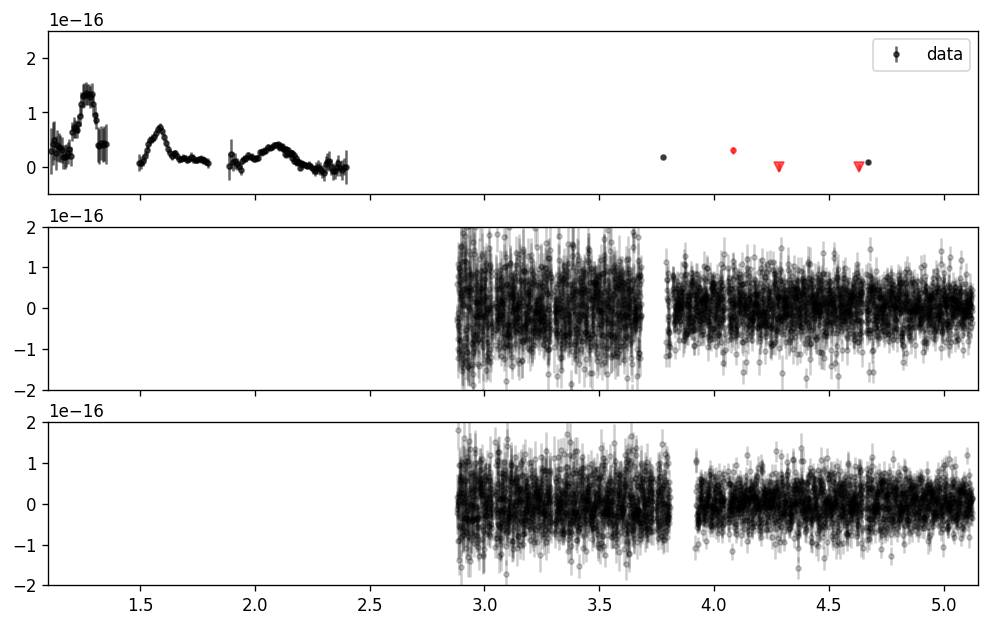

In [11]:
fig,ax = plt.subplots(3,1,figsize=(10,6),dpi=120,sharex=True,sharey=False)

errbars = []
for band in eri51b.wavedict.keys():
    wave = eri51b.wavedict[band]
    y = eri51b.fluxdict[band]
    e = eri51b.errordict[band]
    if band in ['F430M', 'F460M']:
        marker = 'v'
    else:
        marker = '.'
    if band in ['F410M','F430M', 'F460M']:
        color = 'r'
    else:
        color = 'k'
    if 'p' not in band:
        errbar = ax[0].errorbar(wave,y,e,linestyle='none',marker=marker,color=color,alpha=0.6)
    elif 'a1' in band:
        errbar = ax[1].errorbar(wave,y,e,linestyle='none',marker=marker,color=color,alpha=0.2)
    elif 'a2' in band:
        errbar = ax[2].errorbar(wave,y,e,linestyle='none',marker=marker,color=color,alpha=0.2)
    errbars.append(errbar)
        
ax[0].set_xlim([1.1,5.15])
ax[0].set_xscale('linear')
ax[0].set_xticks([1.5,2,2.5,3,3.5,4,4.5,5])
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax[0].set_ylim([-0.5e-16,2.5e-16])
ax[0].legend([errbars[0]],['data'])

#nrsw = eri51b.wavedict['a1n2p']
#ax[1].set_xlim([np.min(nrsw),np.max(nrsw)])
ax[1].set_ylim([-2e-16,2e-16])
ax[2].set_ylim([-2e-16,2e-16])

plt.show()

In [12]:
from breads.atm_utils import broadRGI

species v0.9.0

Working folder: /user/amadurowicz/51 Eri

Configuration file: /user/amadurowicz/51 Eri/species_config.ini
Database file: /user/amadurowicz/species_database.hdf5
Data folder: /user/amadurowicz/data

Configuration settings:
   - Database: /user/amadurowicz/species_database.hdf5
   - Data folder: /user/amadurowicz/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [13]:
import species
from species.data.database import Database
species.SpeciesInit()
database = Database()

species v0.9.0

Working folder: /user/amadurowicz/51 Eri

Configuration file: /user/amadurowicz/51 Eri/species_config.ini
Database file: /user/amadurowicz/species_database.hdf5
Data folder: /user/amadurowicz/data

Configuration settings:
   - Database: /user/amadurowicz/species_database.hdf5
   - Data folder: /user/amadurowicz/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [14]:
c100 = broadRGI('elfowl-clouds',R=100,preload=True)
c2700 = broadRGI('elfowl-clouds',R=2700,preload=True)

f100 = broadRGI('elfowl-cloudfree',R=100,preload=True)
f2700 = broadRGI('elfowl-cloudfree',R=2700,preload=True)

already exists, no preperations.
preloading...
done.
already exists, no preperations.
preloading...
done.
already exists, no preperations.
preloading...
done.
already exists, no preperations.
preloading...
done.


In [328]:
param_list = list(c100.points.values())
shape = tuple([len(l) for l in param_list])
npoints = np.prod(shape)
shape,npoints

((12, 10, 6, 4, 5), 14400)

In [329]:
param_outer_product = np.array(np.meshgrid(*[list(l) for l in param_list])).T.reshape(npoints,len(shape))
np.set_printoptions(precision=3,suppress=True)
param_outer_product[-10::]

array([[1200.   ,    3.25 ,    1.   ,    1.145,    9.   ],
       [1200.   ,    3.5  ,    1.   ,    1.145,    9.   ],
       [1200.   ,    3.75 ,    1.   ,    1.145,    9.   ],
       [1200.   ,    4.   ,    1.   ,    1.145,    9.   ],
       [1200.   ,    4.25 ,    1.   ,    1.145,    9.   ],
       [1200.   ,    4.5  ,    1.   ,    1.145,    9.   ],
       [1200.   ,    4.75 ,    1.   ,    1.145,    9.   ],
       [1200.   ,    5.   ,    1.   ,    1.145,    9.   ],
       [1200.   ,    5.25 ,    1.   ,    1.145,    9.   ],
       [1200.   ,    5.5  ,    1.   ,    1.145,    9.   ]])

In [330]:
fs_nodes = np.load('fs_uniform_nodes_N136.npy',allow_pickle=True).item()
fs_nodes,FSkeys

({'nrs1': array([2.86 , 2.877, 2.894, 2.91 , 2.927, 2.944, 2.961, 2.978, 2.995,
         3.011, 3.028, 3.045, 3.062, 3.079, 3.095, 3.112, 3.129, 3.146,
         3.163, 3.179, 3.196, 3.213, 3.23 , 3.247, 3.264, 3.28 , 3.297,
         3.314, 3.331, 3.348, 3.364, 3.381, 3.398, 3.415, 3.432, 3.449,
         3.465, 3.482, 3.499, 3.516, 3.533, 3.549, 3.566, 3.583, 3.6  ,
         3.617, 3.633, 3.65 , 3.667, 3.684, 3.701, 3.718, 3.734, 3.751,
         3.768, 3.785, 3.802, 3.818]),
  'nrs2': array([3.785, 3.802, 3.818, 3.835, 3.852, 3.869, 3.886, 3.903, 3.919,
         3.936, 3.953, 3.97 , 3.987, 4.003, 4.02 , 4.037, 4.054, 4.071,
         4.087, 4.104, 4.121, 4.138, 4.155, 4.172, 4.188, 4.205, 4.222,
         4.239, 4.256, 4.272, 4.289, 4.306, 4.323, 4.34 , 4.357, 4.373,
         4.39 , 4.407, 4.424, 4.441, 4.457, 4.474, 4.491, 4.508, 4.525,
         4.541, 4.558, 4.575, 4.592, 4.609, 4.626, 4.642, 4.659, 4.676,
         4.693, 4.71 , 4.726, 4.743, 4.76 , 4.777, 4.794, 4.811, 4.827,
         

In [331]:
d_star = 29.4
pc = 3.086e16 #m
Rjup = 7.1492e7 #m or 6.995e7

def calc_chi2(cdict, fdict, obs_spectra, Rplanet, ehat, fhole, verbose=False):
    d2f = (Rplanet*Rjup/d_star/pc)**2
    #chi2 = 0
    chi2d = {}
    for band in ['J','H','K1','K2']:
        #covariant chi2
        print(band) if verbose else None
        
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        Cinv = obs_spectra.Cinv_dict[band]
        v = d2f*y - flux
        chi2band = np.linalg.multi_dot([v.T,Cinv,v])
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band

    for band in ['L','M','F410M','F430M','F460M']:
        #photometric chi2
        print(band) if verbose else None
        
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        err = obs_spectra.errordict[band]
        v = d2f*y - flux
        chi2band = (v/err)**2
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band

    for band in FSkeys:
        #ordinary chi2
        print(band) if verbose else None
        
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        err = obs_spectra.errordict[band]

        #including hpf on spectra
        wave = obs_spectra.wavedict[band]
        node_key = 'nrs1' if 'n1' in band else 'nrs2'
        x_nodes = fs_nodes[node_key]#np.linspace(np.nanmin(wave), np.nanmax(wave), 60) #####
        hpf_y, _ = filter_spec_with_spline(wave,y,x_nodes=x_nodes)
        
        v = d2f*hpf_y - flux
        chi2band = np.sum((v/(ehat*err))**2)
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band
        
    return chi2d

In [332]:
from species.phot.syn_phot import SyntheticPhotometry
filter_dictionary = {}
filter_dictionary['L'] = 'Keck/NIRC2.Lp'
filter_dictionary['M'] = 'Keck/NIRC2.Ms'
filter_dictionary['F410M'] = 'JWST/NIRCam.F410M'
filter_dictionary['F430M'] = 'JWST/NIRCam.F430M'
filter_dictionary['F460M'] = 'JWST/NIRCam.F460M'



In [333]:
radii = np.logspace(0,0.25,21)
ehats = np.linspace(1.5,2.,11)
fholes = np.linspace(0,1,21)
radii,ehats,fholes

(array([1.   , 1.029, 1.059, 1.09 , 1.122, 1.155, 1.189, 1.223, 1.259,
        1.296, 1.334, 1.372, 1.413, 1.454, 1.496, 1.54 , 1.585, 1.631,
        1.679, 1.728, 1.778]),
 array([1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

In [334]:
def chi2(index):
    rprint(index)
    teff, logg, mh, co, logkzz = param_outer_product[index]
    
    cloudy100 = c100([teff, logg, mh, co, logkzz])[0]
    cloudy2700 = c2700([teff, logg, mh, co, logkzz])[0]
    cloudfree100 = f100([teff, logg, mh, co, logkzz])[0]
    cloudfree2700 = f2700([teff, logg, mh, co, logkzz])[0]

    cdict = {}
    fdict = {}
    
    for band in list(eri51b.wavedict.keys())[:4]:
        #rprint(band)
        wave = eri51b.wavedict[band]
        R = eri51b.Rdict[band]

        #trim f and w to range based on wave and R
        w = c100.wavelength
        wmin, wmax = np.min(wave),np.max(wave)
        delta_lambda_min = wmin/R
        delta_lambda_max = wmax/R
        lw, rw = wmin - delta_lambda_min*2, wmax + delta_lambda_max*2    
        trimbool = np.logical_and((w>lw),(w<rw))
        trimw = w[trimbool]
        
        trimc = cloudy100[trimbool]
        broad_c = broaden(trimw,trimc,R=R)
        c = np.interp(wave,trimw,broad_c)
        cdict[band] = c

        trimf = cloudfree100[trimbool]
        broad_f = broaden(trimw,trimf,R=R)
        f = np.interp(wave,trimw,broad_f)
        fdict[band] = f

    for band in list(eri51b.wavedict.keys())[4:-4]:
        #rprint(band)
        wave = eri51b.wavedict[band]
        R = eri51b.Rdict[band]
        filter_name = filter_dictionary[band]
        synph = SyntheticPhotometry(filter_name)
        
        c_bandflux, _ = synph.spectrum_to_flux(c100.wavelength,cloudy100)
        cdict[band] = c_bandflux

        f_bandflux, _ = synph.spectrum_to_flux(f100.wavelength,cloudfree100)
        fdict[band] = f_bandflux
    
    for band in list(eri51b.wavedict.keys())[-4:]:
        #rprint(band)
        wave = eri51b.wavedict[band]

        c = np.interp(wave,c2700.wavelength,cloudy2700)
        cdict[band] = c

        f = np.interp(wave,f2700.wavelength,cloudfree2700)
        fdict[band] = f
    
    chi2es = {}
    for r,Rplanet in enumerate(radii):
        for e,ehat in enumerate(ehats):
            for fh,fhole in enumerate(fholes):
                #rprint('{},{}'.format(r,e))
                chi2e = calc_chi2(cdict, fdict, eri51b, Rplanet, ehat, fhole, verbose=False)
                chi2es[(r,e,fh)] = chi2e
            
    np.save('/user/amadurowicz/51 Eri/chi2s/custom_N136_v3/{}.npy'.format(str(index).zfill(5)),chi2es)


In [21]:
t0 = time.time()
chi2(0)
t1 = time.time()
t1-t0

0

382.3793156147003

In [22]:
(t1-t0)*npoints/64/3600

23.89870722591877

In [ ]:
from multiprocess import Pool

with Pool(64) as pool:
    pool.map(chi2,range(npoints))

12281

In [22]:
import glob
outs = sorted(glob.glob('/user/amadurowicz/51 Eri/chi2s/custom_N136_v3/*.npy'))
len(outs)

#np.load(outs[0],allow_pickle=True).item().keys()

len(outs)

14400

In [335]:
index_list = [list(range(i)) for i in shape]
indices = np.array(np.meshgrid(*[list(l) for l in index_list])).T.reshape(npoints,len(shape))

test_bools = []
for testi in range(npoints):
    a,b,c,d,e = indices[testi]
    test_bool = np.all(param_outer_product[testi]==[param_list[0][a],param_list[1][b],param_list[2][c],param_list[3][d],param_list[4][e]])
    test_bools.append(test_bool)
np.all(test_bools)

True

In [336]:
new_shape = tuple(list(shape) + [len(radii),len(ehats),len(fholes)])
chi2_GPI_hc1 = np.zeros(new_shape)
chi2_phot_hc1 = np.zeros(new_shape)
chi2_nirspec_hc1 = np.zeros(new_shape)

like_rescale_hypercube1 = np.zeros(new_shape)
#prior_hypercube1 = np.zeros(new_shape)

like_rescale_hypercube1.shape,new_shape

((12, 10, 6, 4, 5, 21, 11, 21), (12, 10, 6, 4, 5, 21, 11, 21))

In [25]:
for i, o in enumerate(outs):
    chi2e = np.load(o,allow_pickle=True).item()
    
    #i = int(o.split('.npy')[0].split('/')[-1])
    
    a,b,c,d,e = indices[i]
    rprint('{},{},{},{},{} _____'.format(a,b,c,d,e))

    for k in chi2e.keys():
        chi2d = chi2e[k]
        
        chi2_GPI_hc1[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[:4])
        chi2_phot_hc1[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[4:-4])
        chi2_nirspec_hc1[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[-4:])
        like_rescale_hypercube1[a,b,c,d,e,k[0],k[1],k[2]] = 1/ehats[k[1]]

11,9,5,3,4 _____

In [26]:
total_nirspec_N = 0
for k in FSkeys:
    total_nirspec_N += len(eri51b.wavedict[k])
print(total_nirspec_N)

chi2_hypercube1 = chi2_GPI_hc1 + chi2_phot_hc1 + chi2_nirspec_hc1
logLike_hypercube1 = total_nirspec_N*np.log(like_rescale_hypercube1)-(1/2.)*chi2_hypercube1

logLike_GPI_hc1 = -(1/2.)*chi2_GPI_hc1
logLike_phot_hc1 = -(1/2.)*chi2_phot_hc1
logLike_nirspec_hc1 = total_nirspec_N*np.log(like_rescale_hypercube1)-(1/2.)*chi2_nirspec_hc1

logLike_GPIphot_hc1 = -(1/2.)*(chi2_GPI_hc1+chi2_phot_hc1)
logLike_GPInirspec_hc1 = total_nirspec_N*np.log(like_rescale_hypercube1)-(1/2.)*(chi2_GPI_hc1+chi2_nirspec_hc1)
logLike_photnirspec_hc1 = total_nirspec_N*np.log(like_rescale_hypercube1)-(1/2.)*(chi2_phot_hc1+chi2_nirspec_hc1)

6198


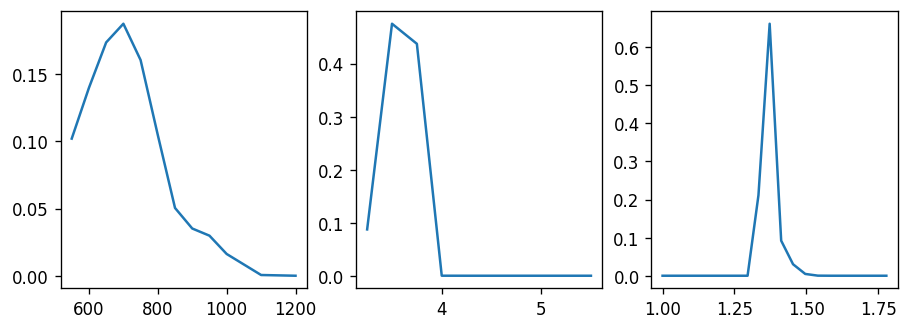

In [27]:
Teff_prior = DBE.eval_prior_function(name,3,param_list[0],rtol=1e-1) #Teff
logg_prior = DBE.eval_prior_function(name,4,param_list[1],rtol=1e-3) #logg
radius_prior = DBE.eval_prior_function(name,5,radii,rtol=1e-3)       #radii

Teff_phc = Teff_prior.reshape((12,1,1,1,1,1,1,1))
logg_phc = logg_prior.reshape((1,10,1,1,1,1,1,1))
radius_phc = radius_prior.reshape((1,1,1,1,1,21,1,1))

prior_hypercube1 = Teff_phc*logg_phc*radius_phc

fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=120)
ax[0].plot(param_list[0],Teff_prior)
ax[1].plot(param_list[1],logg_prior)
ax[2].plot(radii,radius_prior)
plt.show()

In [28]:
print(Teff_prior.shape,logg_prior.shape,radius_prior.shape)

(12,) (10,) (21,)


In [337]:
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])
    # if you want it in a list of indices . . . 
    # return np.array(np.unravel_index(idx, arr.shape))[:, range(k)].transpose().tolist()

k = 1
a_,b_,c_,d_,e_,g_,h_,i_ = get_indices_of_k_smallest(-logLike_hypercube1-np.log10(prior_hypercube1),k)
a, b, c, d, e, g, h, i = a_[-1],b_[-1],c_[-1],d_[-1],e_[-1],g_[-1],h_[-1],i_[-1]

/tmp/ipykernel_3564295/921647115.py:8: RuntimeWarning: divide by zero encountered in log10
  a_,b_,c_,d_,e_,g_,h_,i_ = get_indices_of_k_smallest(-logLike_hypercube1-np.log10(prior_hypercube1),k)


In [338]:
-logLike_hypercube1[a, b, c, d, e, g, h, i]

6577.28728250051

In [339]:
Rbest= radii[g]
ehatb = ehats[h]
fholeb = fholes[i]

#fbest = create(grid_logkzzs[a],grid_teffs[b],grid_gs[c],grid_mhs[d],grid_cos[e])
#w,f = load(fbest)
best_params = [param_list[0][a],param_list[1][b],param_list[2][c],param_list[3][d],param_list[4][e]]
print(best_params)
c100best = c100(best_params)[0]
c2700best = c2700(best_params)[0]
f100best = f100(best_params)[0]
f2700best = f2700(best_params)[0]
y100b = (1-fholeb)*c100best + (fholeb)*f100best
y2700b = (1-fholeb)*c2700best + (fholeb)*f2700best

d2fb = (Rbest*Rjup/d_star/pc)**2
Rbest,ehatb,fholeb,d2fb

[750.0, 3.25, 0.5, 0.229, 2.0]


(1.372460961007562, 1.75, 0.5, 1.1695758417463381e-20)

In [340]:
all_nodes = fs_nodes['all']
hpf_y, _ = filter_spec_with_spline(c2700.wavelength,y2700b*d2fb,x_nodes=all_nodes)

In [341]:
full_param_list = param_list+[list(radii),list(ehats),list(fholes)]
names = [r'Teff',r'log g',r'[M/H]',r'C/O',r'log Kzz',r'Rp',r'ehat',r'f$_h$']

/tmp/ipykernel_3583896/3590774499.py:1: RuntimeWarning: divide by zero encountered in log10
  full_ims1, full_diag1 = triangle(logLike_hypercube1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


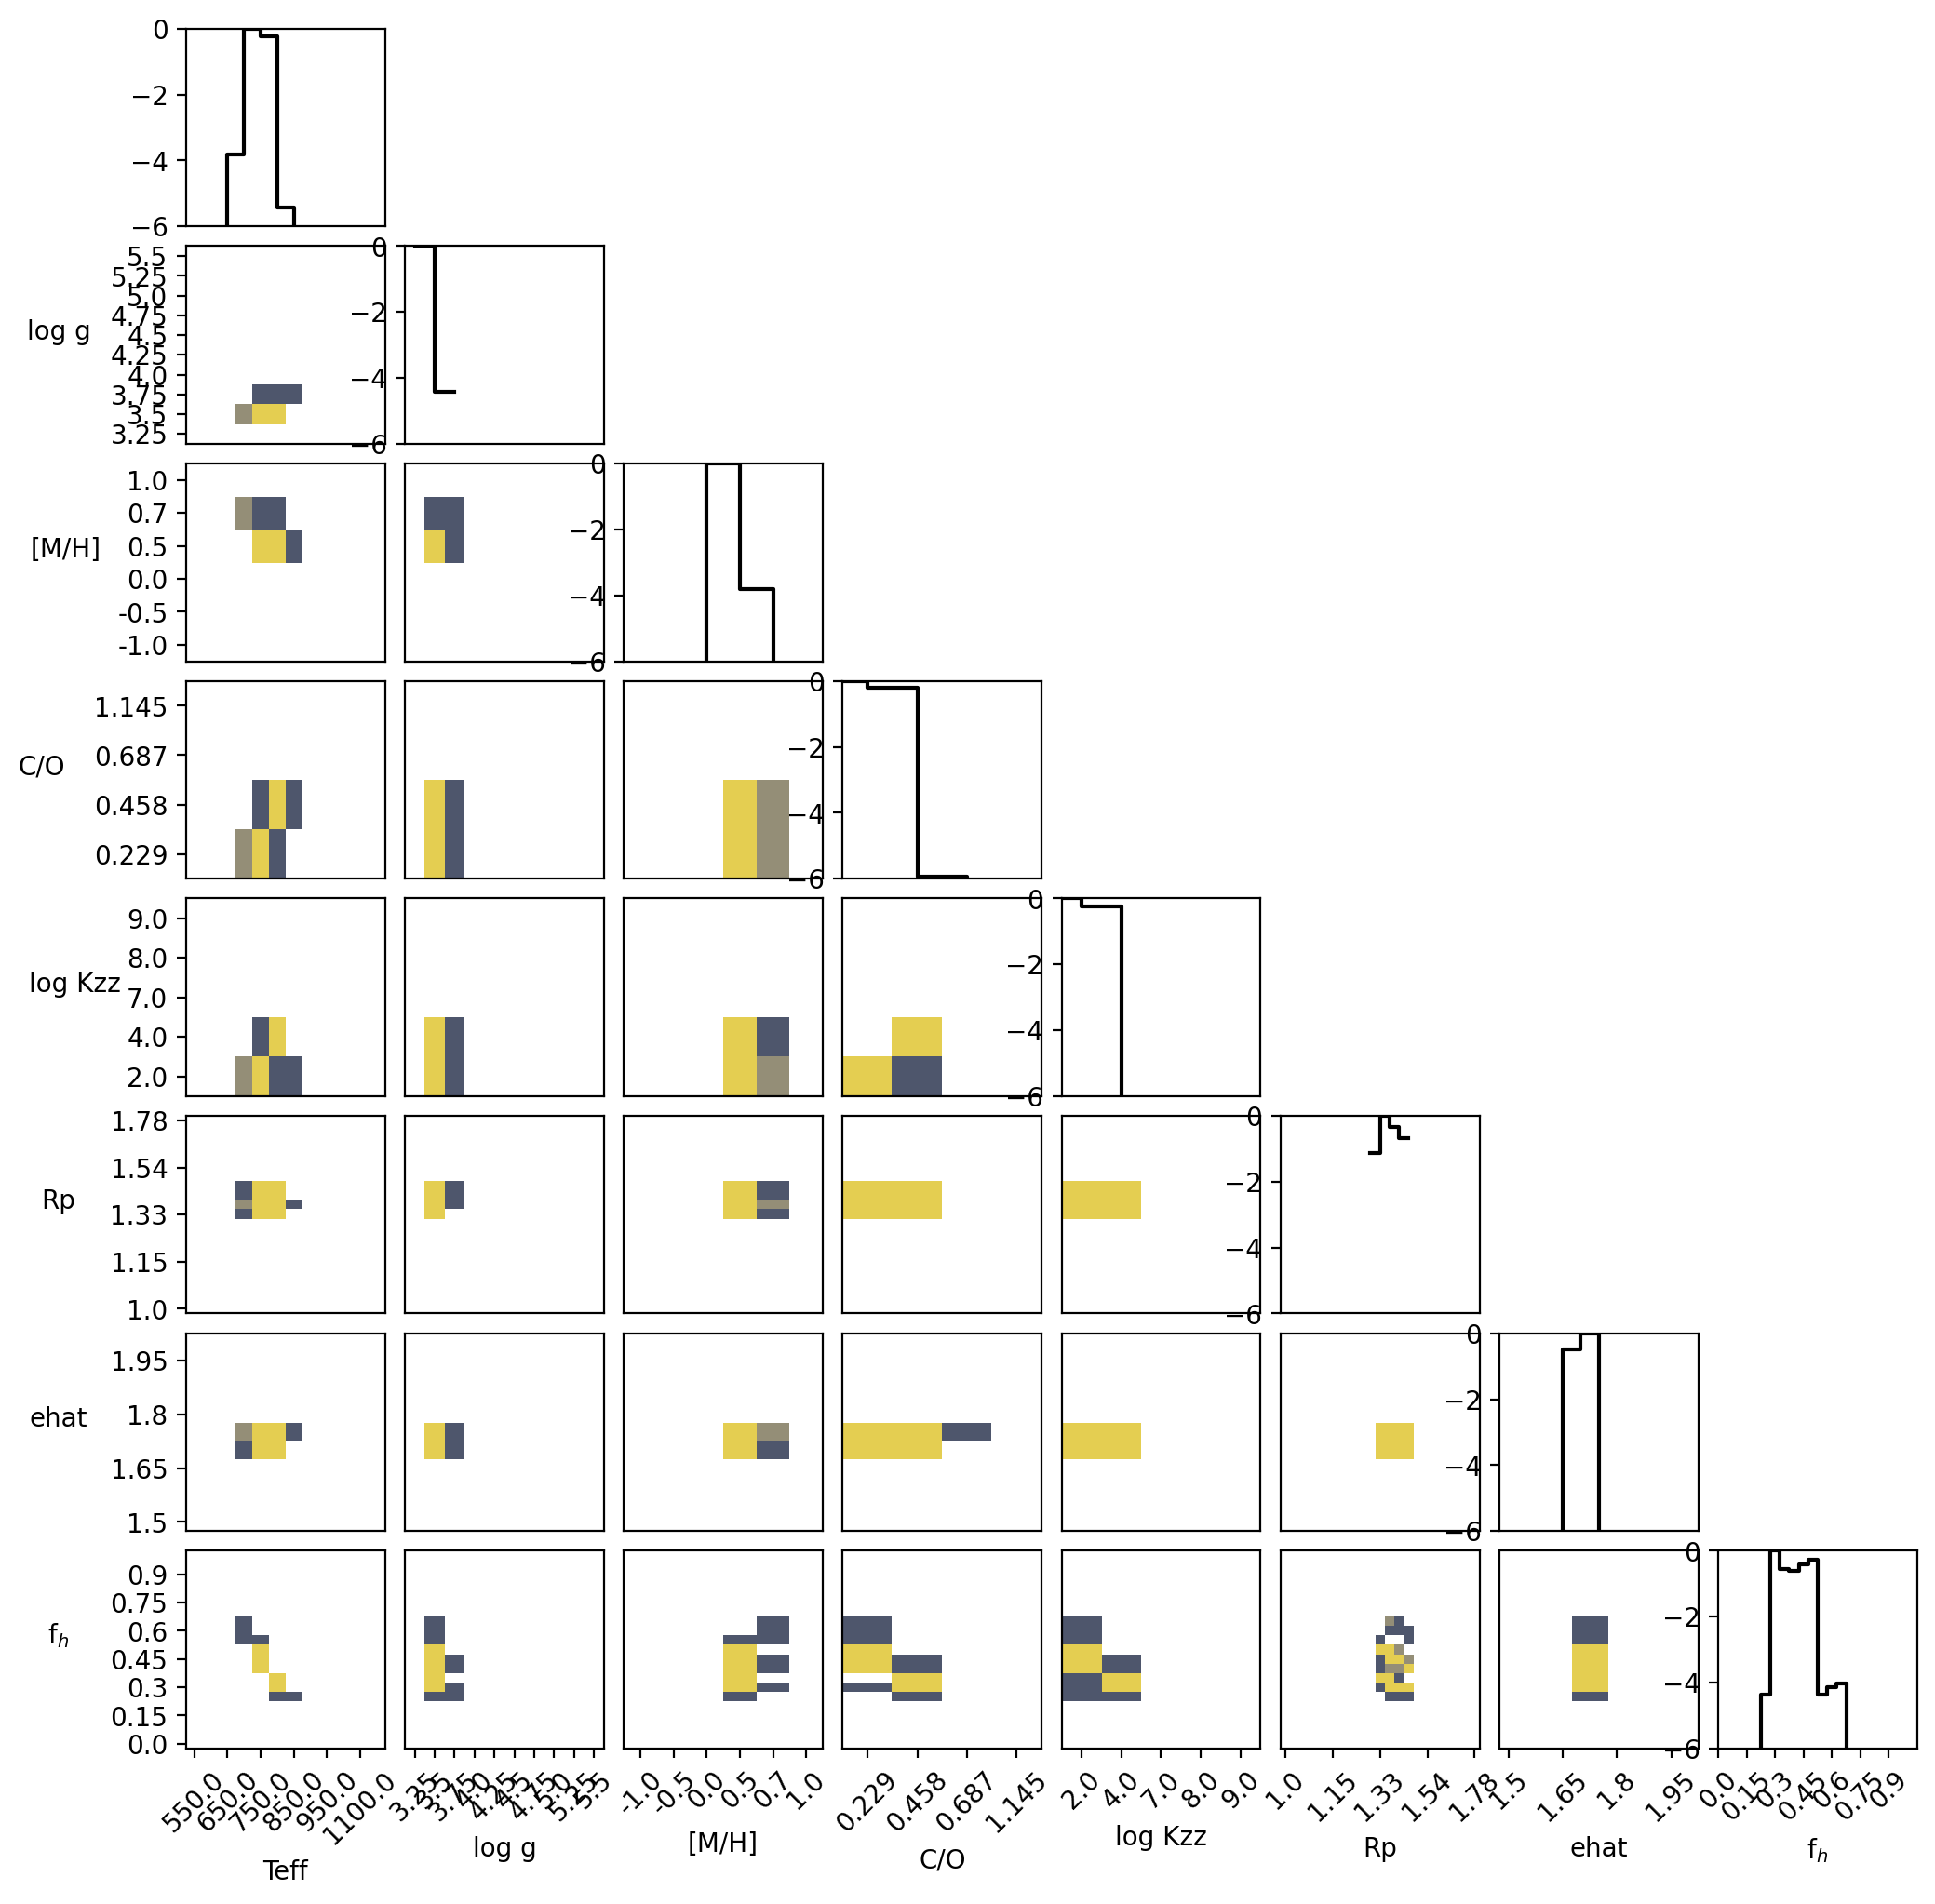

/tmp/ipykernel_3583896/3590774499.py:3: RuntimeWarning: divide by zero encountered in log10
  GPI_ims1, GPI_diag1 = triangle(logLike_GPI_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


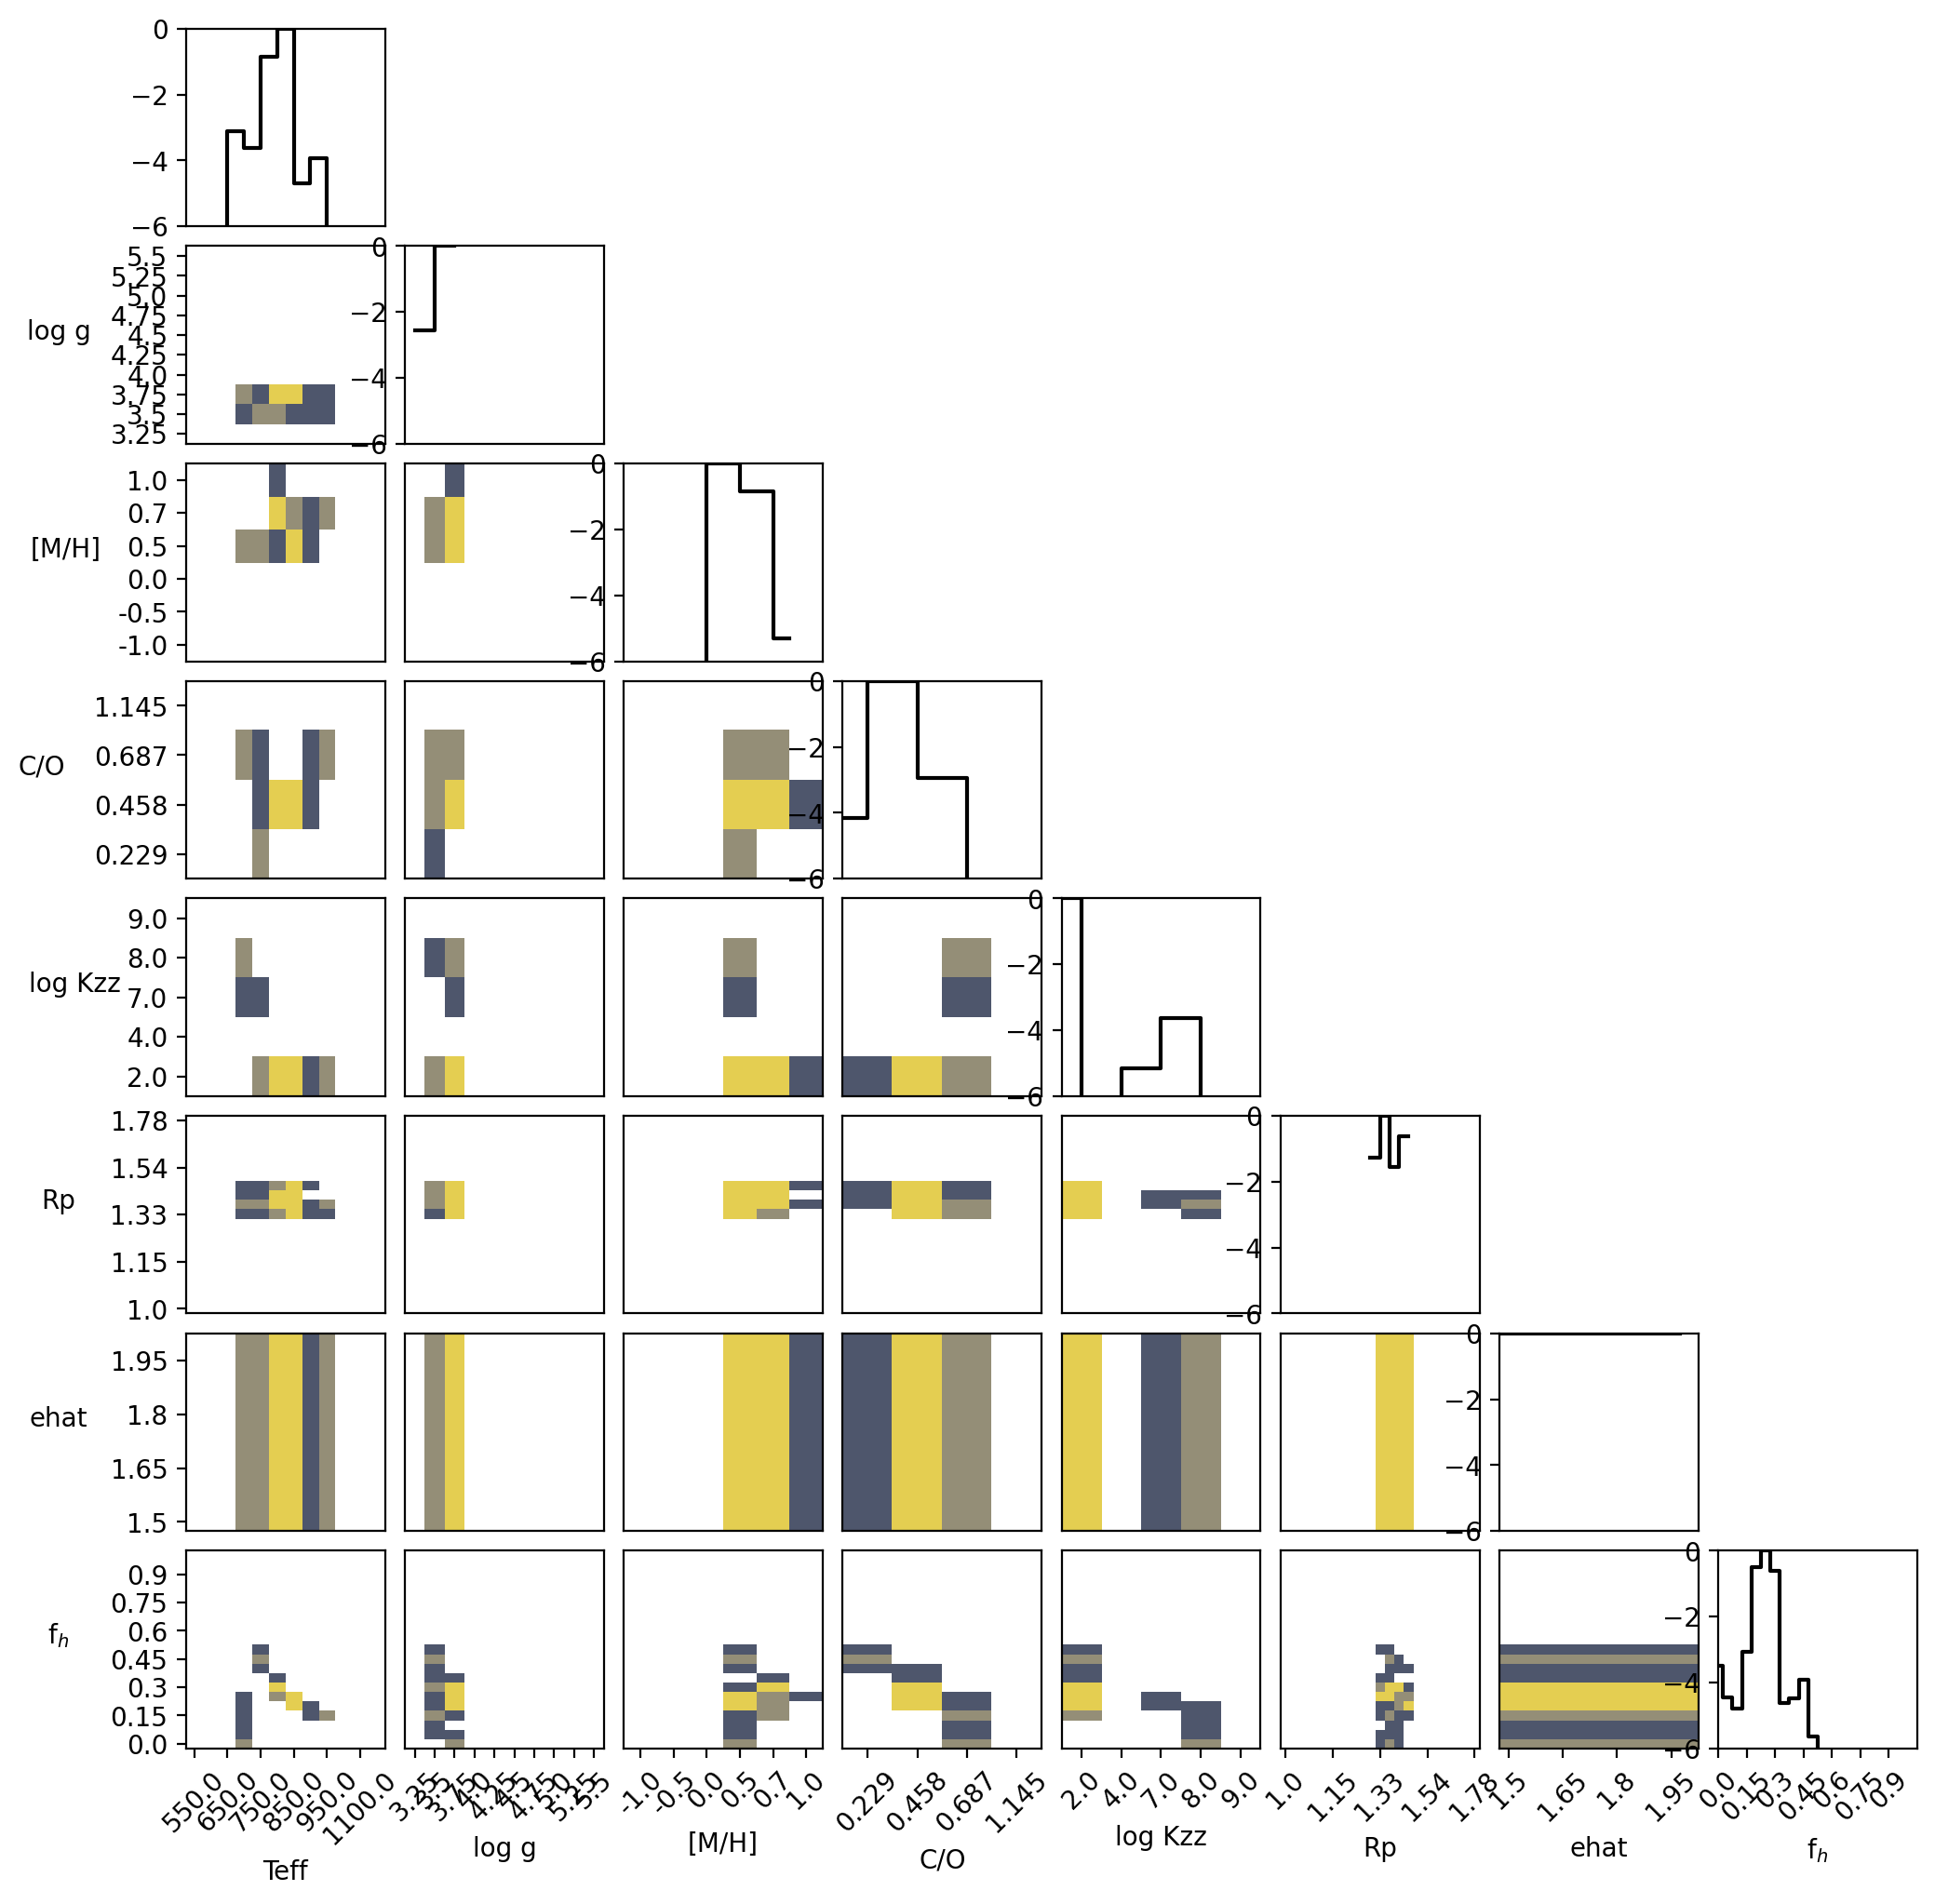

/tmp/ipykernel_3583896/3590774499.py:4: RuntimeWarning: divide by zero encountered in log10
  phot_ims1, phot_diag1 = triangle(logLike_phot_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


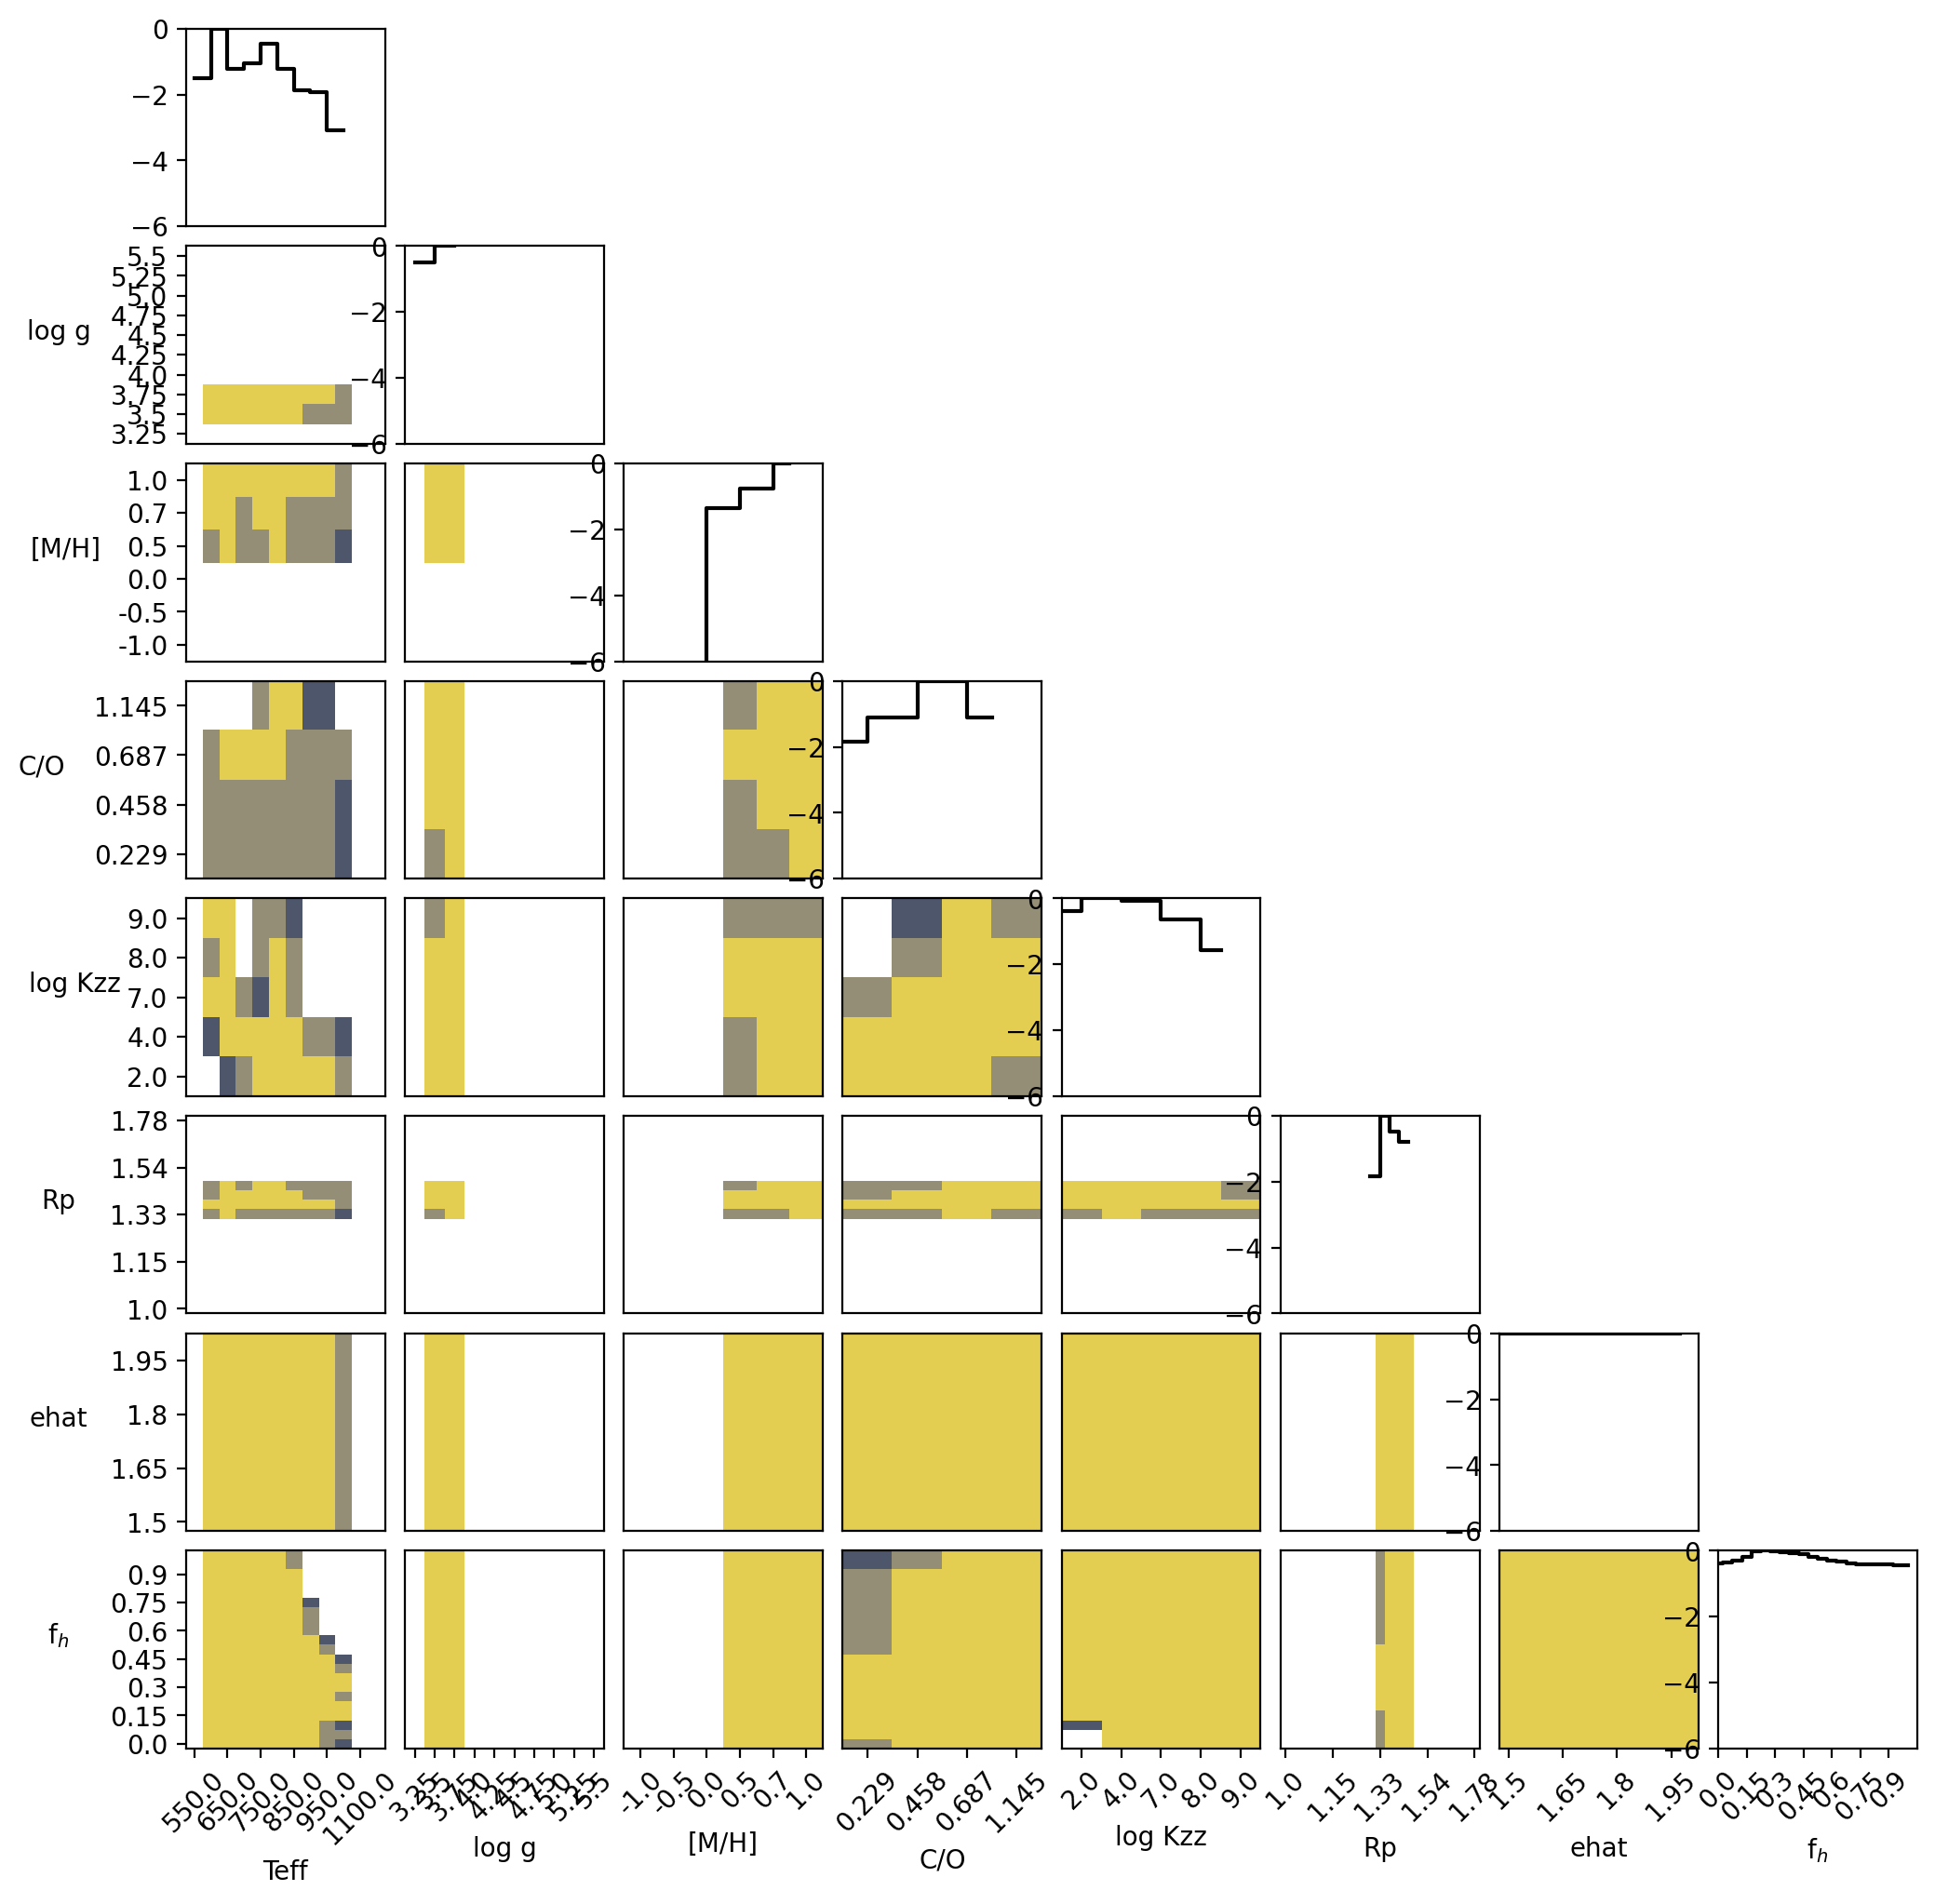

/tmp/ipykernel_3583896/3590774499.py:5: RuntimeWarning: divide by zero encountered in log10
  nirspec_ims1, nirspec_diag1 = triangle(logLike_nirspec_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


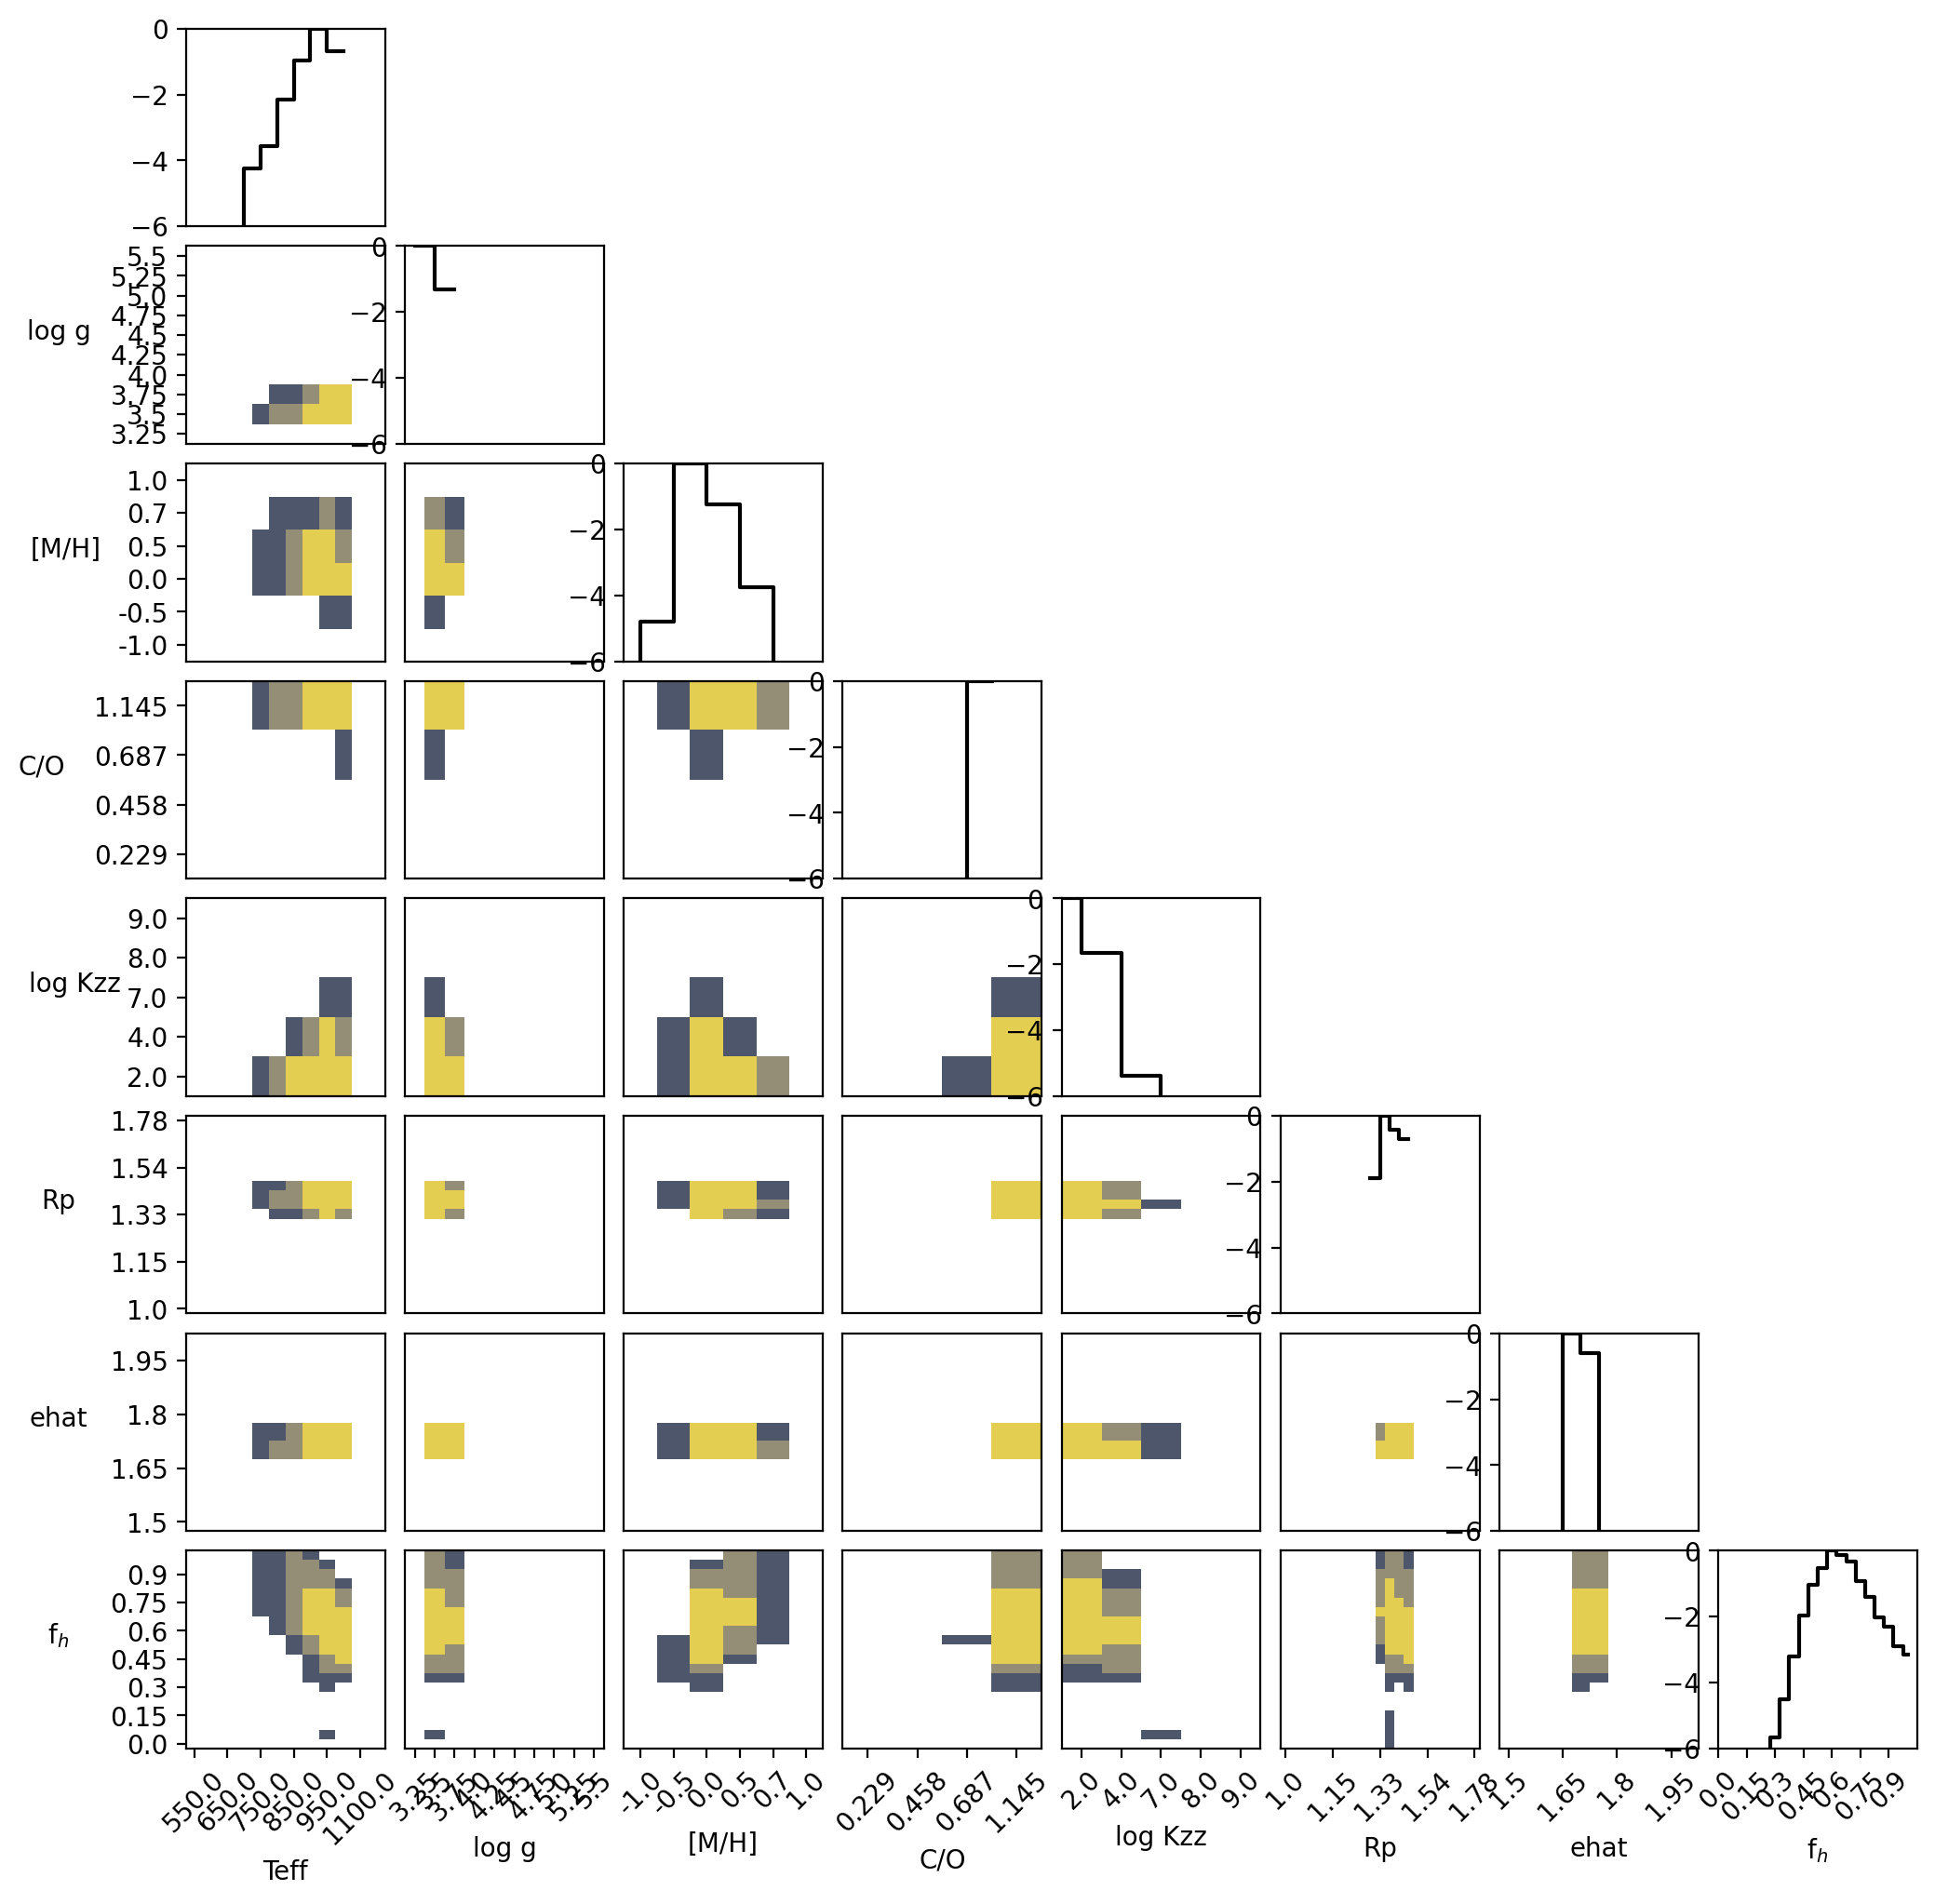

/tmp/ipykernel_3583896/3590774499.py:7: RuntimeWarning: divide by zero encountered in log10
  GPIphot_ims1, GPIphot_diag1 = triangle(logLike_GPIphot_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


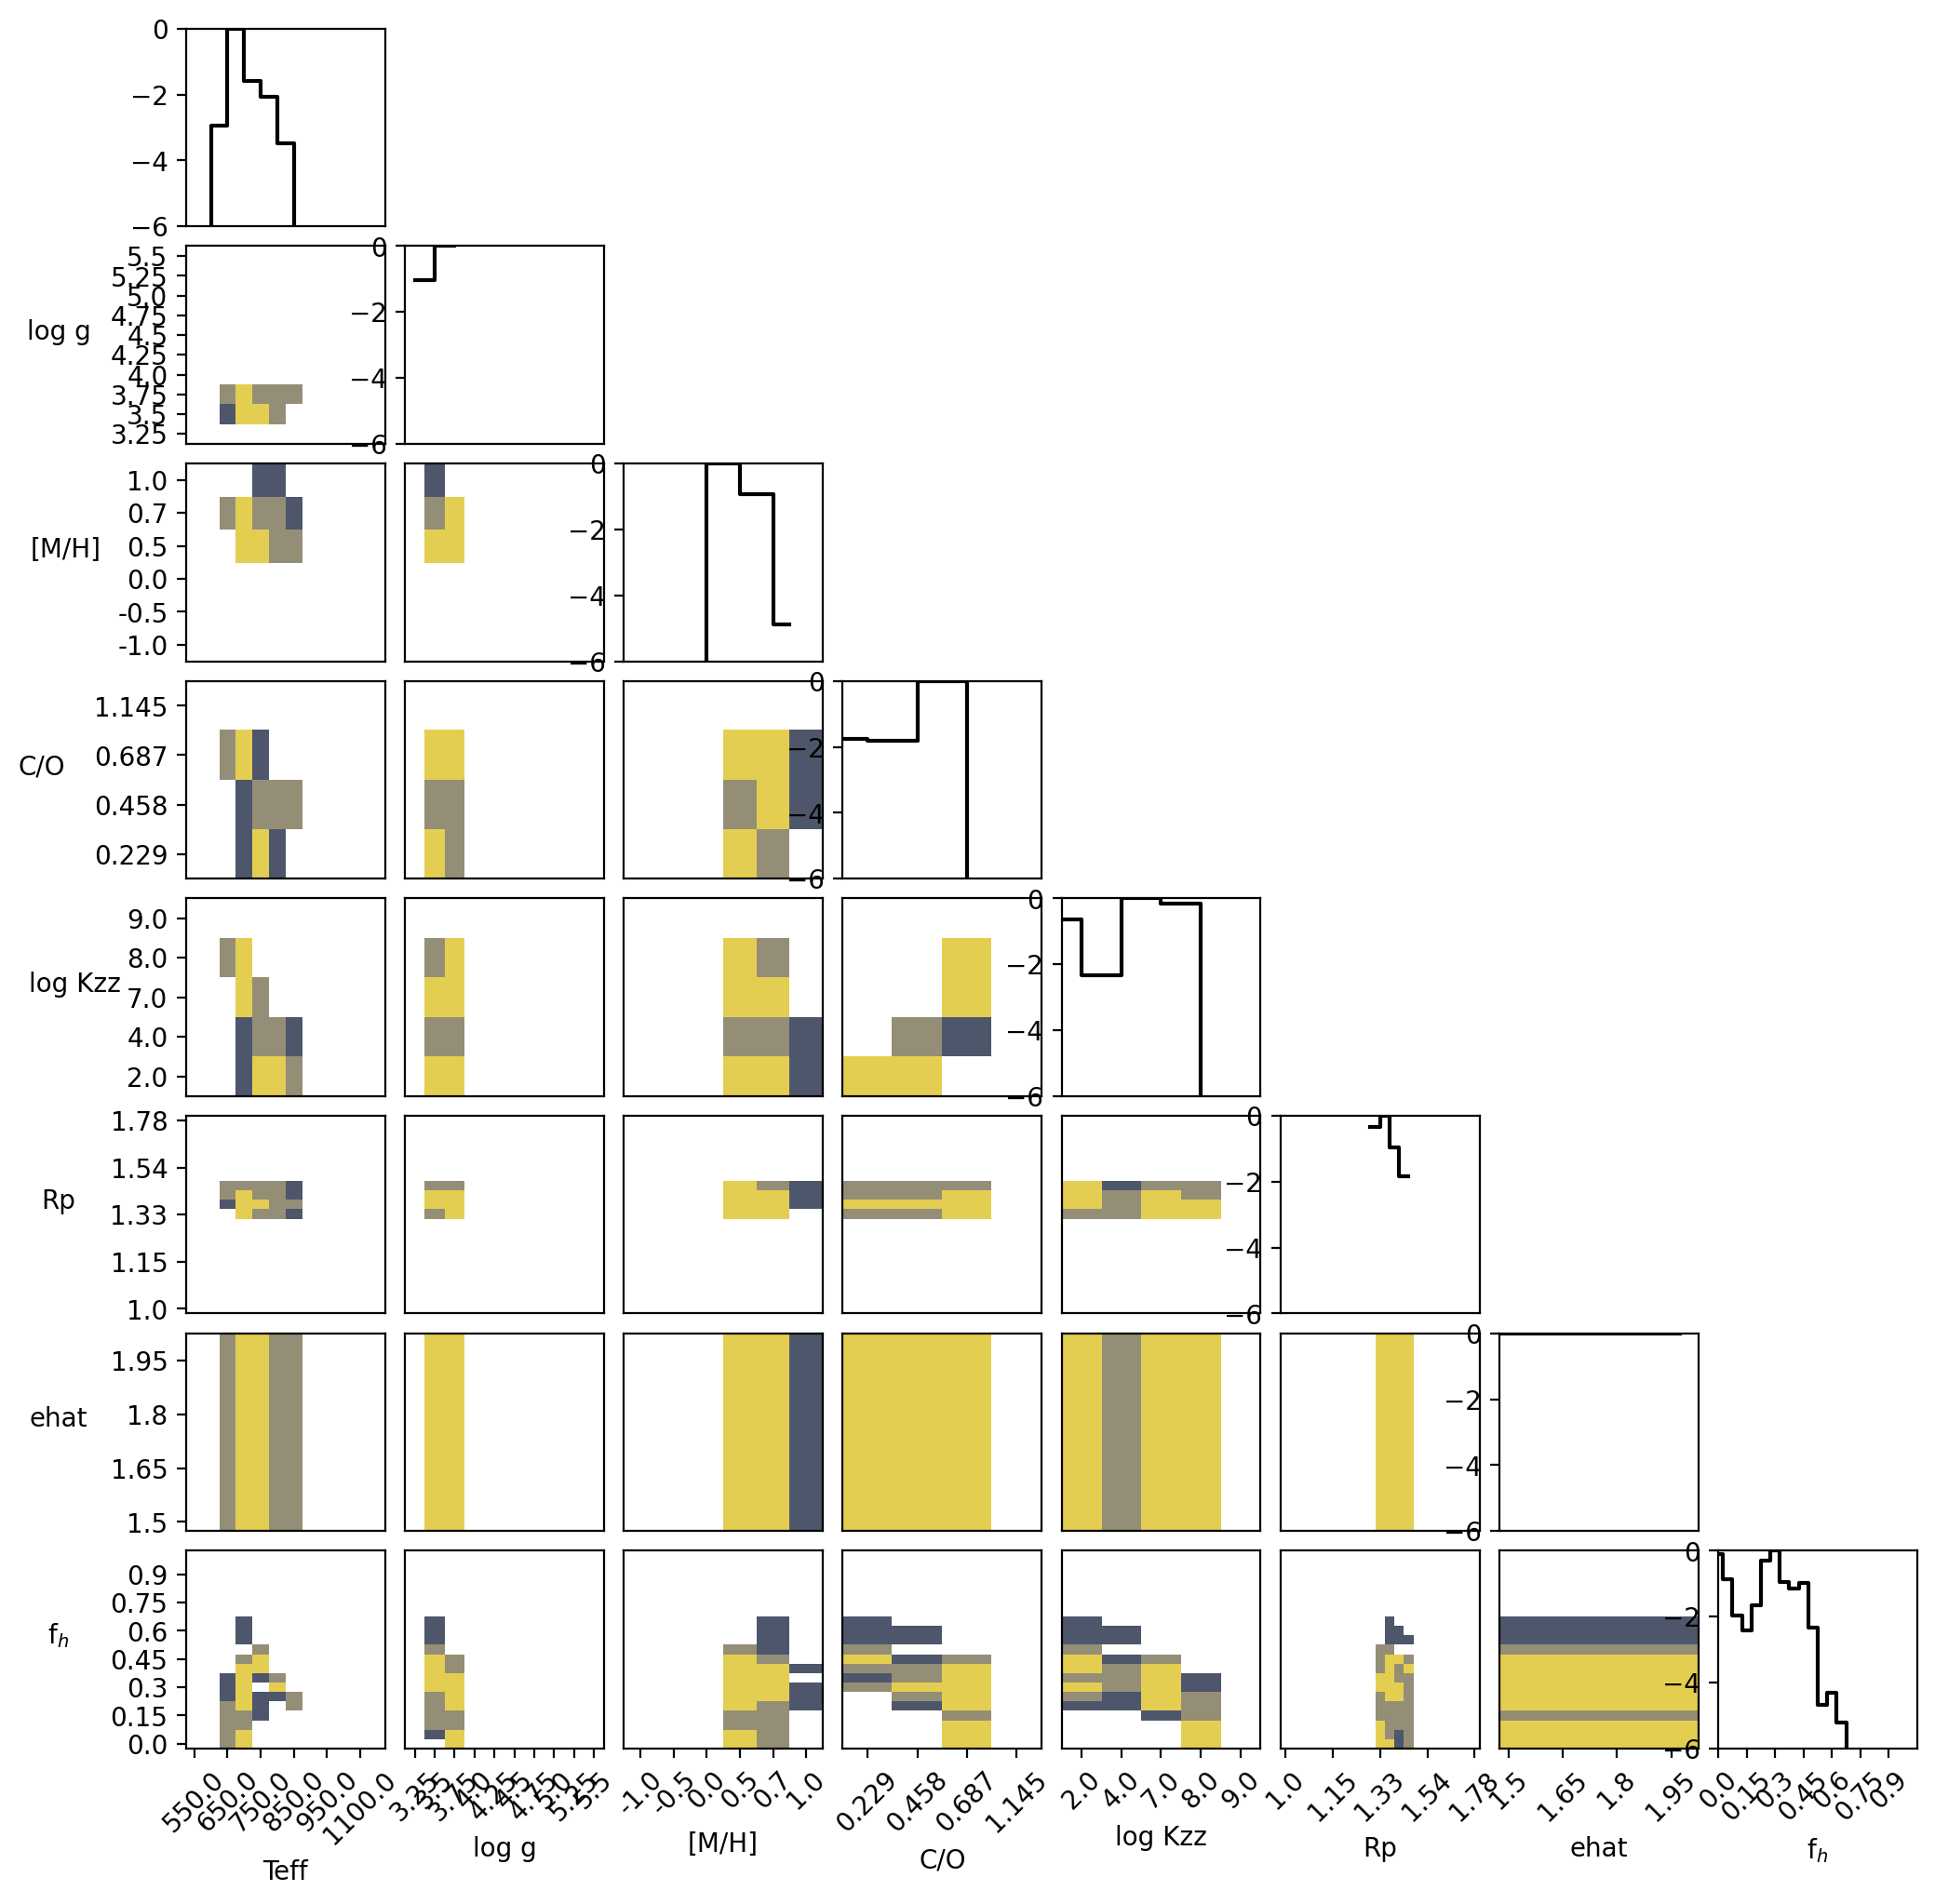

/tmp/ipykernel_3583896/3590774499.py:8: RuntimeWarning: divide by zero encountered in log10
  GPInirspec_ims1, GPInirspec_diag1 = triangle(logLike_GPInirspec_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


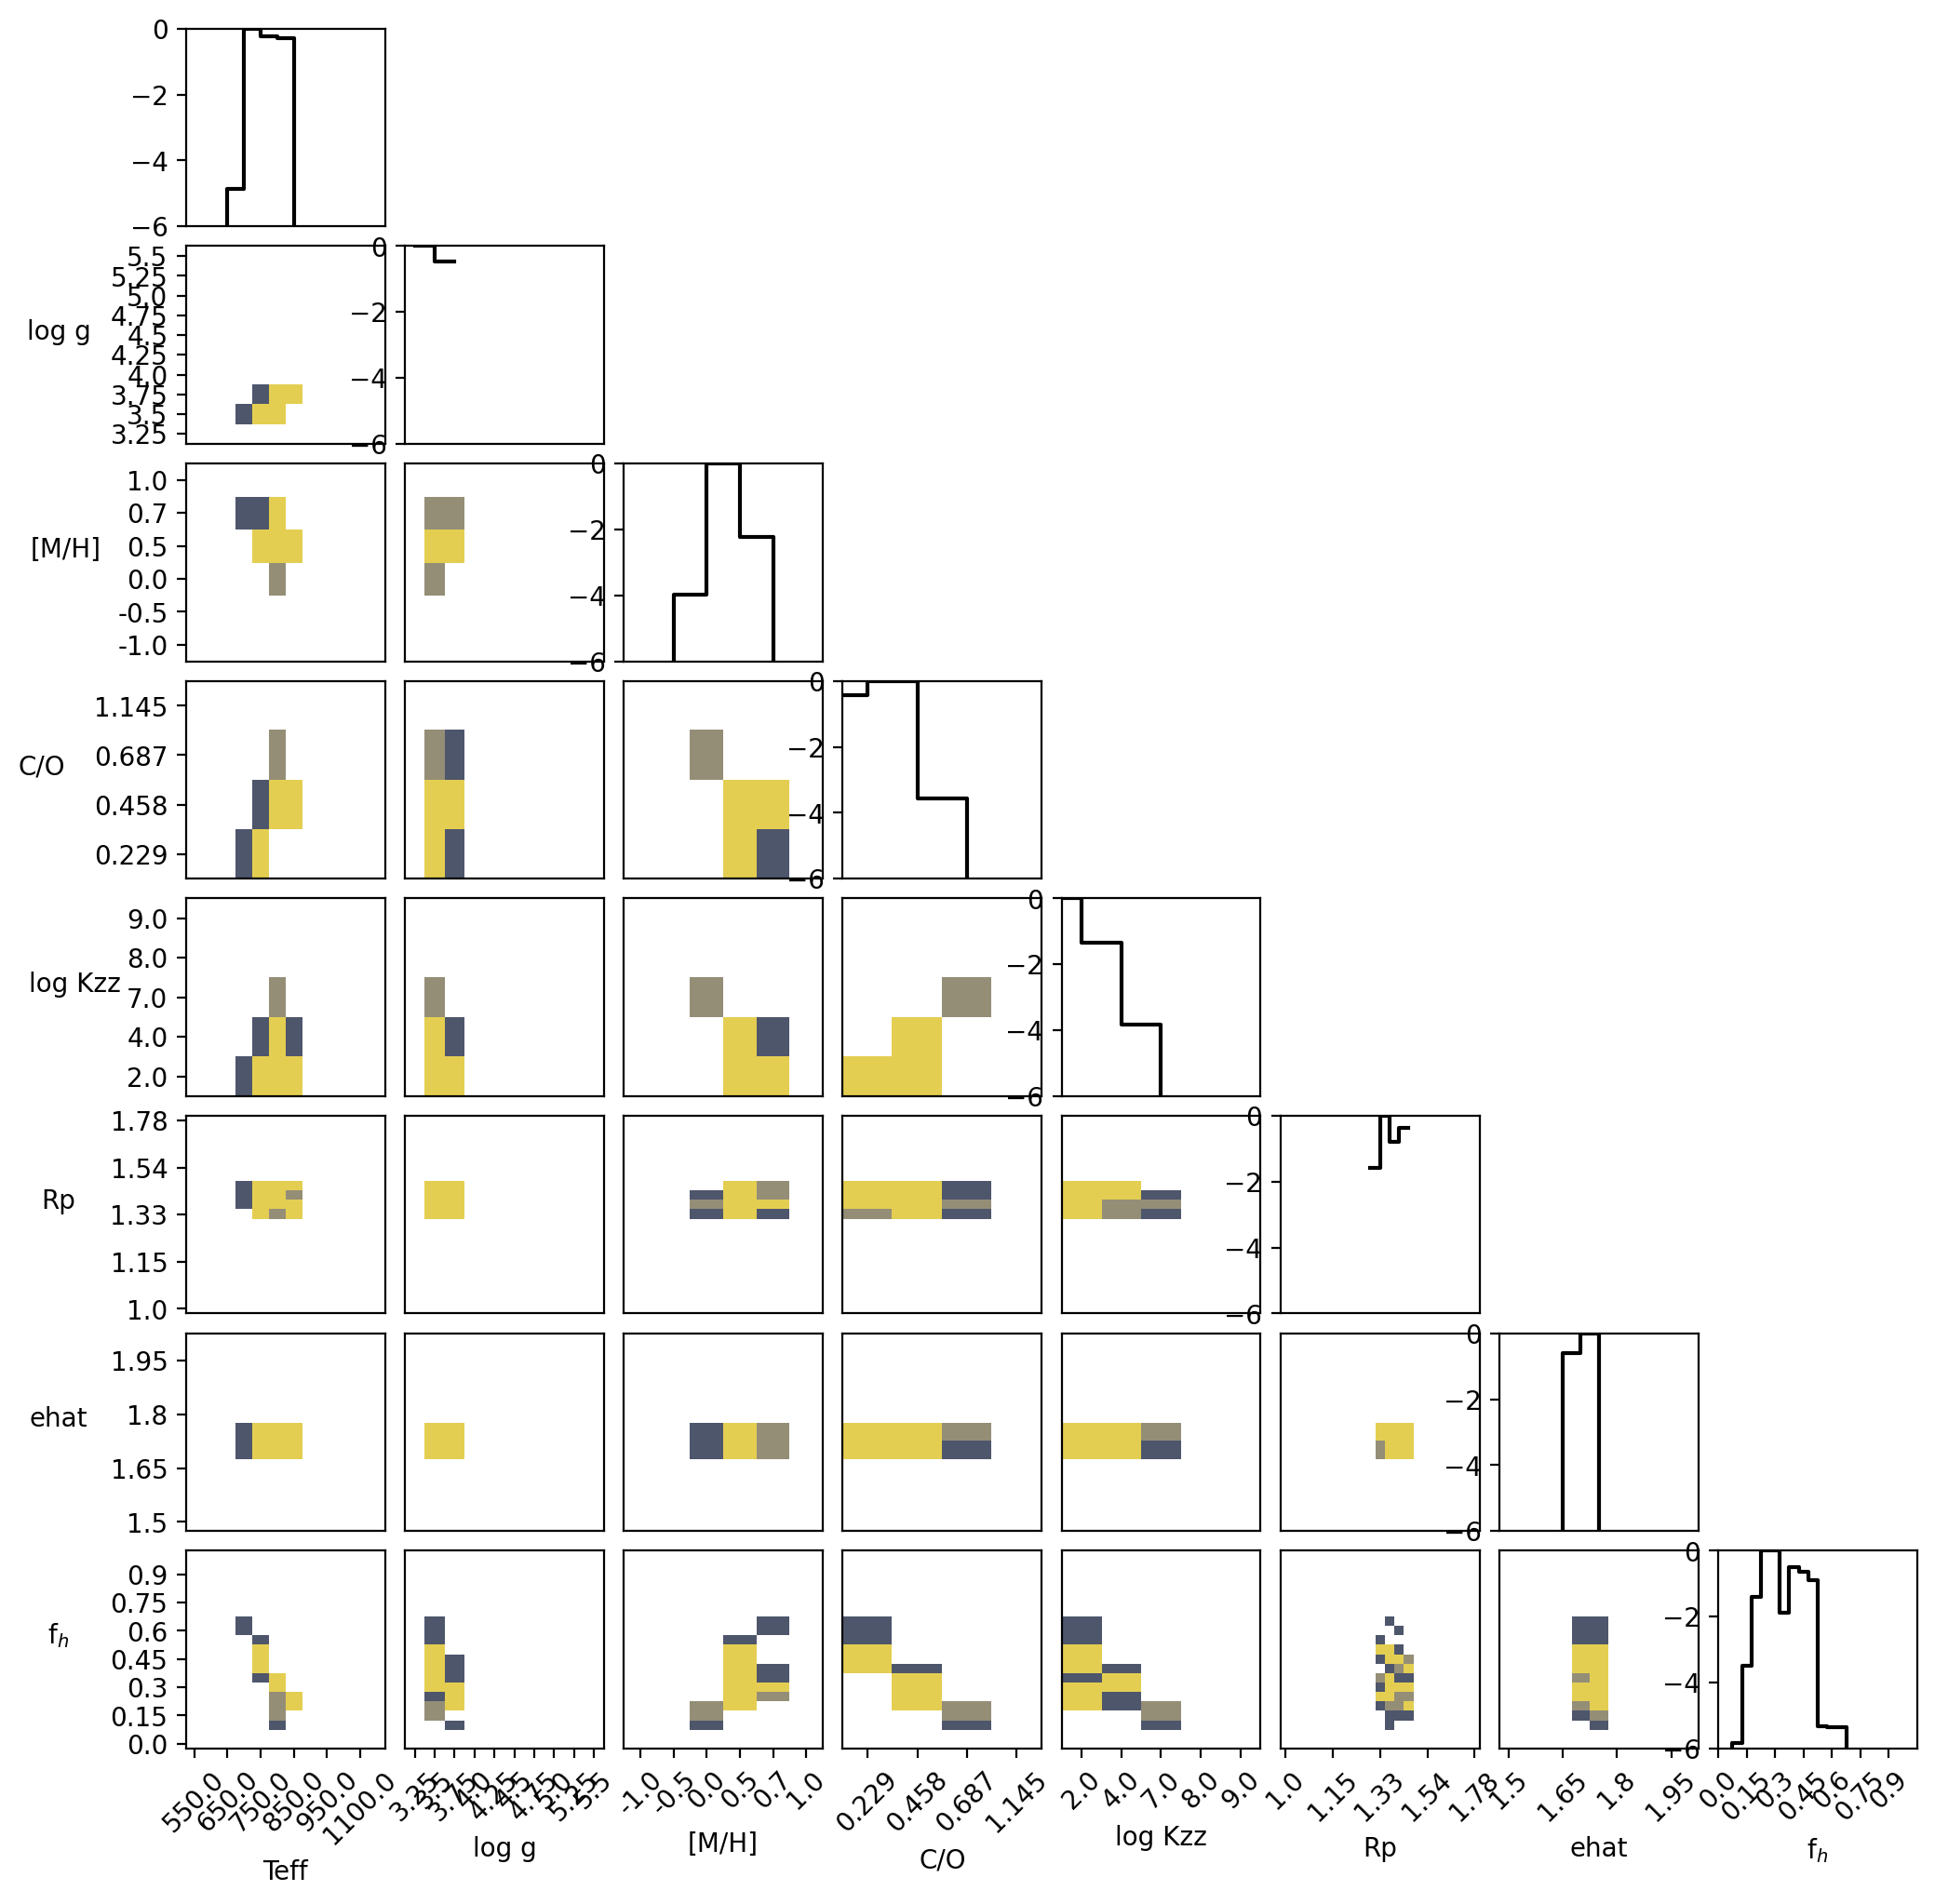

/tmp/ipykernel_3583896/3590774499.py:9: RuntimeWarning: divide by zero encountered in log10
  photnirspec_ims1, photnirspec_diag1 = triangle(logLike_photnirspec_hc1+np.log10(prior_hypercube1))
/tmp/ipykernel_3583896/3256634358.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


In [ ]:
full_ims1, full_diag1 = triangle(logLike_hypercube1+np.log10(prior_hypercube1))

GPI_ims1, GPI_diag1 = triangle(logLike_GPI_hc1+np.log10(prior_hypercube1))
phot_ims1, phot_diag1 = triangle(logLike_phot_hc1+np.log10(prior_hypercube1))
nirspec_ims1, nirspec_diag1 = triangle(logLike_nirspec_hc1+np.log10(prior_hypercube1))

GPIphot_ims1, GPIphot_diag1 = triangle(logLike_GPIphot_hc1+np.log10(prior_hypercube1))
GPInirspec_ims1, GPInirspec_diag1 = triangle(logLike_GPInirspec_hc1+np.log10(prior_hypercube1))
photnirspec_ims1, photnirspec_diag1 = triangle(logLike_photnirspec_hc1+np.log10(prior_hypercube1))

In [342]:
from breads.atm_utils import miniRGI

#mrgi = miniRGI('sonora-elfowl-t', 
#               wavelength_bounds=[2.86, 5.14],
#               R=2700,
#               load_flag = False,
#               save_flag = False,
#               MJy_flag = False
#              )
#template_params = [750.0, 3.25, 0.5, 0.229, 2.0]
#f = mrgi(best_params)[0]
#rescaled_best_fit_flux = f*d2fb

from species.phot.syn_phot import SyntheticPhotometry
BS = ['JWST/NIRCam.F410M','JWST/NIRCam.F430M','JWST/NIRCam.F460M','KECK/NIRC2.Lp','KECK/NIRC2.Ms']#,'JWST/NIRCam.F444W']

JWST/NIRCam.F410M
JWST/NIRCam.F410M 2.4224286709356704e-17
JWST/NIRCam.F430M
JWST/NIRCam.F430M 1.9521322914511452e-17
JWST/NIRCam.F460M
JWST/NIRCam.F460M 5.80170837066039e-18
KECK/NIRC2.Lp
KECK/NIRC2.Lp 1.5206606709860085e-17
KECK/NIRC2.Ms
KECK/NIRC2.Ms 5.840670459662915e-18
F430M 6.805990822018511e-18
F460M 5.53093217674255e-18


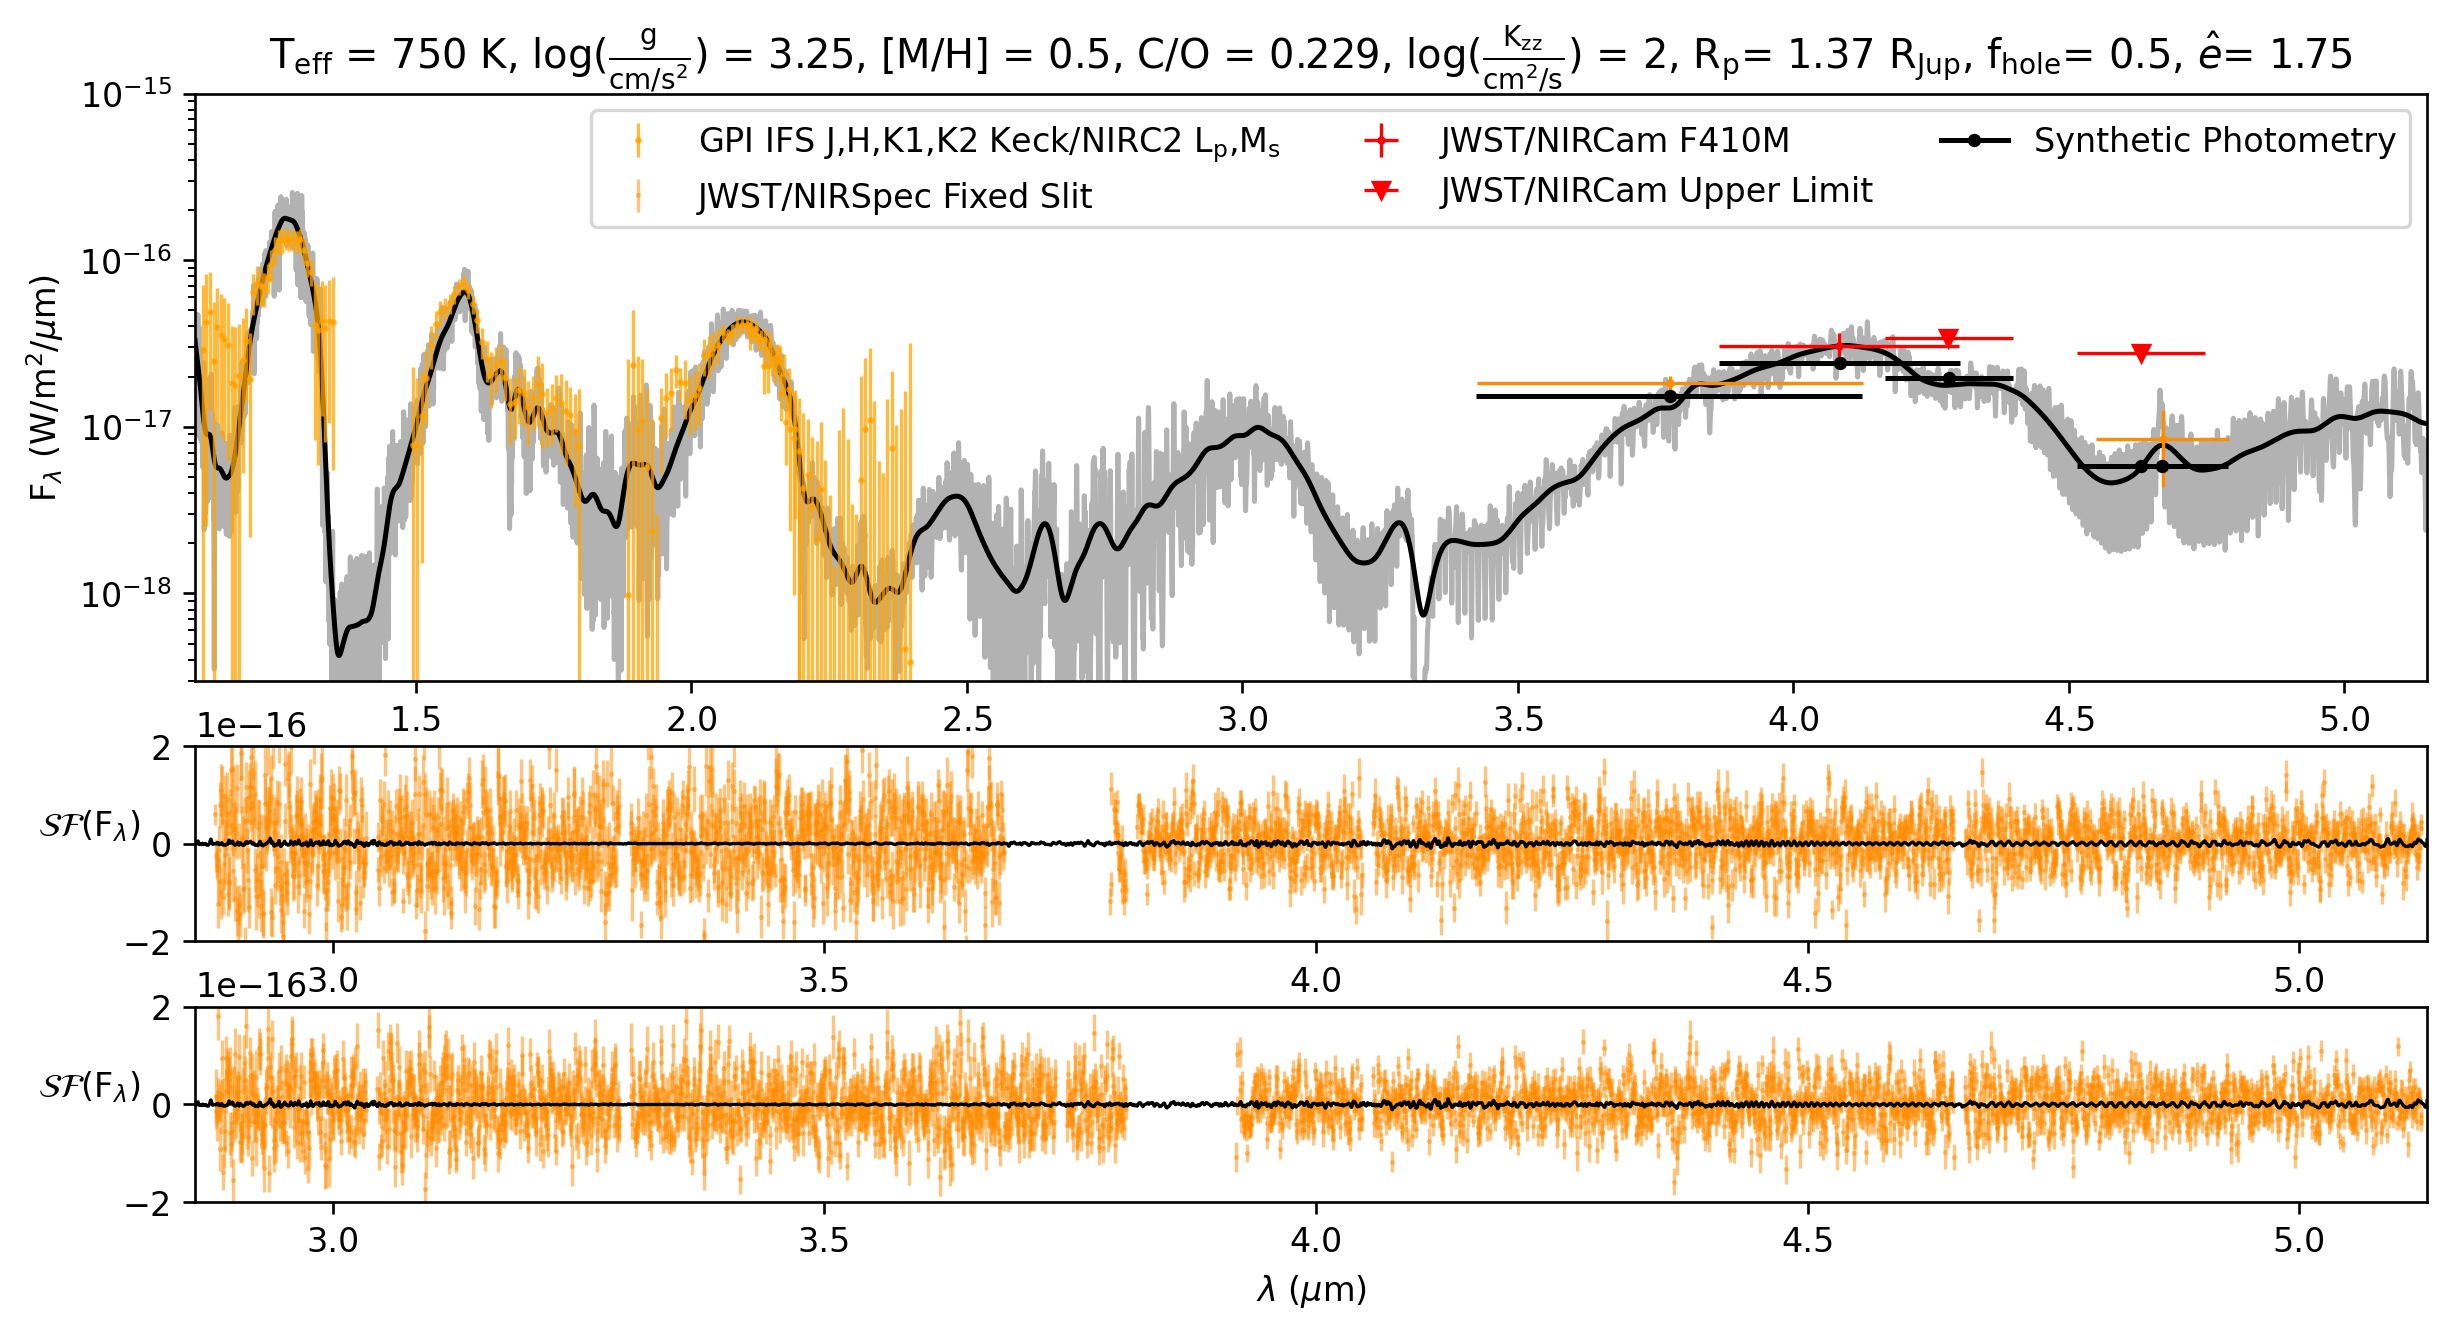

In [343]:
fig,ax = plt.subplots(3,1,figsize=(12,6),dpi=240,sharex=False,sharey=False,gridspec_kw={'height_ratios':[3,1,1]})

ax[0].plot(c100.wavelength,y100b*d2fb,color='k',alpha=1)
ax[0].plot(c100.wavelength,y2700b*d2fb,color='k',alpha=0.3)

ax[0].set_yscale('log')
ax[1].plot(c2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)
ax[2].plot(c2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)

errbars = []

for syn_band in BS:
    print(syn_band)
    synph = SyntheticPhotometry(syn_band)
    bandflux, _ = synph.spectrum_to_flux(c2700.wavelength,y2700b*d2fb) #synph.spectrum_to_flux(mrgi.wavelength,rescaled_best_fit_flux)

    wlr = synph.wavel_range
    Npts = 1000
    w = np.linspace(wlr[0],wlr[1],Npts)
    T = synph.filter_interp(w)
    cross_boolean = abs(T-0.5*np.max(T))<.1
    lTh,rTh = np.mean(w[:Npts//2][cross_boolean[:Npts//2]]),np.mean(w[Npts//2:][cross_boolean[Npts//2:]])
    meanw = np.sum(w*T)/np.sum(T) #np.mean(synph.wavel_range)
    xerr = np.array([meanw-lTh,rTh-meanw]).reshape(2,1)
    #xerr = np.abs(synph.wavel_range - np.mean(synph.wavel_range)).reshape(2,1)
    errbar = ax[0].errorbar(meanw,bandflux,xerr=xerr,color='k',marker='.')
    print(syn_band,bandflux)
    errbars.append(errbar)

xbs = {'F410M':[3.865, 4.301], #3.776356,4.404841],
       'F430M':[4.167, 4.398], #4.122768,4.44487],
       'F460M':[4.515, 4.747], #4.465264,4.814641],
       'L':[3.426, 4.126], #3.334919,4.220463],
       'M':[4.549, 4.790]} #4.496604,4.868843]}

for band in eri51b.wavedict.keys():
    wave = eri51b.wavedict[band]
    y = eri51b.fluxdict[band]
    e = eri51b.errordict[band]
    if band in ['J','H','K1','K2']:
        errbar = ax[0].errorbar(wave,y,e,linestyle='none',marker='.',color='orange',markersize=2,linewidth=1,alpha=.75,markerfacecolor='darkorange')

    elif band in ['F410M','L','M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        color = 'red' if 'F' in band else 'darkorange'
        errbar = ax[0].errorbar(wave,y,e,xerr=xerr,linestyle='none',marker='.',color=color,markersize=3,linewidth=1,alpha=1)
    elif band in ['F430M','F460M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        print(band,e)
        errbar = ax[0].errorbar(wave,5*e,xerr=xerr,linestyle='none',marker='v',color='red',markersize=5,linewidth=1,alpha=1)
    elif band in FSkeys:
        axi = 1 if 'a1' in band else 2
        errbar = ax[axi].errorbar(wave,y,e,linestyle='none',marker='.',color='darkorange',markersize=1,linewidth=1,alpha=0.5)
    errbars.append(errbar)
    
ax[0].set_xlim([1.1,5.15])
ax[0].set_xscale('linear')
ax[0].set_xticks([1.5,2,2.5,3,3.5,4,4.5,5])
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax[0].set_ylim([-0.5e-16,2.5e-16])
ax[0].set_ylim([3e-19,1e-15])
ax[0].legend([errbars[0+len(BS)],errbars[-1],errbars[6+len(BS)],errbars[7+len(BS)],errbars[0]],
             ['GPI IFS J,H,K1,K2 Keck/NIRC2 L$_\mathrm{p}$,M$_\mathrm{s}$','JWST/NIRSpec Fixed Slit',
            'JWST/NIRCam F410M','JWST/NIRCam Upper Limit','Synthetic Photometry'],
             bbox_to_anchor=[1,1,0,0],loc='upper right',ncol=3)

#nrsw = eri51b.wavedict['a1n2p']
#ax[1].set_xlim([np.min(nrsw),np.max(nrsw)])
y = 2e-16
ax[1].set_ylim([-y,y])
ax[2].set_ylim([-y,y])

ax[1].set_xlim([2.86,5.13])
ax[2].set_xlim([2.86,5.13])

plt.savefig('atm.png')

ax[2].set_xlabel(r'$\lambda$ ($\mu$m)')
ax[0].set_ylabel(r'F$_\lambda$ (W/m$^2$/$\mu$m)')
ax[1].set_ylabel(r'$\mathcal{SF}$(F$_\lambda$)',rotation=0,labelpad=10)
ax[2].set_ylabel(r'$\mathcal{SF}$(F$_\lambda$)',rotation=0,labelpad=10)

ax[0].set_title(r'T$_\mathrm{eff}$'+' = {} K, '.format(int(best_params[0]))+ \
               r'$\log (\frac{\mathrm{g}}{\mathrm{cm}/\mathrm{s}^2})$'+' = {}, '.format(np.round(best_params[1],2))+ \
                r'[M/H]'+' = {}, '.format((best_params[2]))+ \
                r'C/O'+' = {}, '.format((best_params[3]))+ \
                r'$\log (\frac{\mathrm{K}_\mathrm{zz}}{\mathrm{cm}^2/\mathrm{s}})$'+' = {}, '.format(int(best_params[4]))+ \
                r'R$_\mathrm{p}$'+'= {}'.format(np.round(Rbest,2))+r' R$_\mathrm{Jup}$, '+ \
                r'f$_\mathrm{hole}$'+'= {}, '.format(fholeb)+ \
                r'$\hat{e}$'+'= {}'.format(np.round(ehatb,2))
               )
plt.show()

In [36]:
cubelist = glob.glob('saved/final/cube_*p.fits')

FSkeys = []

wavedict_wnan = {}
fluxdict_wnan = {}
errdict_wnan = {}
nanbools = {}

for cfile in cubelist:
    key = cfile.split('.')[-2].split('_')[-1]
    print(key)
    FSkeys.append(key)
    hdulist = fits.open(cfile)
    

    flux = hdulist[0].data[:,30,0]
    err = hdulist[1].data[:,30,0]
    wave = hdulist[4].data

    nanbool = np.logical_not(np.isnan(flux))
    #flux = flux[nanbool]
    #err = err[nanbool]
    #wave = wave[nanbool]
    
    #[Y W/m^2/um] = 2.99792458E+14 * [X1 W/m^2/Hz] / [X2 um]^2
    #1 J y = 1e-26 W/m^2/Hz
    flux = flux*1e6*1e-26*2.99792458e14/(wave)**2 #MJY -> Jy -> W/m^2/Hz -> W/m^2/um
    err = err*1e6*1e-26*2.99792458e14/(wave)**2

    wavedict_wnan[key] = wave
    fluxdict_wnan[key] = flux
    errdict_wnan[key] = err
    nanbools[key] = nanbool

a1n1p
a1n2p
a2n1p
a2n2p


(3.0, 5.12)

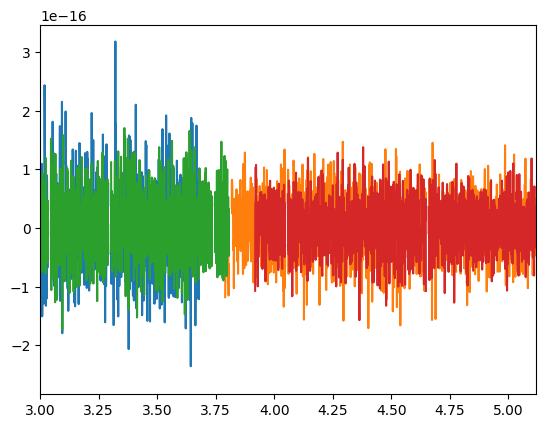

In [37]:
#band = 'a2n1p'
residuals = {}
res_waves = {}
for band in ['a1n1p','a1n2p','a2n1p','a2n2p']:
    wave = wavedict_wnan[band]
    y = fluxdict_wnan[band]
    
    yi = np.interp(wave,c2700.wavelength,hpf_y).reshape(-1,1)
    res = y#-yi
    res_waves[band] = wave
    residuals[band] = res
    plt.plot(wave,res)
plt.xlim([3,5.12])

In [38]:
from scipy.ndimage import generic_filter

def correlate(wave,normalized_speckles):
    corrs = []
    #print(range(len(wave)))
    for idelt in range(len(wave)):
        if idelt == 0:
            left_speckles = normalized_speckles[:]
            right_speckles = normalized_speckles[:]
        else: 
            left_speckles = normalized_speckles[:-idelt]
            right_speckles = normalized_speckles[idelt:]
        prod = left_speckles*right_speckles
        #print(prod[20:40])
        mean_corr = np.nanmean(prod)
        corrs.append(mean_corr)
    return corrs

corrs = {}
models = {}
matrices = {}
inverses = {}
for band in residuals.keys():    
    
    correlations = correlate(wavedict_wnan[band],residuals[band])
    #corrs[band] = correlations/correlations[0]

    small_c = np.zeros(len(correlations))
    model = np.zeros(len(correlations))
    
    small_c[0:3] = correlations[0:3]-correlations[3]
    large_c = np.copy(correlations)
    large_c[0:3] = correlations[3]
    
    # smooth large component with running mean
    large_c = generic_filter(large_c,np.nanmean,size=1)
    corr = small_c + large_c
    corr /= corr[0]

    model[0:3] = corr[0:3]
    corrs[band] = corr
    models[band] = model

    indices = np.arange(len(corr))
    corr_matrix_distances = np.abs(indices[:,None]-indices[None,:])
    corr_m = np.interp(corr_matrix_distances,indices,model)

    err = errdict_wnan[band]
    err_op = err[:,None]*err[None,:]
    cov_m = corr_m * err_op
    
    nanbool = nanbools[band]
    cov_m = cov_m[nanbool,:][:,nanbool]

    cov_inv = np.linalg.inv(cov_m)

    matrices[band] = cov_m
    inverses[band] = cov_inv

/tmp/ipykernel_3564295/628048165.py:15: RuntimeWarning: Mean of empty slice
  mean_corr = np.nanmean(prod)
/home/amadurowicz/miniconda3/envs/stenv/lib/python3.11/site-packages/scipy/ndimage/_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


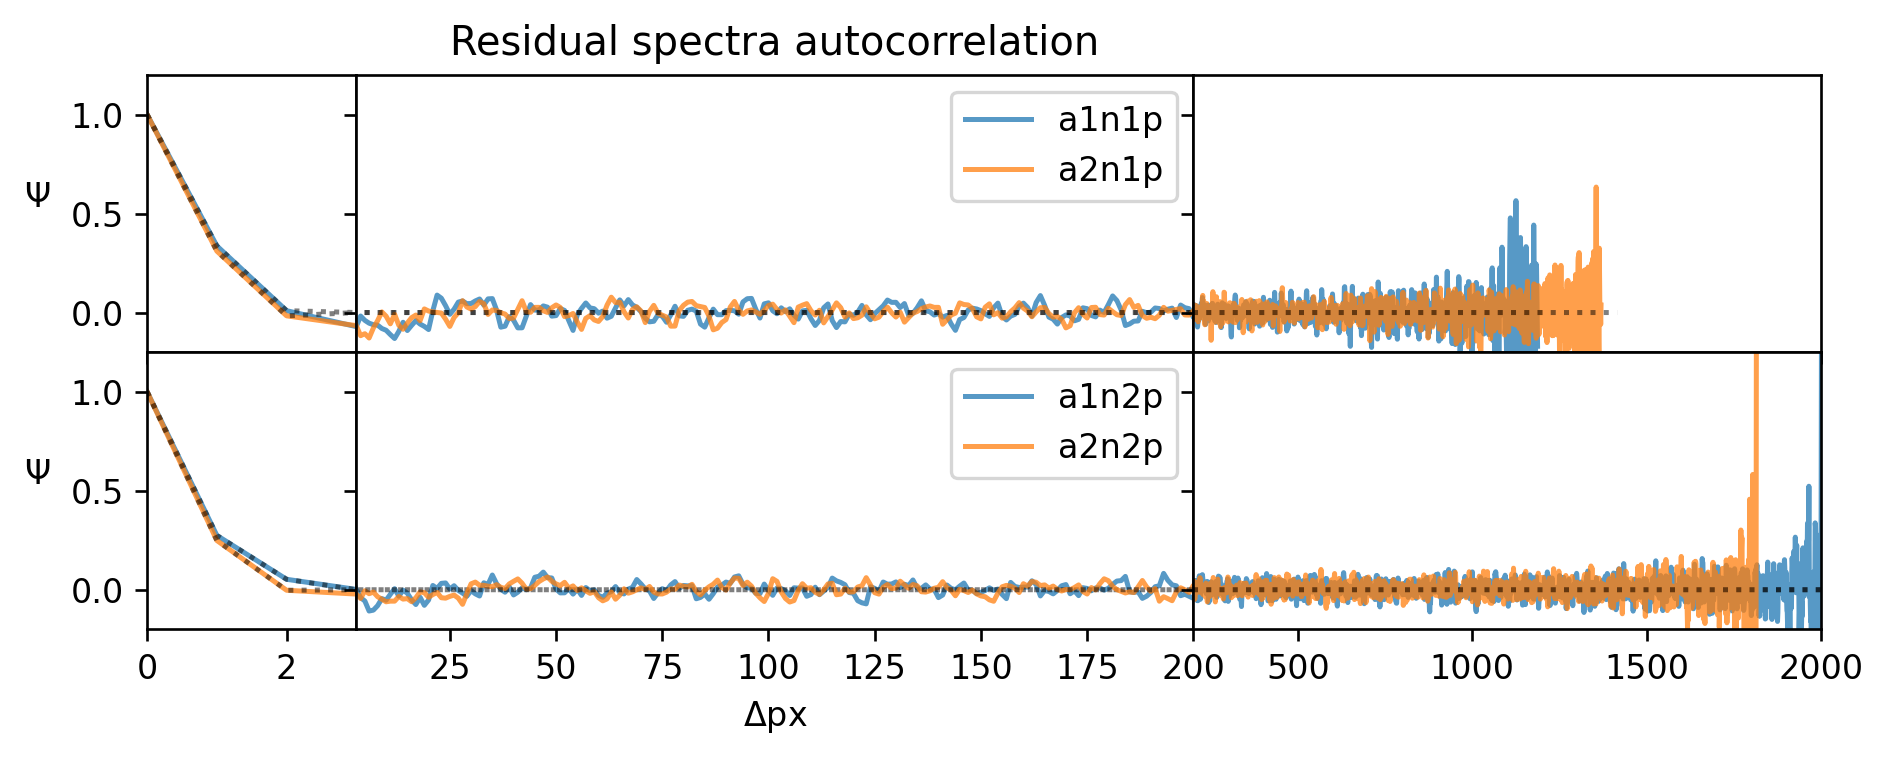

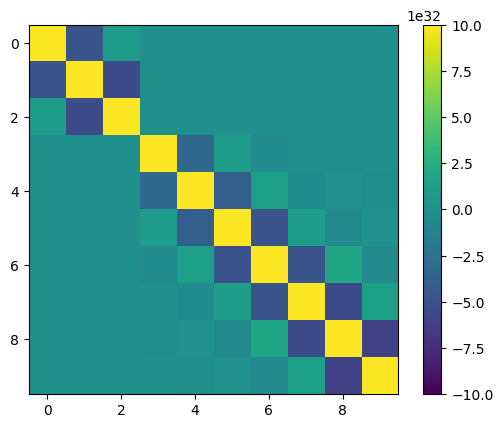

In [39]:
fig,ax = plt.subplots(2,3,figsize=(9,3),dpi=240,gridspec_kw={'width_ratios':[1,4,3]},sharey=True,sharex='col')

leg1 = []
leg2 = []
for i in range(3):
    for band in ['a1n1p','a2n1p']:
        l, = ax[0,i].plot(corrs[band],alpha=0.75)
        ax[0,i].plot(models[band],'k:',alpha=0.5)
        leg1.append(l)

    for band in ['a1n2p','a2n2p']:
        l, = ax[1,i].plot(corrs[band],alpha=0.75)
        ax[1,i].plot(models[band],'k:',alpha=0.5)
        leg2.append(l)
    
ax[0,0].set_xlim([0,3])
ax[0,1].set_xlim([3,200])
ax[0,2].set_xlim([200,2000])

ax[0,0].set_ylim([-.2,1.2])

plt.subplots_adjust(wspace=0)
ax[0,1].set_title('Residual spectra autocorrelation')
ax[0,1].legend(leg1,['a1n1p','a2n1p'],bbox_to_anchor=[1,1,0,0],loc='upper right')
ax[1,1].legend(leg2,['a1n2p','a2n2p'],bbox_to_anchor=[1,1,0,0],loc='upper right')
ax[1,1].set_xlabel(r'$\Delta$px')

ax[1,0].set_ylabel(r'$\Psi$',rotation=0,labelpad=10)
ax[0,0].set_ylabel(r'$\Psi$',rotation=0,labelpad=10)

plt.subplots_adjust(hspace=0)
plt.show()

plt.imshow(inverses['a2n2p'][:10,:10],vmin=-1e33,vmax=1e33,interpolation='nearest')
plt.colorbar()

In [40]:
[print(inverses[k].shape) for k in inverses.keys()]

print((eri51b.fluxdict['a1n1p'].shape,
eri51b.fluxdict['a1n2p'].shape,
eri51b.fluxdict['a2n1p'].shape,
eri51b.fluxdict['a2n2p'].shape))

np.sum(np.isnan(eri51b.fluxdict['a1n2p']))

(1154, 1154)
(1945, 1945)
(1322, 1322)
(1777, 1777)
((1154,), (1945,), (1322,), (1777,))


0

In [348]:
Teffs = [650,675,700,725,750,775,800,825,850]
loggs = [3.25,3.375,3.5,3.625,3.75,3.875,4.]
MHs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #[0,0.25,0.5,0.6,0.7,0.85,1.0]
COs = [0.229,0.3435,0.458,0.5725,0.687]
logKzzs = [2,2.5,3,3.5,4,4.5]
param_list = [Teffs,loggs,MHs,COs,logKzzs]
param_list

[[650, 675, 700, 725, 750, 775, 800, 825, 850],
 [3.25, 3.375, 3.5, 3.625, 3.75, 3.875, 4.0],
 [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 [0.229, 0.3435, 0.458, 0.5725, 0.687],
 [2, 2.5, 3, 3.5, 4, 4.5]]

In [349]:
#param_list = list(t100.points.values())
shape = tuple([len(l) for l in param_list])
npoints = np.prod(shape)
print(shape,npoints)
param_outer_product = np.array(np.meshgrid(*[list(l) for l in param_list])).T.reshape(npoints,len(shape))
np.set_printoptions(precision=3,suppress=True)
param_outer_product[-10::]

(9, 7, 11, 5, 6) 20790


array([[825.   ,   3.75 ,   1.   ,   0.687,   4.5  ],
       [825.   ,   3.875,   1.   ,   0.687,   4.5  ],
       [825.   ,   4.   ,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.25 ,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.375,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.5  ,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.625,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.75 ,   1.   ,   0.687,   4.5  ],
       [850.   ,   3.875,   1.   ,   0.687,   4.5  ],
       [850.   ,   4.   ,   1.   ,   0.687,   4.5  ]])

In [350]:
radii = np.linspace(1.26,1.5,13) #np.logspace(-0.125,0.125,51)
ehats = np.linspace(1.66,1.8,8)
fholes = np.linspace(0.2,0.7,11)
radii,ehats,fholes,np.prod([len(radii),len(ehats),len(fholes)])

(array([1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46,
        1.48, 1.5 ]),
 array([1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 ]),
 array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ]),
 1144)

In [351]:
inverses.keys()

dict_keys(['a1n1p', 'a1n2p', 'a2n1p', 'a2n2p'])

In [352]:
d_star = 29.4
pc = 3.086e16 #m
Rjup = 7.1492e7 #m or 6.995e7

def calc_chi2(cdict,fdict,obs_spectra,Rplanet,ehat,fhole,verbose=False):
    d2f = (Rplanet*Rjup/d_star/pc)**2
    #chi2 = 0
    chi2d = {}
    for band in ['J','H','K1','K2']:
        #covariant chi2
        print(band) if verbose else None
        
        #y = ydict[band]
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        Cinv = obs_spectra.Cinv_dict[band]
        v = d2f*y - flux
        chi2band = np.linalg.multi_dot([v.T,Cinv,v])
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band

    for band in ['L','M','F410M','F430M','F460M']:
        #photometric chi2
        print(band) if verbose else None
        
        #y = ydict[band]
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        err = obs_spectra.errordict[band]
        v = d2f*y - flux
        chi2band = (v/err)**2
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band

    for band in FSkeys:
        #ordinary chi2
        print(band) if verbose else None
        #y = ydict[band]
        c = cdict[band]
        f = fdict[band]
        y = (1-fhole)*c + fhole*f
        
        flux = obs_spectra.fluxdict[band]
        err = obs_spectra.errordict[band]

        #including hpf on spectra
        wave = obs_spectra.wavedict[band]
        node_key = 'nrs1' if 'n1' in band else 'nrs2'
        x_nodes = fs_nodes[node_key] #np.linspace(np.nanmin(wave), np.nanmax(wave), 60) #####
        hpf_y, _ = filter_spec_with_spline(wave,y,x_nodes=x_nodes)
        
        v = d2f*hpf_y - flux

        Cinv = inverses[band]
        chi2band = np.linalg.multi_dot([v.T,Cinv/ehat**2,v])
        
        #chi2band = np.sum((v/(ehat*err))**2)
        
        print(chi2band) if verbose else None
        #chi2 += chi2band
        chi2d[band] = chi2band
        
    return chi2d

def chi2(index):
    rprint(index)
    teff, logg, mh, co, logkzz = param_outer_product[index]
    
    cloudy100 = c100([teff, logg, mh, co, logkzz])[0]
    cloudy2700 = c2700([teff, logg, mh, co, logkzz])[0]
    cloudfree100 = f100([teff, logg, mh, co, logkzz])[0]
    cloudfree2700 = f2700([teff, logg, mh, co, logkzz])[0]

    cdict = {}
    fdict = {}
    
    for band in list(eri51b.wavedict.keys())[:4]:
        #rprint(band)
        wave = eri51b.wavedict[band]
        R = eri51b.Rdict[band]

        #trim f and w to range based on wave and R
        w = c100.wavelength
        wmin, wmax = np.min(wave),np.max(wave)
        delta_lambda_min = wmin/R
        delta_lambda_max = wmax/R
        lw, rw = wmin - delta_lambda_min*2, wmax + delta_lambda_max*2    
        trimbool = np.logical_and((w>lw),(w<rw))
        trimw = w[trimbool]

        trimc = cloudy100[trimbool]
        broad_c = broaden(trimw,trimc,R=R)
        c = np.interp(wave,trimw,broad_c)
        cdict[band] = c

        trimf = cloudfree100[trimbool]
        broad_f = broaden(trimw,trimf,R=R)
        f = np.interp(wave,trimw,broad_f)
        fdict[band] = f

    for band in list(eri51b.wavedict.keys())[4:-4]:
        #rprint(band)
        wave = eri51b.wavedict[band]
        R = eri51b.Rdict[band]
        filter_name = filter_dictionary[band]
        synph = SyntheticPhotometry(filter_name)
        #bandflux, _ = synph.spectrum_to_flux(t100.wavelength,flux100)
        #ydict[band] = bandflux
        
        c_bandflux, _ = synph.spectrum_to_flux(c100.wavelength,cloudy100)
        cdict[band] = c_bandflux

        f_bandflux, _ = synph.spectrum_to_flux(f100.wavelength,cloudfree100)
        fdict[band] = f_bandflux
    
    for band in list(eri51b.wavedict.keys())[-4:]:
        #rprint(band)
        wave = eri51b.wavedict[band]
        #y = np.interp(wave,t2700.wavelength,flux2700)
        #ydict[band] = y
        c = np.interp(wave,c2700.wavelength,cloudy2700)
        cdict[band] = c

        f = np.interp(wave,f2700.wavelength,cloudfree2700)
        fdict[band] = f
    
    chi2es = {}
    for r,Rplanet in enumerate(radii):
        for e,ehat in enumerate(ehats):
            for fh,fhole in enumerate(fholes):
                rprint('{},{},{}'.format(r,e,fh))
                chi2e = calc_chi2(cdict, fdict, eri51b, Rplanet, ehat, fhole, verbose=False)
                chi2es[(r,e,fh)] = chi2e
            
    np.save('/user/amadurowicz/51 Eri/chi2s/custom_N136_v3_2/{}.npy'.format(str(index).zfill(5)),chi2es)

In [50]:
t0 = time.time()
chi2(0)
t1 = time.time()
t1-t0

12,7,10

139.56366777420044

In [58]:
(t1-t0)*npoints/64/3600

12.593440334312618

In [ ]:
from multiprocess import Pool

with Pool(64) as pool:
    pool.map(chi2,range(npoints))

6,4,30

In [368]:
new_shape = tuple(list(shape) + [len(radii),len(ehats),len(fholes)])

In [46]:
import glob
outs = sorted(glob.glob('/user/amadurowicz/51 Eri/chi2s/custom_N136_v3_2/*.npy'))

In [353]:
outs[:1],len(outs),npoints

(['/user/amadurowicz/51 Eri/chi2s/custom_N136_v3_2/00000.npy'], 20790, 20790)

In [354]:
index_list = [list(range(i)) for i in shape]
indices = np.array(np.meshgrid(*[list(l) for l in index_list])).T.reshape(npoints,len(shape))

test_bools = []
for testi in range(npoints):
    a,b,c,d,e = indices[testi]
    test_bool = np.all(param_outer_product[testi]==[param_list[0][a],param_list[1][b],param_list[2][c],param_list[3][d],param_list[4][e]])
    test_bools.append(test_bool)
np.all(test_bools)

True

In [49]:
#new_shape = tuple(list(shape) + [len(radii),len(ehats),len(fholes)])
#chi2_hypercube2 = np.zeros(new_shape)
#chi2_no_nirspec_hc2 = np.zeros(new_shape)
#chi2_nirspec_only_hc2 = np.zeros(new_shape)
#like_rescale_hypercube2 = np.empty(new_shape)
#chi2_hypercube2.shape,new_shape



chi2_GPI_hc2 = np.zeros(new_shape)
chi2_phot_hc2 = np.zeros(new_shape)
chi2_nirspec_hc2 = np.zeros(new_shape)

like_rescale_hypercube2 = np.zeros(new_shape)
#prior_hypercube1 = np.zeros(new_shape)

like_rescale_hypercube2.shape,new_shape

((9, 7, 11, 5, 6, 13, 8, 11), (9, 7, 11, 5, 6, 13, 8, 11))

In [50]:
#for i, o in enumerate(outs):
#    chi2e = np.load(o,allow_pickle=True).item()
#    
#    a,b,c,d,e = indices[i]
#    rprint('{},{},{},{},{}'.format(a,b,c,d,e))
#
#    for k in chi2e.keys():
#        chi2d = chi2e[k]
#        chi2_hypercube2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[:])
#        chi2_no_nirspec_hc2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[:-4])
#        chi2_nirspec_only_hc2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[-4:])
#        like_rescale_hypercube2[a,b,c,d,e,k[0],k[1],k[2]] = 1/ehats[k[1]]


for i, o in enumerate(outs):
    chi2e = np.load(o,allow_pickle=True).item()
    
    a,b,c,d,e = indices[i]
    rprint('{},{},{},{},{} _____'.format(a,b,c,d,e))

    for k in chi2e.keys():
        chi2d = chi2e[k]
        
        chi2_GPI_hc2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[:4])
        chi2_phot_hc2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[4:-4])
        chi2_nirspec_hc2[a,b,c,d,e,k[0],k[1],k[2]] = sum(list(chi2d.values())[-4:])
        like_rescale_hypercube2[a,b,c,d,e,k[0],k[1],k[2]] = 1/ehats[k[1]]

8,6,10,4,5 _____

In [51]:
#total_nirspec_N = 0
#for k in FSkeys:
#    total_nirspec_N += len(eri51b.wavedict[k])
#print(total_nirspec_N)
#logLike_hypercube2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*chi2_hypercube2
#logLike_no_nirspec_hc2 = -(1/2.)*chi2_no_nirspec_hc2
#logLike_nirspec_only_hc2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*chi2_nirspec_only_hc2

total_nirspec_N = 0
for k in FSkeys:
    total_nirspec_N += len(eri51b.wavedict[k])
print(total_nirspec_N)

chi2_hypercube2 = chi2_GPI_hc2 + chi2_phot_hc2 + chi2_nirspec_hc2
logLike_hypercube2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*chi2_hypercube2

logLike_GPI_hc2 = -(1/2.)*chi2_GPI_hc2
logLike_phot_hc2 = -(1/2.)*chi2_phot_hc2
logLike_nirspec_hc2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*chi2_nirspec_hc2

logLike_GPIphot_hc2 = -(1/2.)*(chi2_GPI_hc2+chi2_phot_hc2)
logLike_GPInirspec_hc2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*(chi2_GPI_hc2+chi2_nirspec_hc2)
logLike_photnirspec_hc2 = total_nirspec_N*np.log(like_rescale_hypercube2)-(1/2.)*(chi2_phot_hc2+chi2_nirspec_hc2)

6198


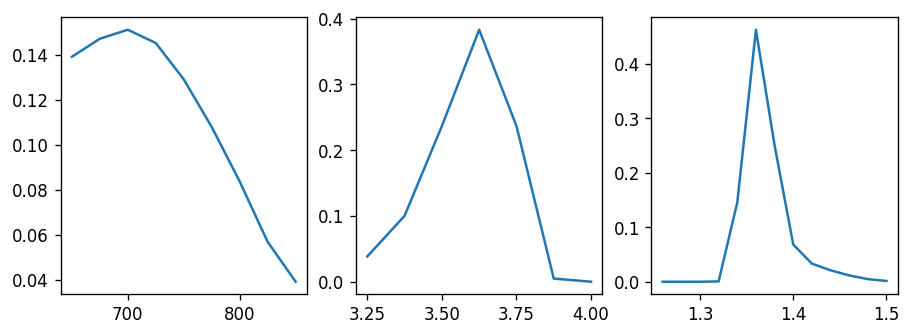

In [52]:
Teff_prior = DBE.eval_prior_function(name,3,param_list[0],rtol=1e-1) #Teff
logg_prior = DBE.eval_prior_function(name,4,param_list[1],rtol=1e-3) #logg
radius_prior = DBE.eval_prior_function(name,5,radii,rtol=1e-3)       #radii

Teff_phc = Teff_prior.reshape((9,1,1,1,1,1,1,1))
logg_phc = logg_prior.reshape((1,7,1,1,1,1,1,1))
radius_phc = radius_prior.reshape((1,1,1,1,1,13,1,1))

prior_hypercube2 = Teff_phc*logg_phc*radius_phc

fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=120)
ax[0].plot(param_list[0],Teff_prior)
ax[1].plot(param_list[1],logg_prior)
ax[2].plot(radii,radius_prior)
plt.show()

In [355]:
prior_hypercube2.shape

(9, 7, 1, 1, 1, 13, 1, 1)

In [356]:
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])
    # if you want it in a list of indices . . . 
    # return np.array(np.unravel_index(idx, arr.shape))[:, range(k)].transpose().tolist()

k = 1
a_,b_,c_,d_,e_,g_,h_,i_ = get_indices_of_k_smallest(-logLike_hypercube2-np.log10(prior_hypercube2),k)
a, b, c, d, e, g, h, i = a_[-1],b_[-1],c_[-1],d_[-1],e_[-1],g_[-1],h_[-1],i_[-1]

-logLike_hypercube2[a, b, c, d, e, g, h, i]

/tmp/ipykernel_3564295/775423167.py:8: RuntimeWarning: divide by zero encountered in log10
  a_,b_,c_,d_,e_,g_,h_,i_ = get_indices_of_k_smallest(-logLike_hypercube2-np.log10(prior_hypercube2),k)


6587.657180873486

In [575]:
#chi2e = np.load(outs[np.where(np.all([a,b,c,d,e] == indices,axis=1))[0][0]],allow_pickle=True).item()
#chi2d = chi2e[(f,g)]
#chi2d, sum(list(chi2d.values())[:-4])/2.,sum(list(chi2d.values())[:])/2.-total_nirspec_N*np.log(1/ehats[g])

({'J': 63.049677148063715,
  'H': 44.35506204299931,
  'K1': 45.51356416859984,
  'K2': 14.076179875313176,
  'L': 3.3214773991507522,
  'M': 0.379619924500535,
  'F410M': 0.8612534609391771,
  'F430M': 9.44615200610006,
  'F460M': 1.129456176996272,
  'a1n1p': 1218.4087577858754,
  'a1n2p': 1980.7139263610995,
  'a2n1p': 1146.7734408492634,
  'a2n2p': 1824.013090315552},
 91.06622110133141,
 6466.446613593747)

In [576]:
#chi2e = np.load(outs[np.where(np.all([a,b,c,d,e] == indices,axis=1))[0][0]],allow_pickle=True).item()
#chi2d = chi2e[(f,g)]
#chi2d, sum(list(chi2d.values())[:-4])/2.,sum(list(chi2d.values())[:])/2.-total_nirspec_N*np.log(1/ehats[g])

({'J': 63.049677148063715,
  'H': 44.35506204299931,
  'K1': 45.51356416859984,
  'K2': 14.076179875313176,
  'L': 3.3214773991507522,
  'M': 0.379619924500535,
  'F410M': 0.8612534609391771,
  'F430M': 9.44615200610006,
  'F460M': 1.129456176996272,
  'a1n1p': 1218.4087577858754,
  'a1n2p': 1980.7139263610995,
  'a2n1p': 1146.7734408492634,
  'a2n2p': 1824.013090315552},
 91.06622110133141,
 6466.446613593747)

In [357]:
Rbest= radii[g]
ehatb = ehats[h]
fholeb = fholes[i]

#fbest = create(grid_logkzzs[a],grid_teffs[b],grid_gs[c],grid_mhs[d],grid_cos[e])
#w,f = load(fbest)
best_params = [param_list[0][a],param_list[1][b],param_list[2][c],param_list[3][d],param_list[4][e]]
print(best_params)
c100best = c100(best_params)[0]
c2700best = c2700(best_params)[0]
f100best = f100(best_params)[0]
f2700best = f2700(best_params)[0]
y100b = (1-fholeb)*c100best + (fholeb)*f100best
y2700b = (1-fholeb)*c2700best + (fholeb)*f2700best

d2fb = (Rbest*Rjup/d_star/pc)**2
Rbest,ehatb,fholeb,d2fb

[800, 3.75, 0.7, 0.458, 3]


(1.36, 1.74, 0.3, 1.1484344345049732e-20)

In [358]:
all_nodes = fs_nodes['all']
hpf_y, _ = filter_spec_with_spline(c2700.wavelength,y2700b*d2fb,x_nodes=all_nodes)

In [359]:
from breads.atm_utils import miniRGI

from species.phot.syn_phot import SyntheticPhotometry
BS = ['JWST/NIRCam.F410M','JWST/NIRCam.F430M','JWST/NIRCam.F460M','KECK/NIRC2.Lp','KECK/NIRC2.Ms']#,'JWST/NIRCam.F444W']

JWST/NIRCam.F410M
JWST/NIRCam.F410M 2.4221211803951116e-17
JWST/NIRCam.F430M
JWST/NIRCam.F430M 1.5260188478487413e-17
JWST/NIRCam.F460M
JWST/NIRCam.F460M 4.360612672920356e-18
KECK/NIRC2.Lp
KECK/NIRC2.Lp 1.7685472722474875e-17
KECK/NIRC2.Ms
KECK/NIRC2.Ms 4.395015518402575e-18
F430M 6.805990822018511e-18
F460M 5.53093217674255e-18


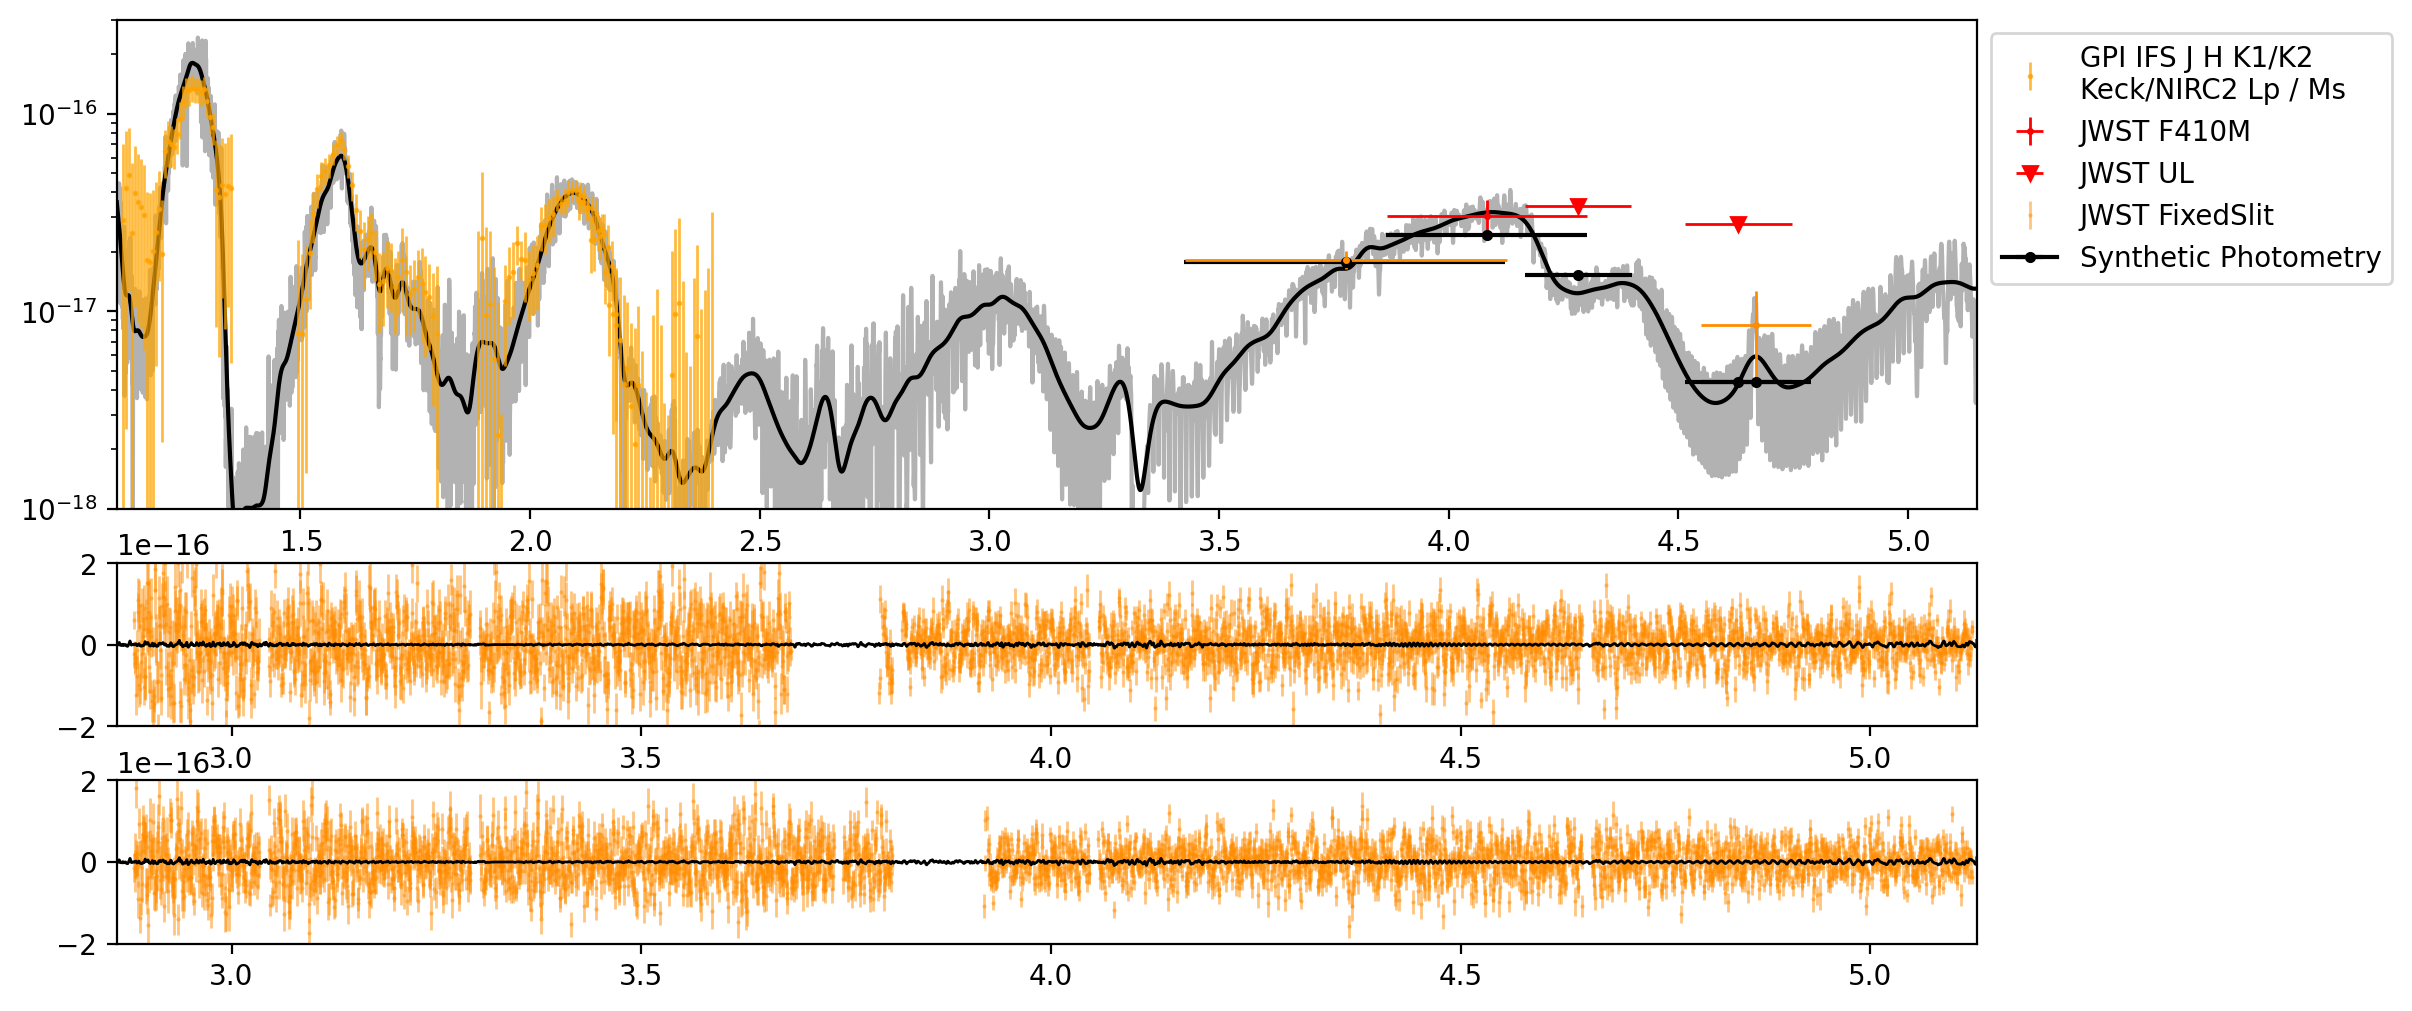

In [360]:
fig,ax = plt.subplots(3,1,figsize=(12,6),dpi=200,sharex=False,sharey=False,gridspec_kw={'height_ratios':[3,1,1]})

ax[0].plot(c100.wavelength,y100b*d2fb,color='k',alpha=1)
ax[0].plot(c100.wavelength,y2700b*d2fb,color='k',alpha=0.3)

ax[0].set_yscale('log')
ax[1].plot(c2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)
ax[2].plot(c2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)

errbars = []

for syn_band in BS:
    print(syn_band)
    synph = SyntheticPhotometry(syn_band)
    bandflux, _ = synph.spectrum_to_flux(c2700.wavelength,y2700b*d2fb) #synph.spectrum_to_flux(mrgi.wavelength,rescaled_best_fit_flux)

    wlr = synph.wavel_range
    Npts = 1000
    w = np.linspace(wlr[0],wlr[1],Npts)
    T = synph.filter_interp(w)
    cross_boolean = abs(T-0.5*np.max(T))<.1
    lTh,rTh = np.mean(w[:Npts//2][cross_boolean[:Npts//2]]),np.mean(w[Npts//2:][cross_boolean[Npts//2:]])
    meanw = np.sum(w*T)/np.sum(T) #np.mean(synph.wavel_range)
    xerr = np.array([meanw-lTh,rTh-meanw]).reshape(2,1)
    #xerr = np.abs(synph.wavel_range - np.mean(synph.wavel_range)).reshape(2,1)
    errbar = ax[0].errorbar(meanw,bandflux,xerr=xerr,color='k',marker='.')
    print(syn_band,bandflux)
    errbars.append(errbar)

xbs = {'F410M':[3.865, 4.301], #3.776356,4.404841],
       'F430M':[4.167, 4.398], #4.122768,4.44487],
       'F460M':[4.515, 4.747], #4.465264,4.814641],
       'L':[3.426, 4.126], #3.334919,4.220463],
       'M':[4.549, 4.790]} #4.496604,4.868843]}

for band in eri51b.wavedict.keys():
    wave = eri51b.wavedict[band]
    y = eri51b.fluxdict[band]
    e = eri51b.errordict[band]
    if band in ['J','H','K1','K2']:
        errbar = ax[0].errorbar(wave,y,e,linestyle='none',marker='.',color='orange',markersize=2,linewidth=1,alpha=.75,markerfacecolor='darkorange')

    elif band in ['F410M','L','M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        color = 'red' if 'F' in band else 'darkorange'
        errbar = ax[0].errorbar(wave,y,e,xerr=xerr,linestyle='none',marker='.',color=color,markersize=3,linewidth=1,alpha=1)
    elif band in ['F430M','F460M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        print(band,e)
        errbar = ax[0].errorbar(wave,5*e,xerr=xerr,linestyle='none',marker='v',color='red',markersize=5,linewidth=1,alpha=1)
    elif band in FSkeys:
        axi = 1 if 'a1' in band else 2
        errbar = ax[axi].errorbar(wave,y,e,linestyle='none',marker='.',color='darkorange',markersize=1,linewidth=1,alpha=0.5)
    errbars.append(errbar)
    
ax[0].set_xlim([1.1,5.15])
ax[0].set_xscale('linear')
ax[0].set_xticks([1.5,2,2.5,3,3.5,4,4.5,5])
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax[0].set_ylim([-0.5e-16,2.5e-16])
ax[0].set_ylim([1e-18,3e-16])
ax[0].legend([errbars[0+len(BS)],errbars[6+len(BS)],errbars[7+len(BS)],errbars[-1],errbars[0]],
             ['GPI IFS J H K1/K2\nKeck/NIRC2 Lp / Ms',
            'JWST F410M','JWST UL','JWST FixedSlit','Synthetic Photometry'],bbox_to_anchor=[1,0,1,1],loc='upper left')

#nrsw = eri51b.wavedict['a1n2p']
#ax[1].set_xlim([np.min(nrsw),np.max(nrsw)])
y = 2e-16
ax[1].set_ylim([-y,y])
ax[2].set_ylim([-y,y])

ax[1].set_xlim([2.86,5.13])
ax[2].set_xlim([2.86,5.13])

plt.savefig('atm.png')
plt.show()

In [346]:
1.5260188478487413e-17/6.805990822018511e-18, 4.360612672920356e-18/5.53093217674255e-18

(2.24217000544846, 0.7884046546903319)

JWST/NIRCam.F410M
JWST/NIRCam.F430M
JWST/NIRCam.F460M
KECK/NIRC2.Lp
KECK/NIRC2.Ms


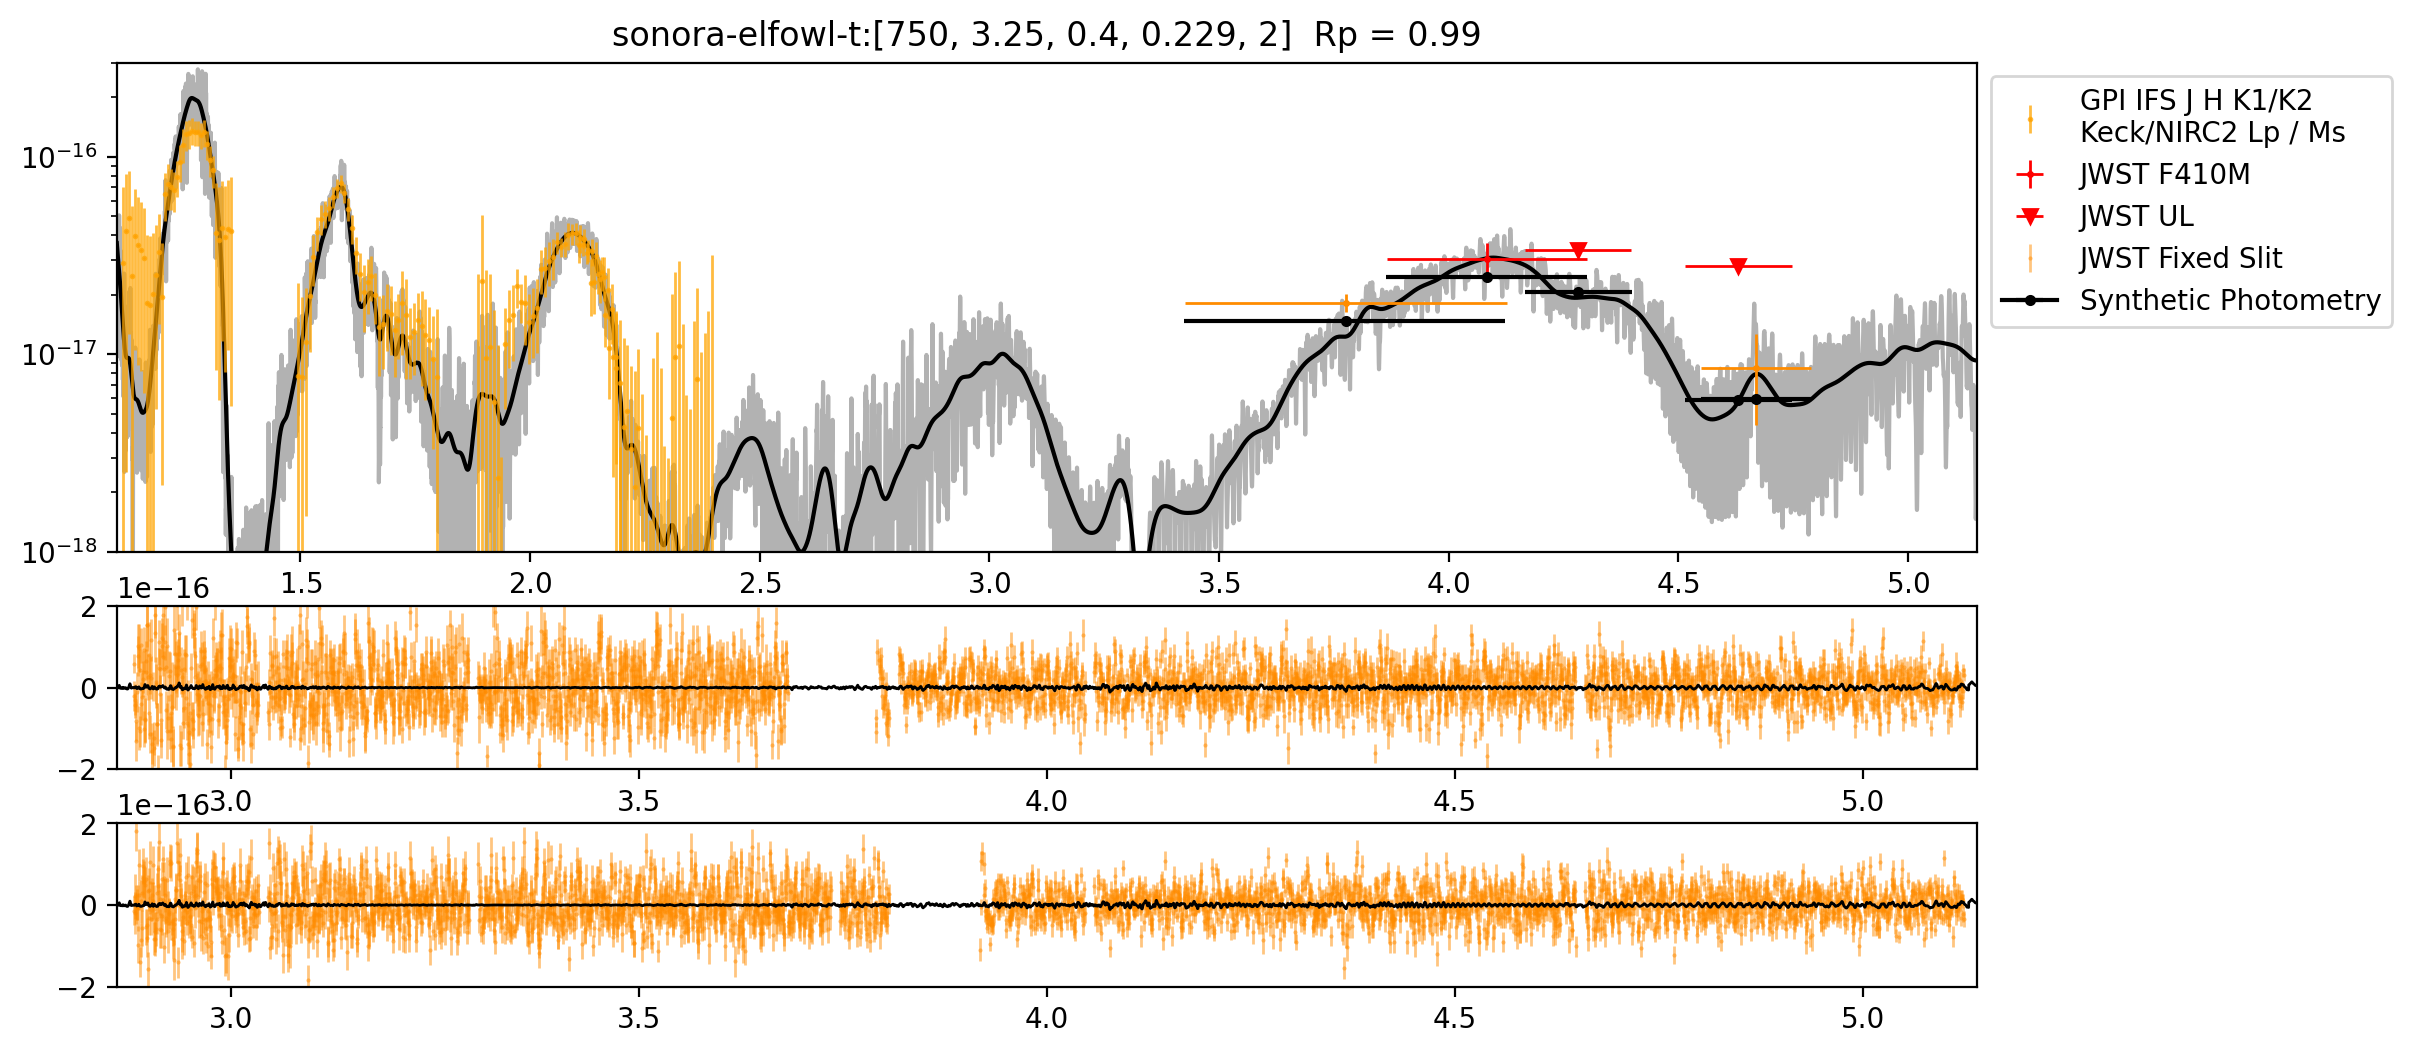

In [704]:
fig,ax = plt.subplots(3,1,figsize=(12,6),dpi=200,sharex=False,sharey=False,gridspec_kw={'height_ratios':[3,1,1]})

ax[0].plot(t100.wavelength,f100best*d2fb,color='k',alpha=1)
ax[0].plot(t100.wavelength,f2700best*d2fb,color='k',alpha=0.3)

ax[0].set_yscale('log')
ax[1].plot(t2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)
ax[2].plot(t2700.wavelength,hpf_y,color='k',zorder=10,linewidth=1)

errbars = []

for syn_band in BS:
    print(syn_band)
    synph = SyntheticPhotometry(syn_band)
    bandflux, _ = synph.spectrum_to_flux(mrgi.wavelength,rescaled_best_fit_flux)

    wlr = synph.wavel_range
    Npts = 1000
    w = np.linspace(wlr[0],wlr[1],Npts)
    T = synph.filter_interp(w)
    cross_boolean = abs(T-0.5*np.max(T))<.1
    lTh,rTh = np.mean(w[:Npts//2][cross_boolean[:Npts//2]]),np.mean(w[Npts//2:][cross_boolean[Npts//2:]])
    meanw = np.sum(w*T)/np.sum(T) #np.mean(synph.wavel_range)
    xerr = np.array([meanw-lTh,rTh-meanw]).reshape(2,1)
    #xerr = np.abs(synph.wavel_range - np.mean(synph.wavel_range)).reshape(2,1)
    errbar = ax[0].errorbar(meanw,bandflux,xerr=xerr,color='k',marker='.')
    errbars.append(errbar)

xbs = {'F410M':[3.865, 4.301], #3.776356,4.404841],
       'F430M':[4.167, 4.398], #4.122768,4.44487],
       'F460M':[4.515, 4.747], #4.465264,4.814641],
       'L':[3.426, 4.126], #3.334919,4.220463],
       'M':[4.549, 4.790]} #4.496604,4.868843]}

for band in eri51b.wavedict.keys():
    wave = eri51b.wavedict[band]
    y = eri51b.fluxdict[band]
    e = eri51b.errordict[band]
    if band in ['J','H','K1','K2']:
        errbar = ax[0].errorbar(wave,y,e,linestyle='none',marker='.',color='orange',markersize=2,linewidth=1,alpha=.75,markerfacecolor='darkorange')

    elif band in ['F410M','L','M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        color = 'red' if 'F' in band else 'darkorange'
        errbar = ax[0].errorbar(wave,y,e,xerr=xerr,linestyle='none',marker='.',color=color,markersize=3,linewidth=1,alpha=1)
    elif band in ['F430M','F460M']:
        xerr = abs(np.array(xbs[band]).reshape(2,1)-wave)
        errbar = ax[0].errorbar(wave,5*e,xerr=xerr,linestyle='none',marker='v',color='red',markersize=5,linewidth=1,alpha=1)
    elif band in FSkeys:
        axi = 1 if 'a1' in band else 2
        errbar = ax[axi].errorbar(wave,y,e,linestyle='none',marker='.',color='darkorange',markersize=1,linewidth=1,alpha=0.5)
    errbars.append(errbar)
    
ax[0].set_xlim([1.1,5.15])
ax[0].set_xscale('linear')
ax[0].set_xticks([1.5,2,2.5,3,3.5,4,4.5,5])
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax[0].set_ylim([-0.5e-16,2.5e-16])
ax[0].set_ylim([1e-18,3e-16])
ax[0].legend([errbars[0+len(BS)],errbars[6+len(BS)],errbars[7+len(BS)],errbars[-1],errbars[0]],
             ['GPI IFS J H K1/K2\nKeck/NIRC2 Lp / Ms',
            'JWST F410M','JWST UL','JWST Fixed Slit','Synthetic Photometry'],bbox_to_anchor=[1,0,1,1],loc='upper left')

#nrsw = eri51b.wavedict['a1n2p']
#ax[1].set_xlim([np.min(nrsw),np.max(nrsw)])
y = 2e-16
ax[1].set_ylim([-y,y])
ax[2].set_ylim([-y,y])

ax[1].set_xlim([2.86,5.14])
ax[2].set_xlim([2.86,5.14])
ax[0].set_title('{}:{}  Rp = {}'.format(mrgi.model_name,best_params,np.round(Rbest,2)))
plt.savefig('atm.png')
plt.show()

In [367]:
new_shape

(12, 10, 6, 4, 5, 21, 11, 21)

In [366]:
[len(p) for p in full_param_list]

[9, 7, 11, 5, 6, 13, 8, 11]

In [588]:
#t100.points

In [361]:
full_param_list = param_list+[list(radii),list(ehats),list(fholes)]
names = [r'T$_\mathrm{eff}$ (K)',r'$\log \frac{g}{\mathrm{cm}/\mathrm{s}^2}$',r'[M/H]',r'C/O',r'$\log \frac{K_\mathrm{zz}}{\mathrm{cm}^2/\mathrm{s}}$',r'R$_\mathrm{p}$ (R$_\mathrm{Jup}$)',r'$\hat{e}$',r'f$_\mathrm{hole}$']

In [369]:
from matplotlib import colors
cm = plt.get_cmap('cividis')
cmap = colors.ListedColormap([(0,0,0,0),cm(0.3),cm(0.6),cm(.9)])
bounds=[-1000,-6,-4,-2,0]
norm = colors.BoundaryNorm(bounds, cmap.N)

def HC2logMeanLike(logLike_hypercube,allaxes):
    LLmax = np.nanmax(logLike_hypercube)
    delta_LL = logLike_hypercube-LLmax
    Like_hypercube = np.exp(delta_LL)
    meanLike = np.nanmean(Like_hypercube,axis=tuple(allaxes))
    return np.log(meanLike)

def triangle(logLike_hypercube):
    fig, ax = plt.subplots(8,8,figsize=(12,12),dpi=240)
    diagonals = []
    ims = {}
    for i in range(8):
        for j in range(8):
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            allaxes = [0,1,2,3,4,5,6,7]
            if i < j:
                allaxes.remove(i)
                allaxes.remove(j)
                #print(allaxes)
                log_meanLike = HC2logMeanLike(logLike_hypercube,allaxes).T
                im = log_meanLike-np.max(log_meanLike)
                ax[j,i].imshow(im,aspect='auto',origin='lower',cmap=cmap,norm=norm)
                ims[(j,i)] = im
            elif i == j:
                allaxes.remove(i)
                log_meanLike = HC2logMeanLike(logLike_hypercube,allaxes)
                step = log_meanLike-np.max(log_meanLike)
                step[step==-np.inf] = -16 #for plot continuity

                xmod = [0] + full_param_list[i] + []
                ax[j,i].step(full_param_list[i],step,'k',where='mid')

                diagonals.append(step)
                ax[j,i].set_yticks([-6,-4,-2,0])
                ax[j,i].set_ylim([-6,0])

                #1sigma percentiles and title
                p = np.exp(step)
                p /= np.sum(p)
                mid_val, left_err, right_err = get_err_from_posterior(full_param_list[i],p)
                ax[j,i].axvline(x=mid_val-left_err,color='r',linestyle=':')
                ax[j,i].axvline(x=mid_val,color='r',linestyle='-')
                ax[j,i].axvline(x=mid_val+right_err,color='r',linestyle=':')
                
                ax[j,i].set_title(str(names[i])+' = '+str(np.round(mid_val,3))+r' $^{+'+str(np.round(right_err,3))+r'}_{-'+str(np.round(left_err,3))+r'}$',fontsize=8)

                #match xlims
                half_pixel_size = (full_param_list[i][1] - full_param_list[i][0])/2.
                ax[j,i].set_xlim([full_param_list[i][0]-half_pixel_size,full_param_list[i][-1]+half_pixel_size])

                #extend step edges
                xmax = (full_param_list[i][0]- (full_param_list[i][0]-half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size))
                ax[j,i].axhline(y=step[0], xmax=xmax, color='k' )
                xmin = 1+ ((full_param_list[i][-1]- (full_param_list[i][-1]+half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size)))
                ax[j,i].axhline(y=step[-1], xmin=xmin, color='k' )
                #
            else:
                None
                ax[j,i].axis('off')
    
    rounds = [3,3,2,3,2,2,3,3]
    dss = [2,1,2,1,1,5,3,3]
    for i in range(0,7):
        ds = dss[i]
        ax[-1,i].set_xticks(range(new_shape[i])[::ds],np.round(full_param_list[i],rounds[i])[::ds],rotation=45)
        ax[-1,i].set_xlabel(names[i])
    ax[-1,7].set_xticks(full_param_list[7][::dss[7]],np.round(full_param_list[7],rounds[7])[::dss[7]],rotation=45)
    ax[-1,7].set_xlabel(names[7])
    for j in range(1,8):
        ds = dss[j]
        ax[j,0].set_yticks(range(new_shape[j])[::ds],np.round(full_param_list[j],rounds[j])[::ds])
        ax[j,0].set_ylabel(names[j],rotation=0,labelpad=25)

    ax[0,0].set_ylabel(r'$\log \mathcal{L}$',rotation=0, labelpad=25)
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.show()
    return ims, diagonals


/tmp/ipykernel_3564295/874804166.py:1: RuntimeWarning: divide by zero encountered in log10
  full_ims2, full_diag2 = triangle(logLike_hypercube2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


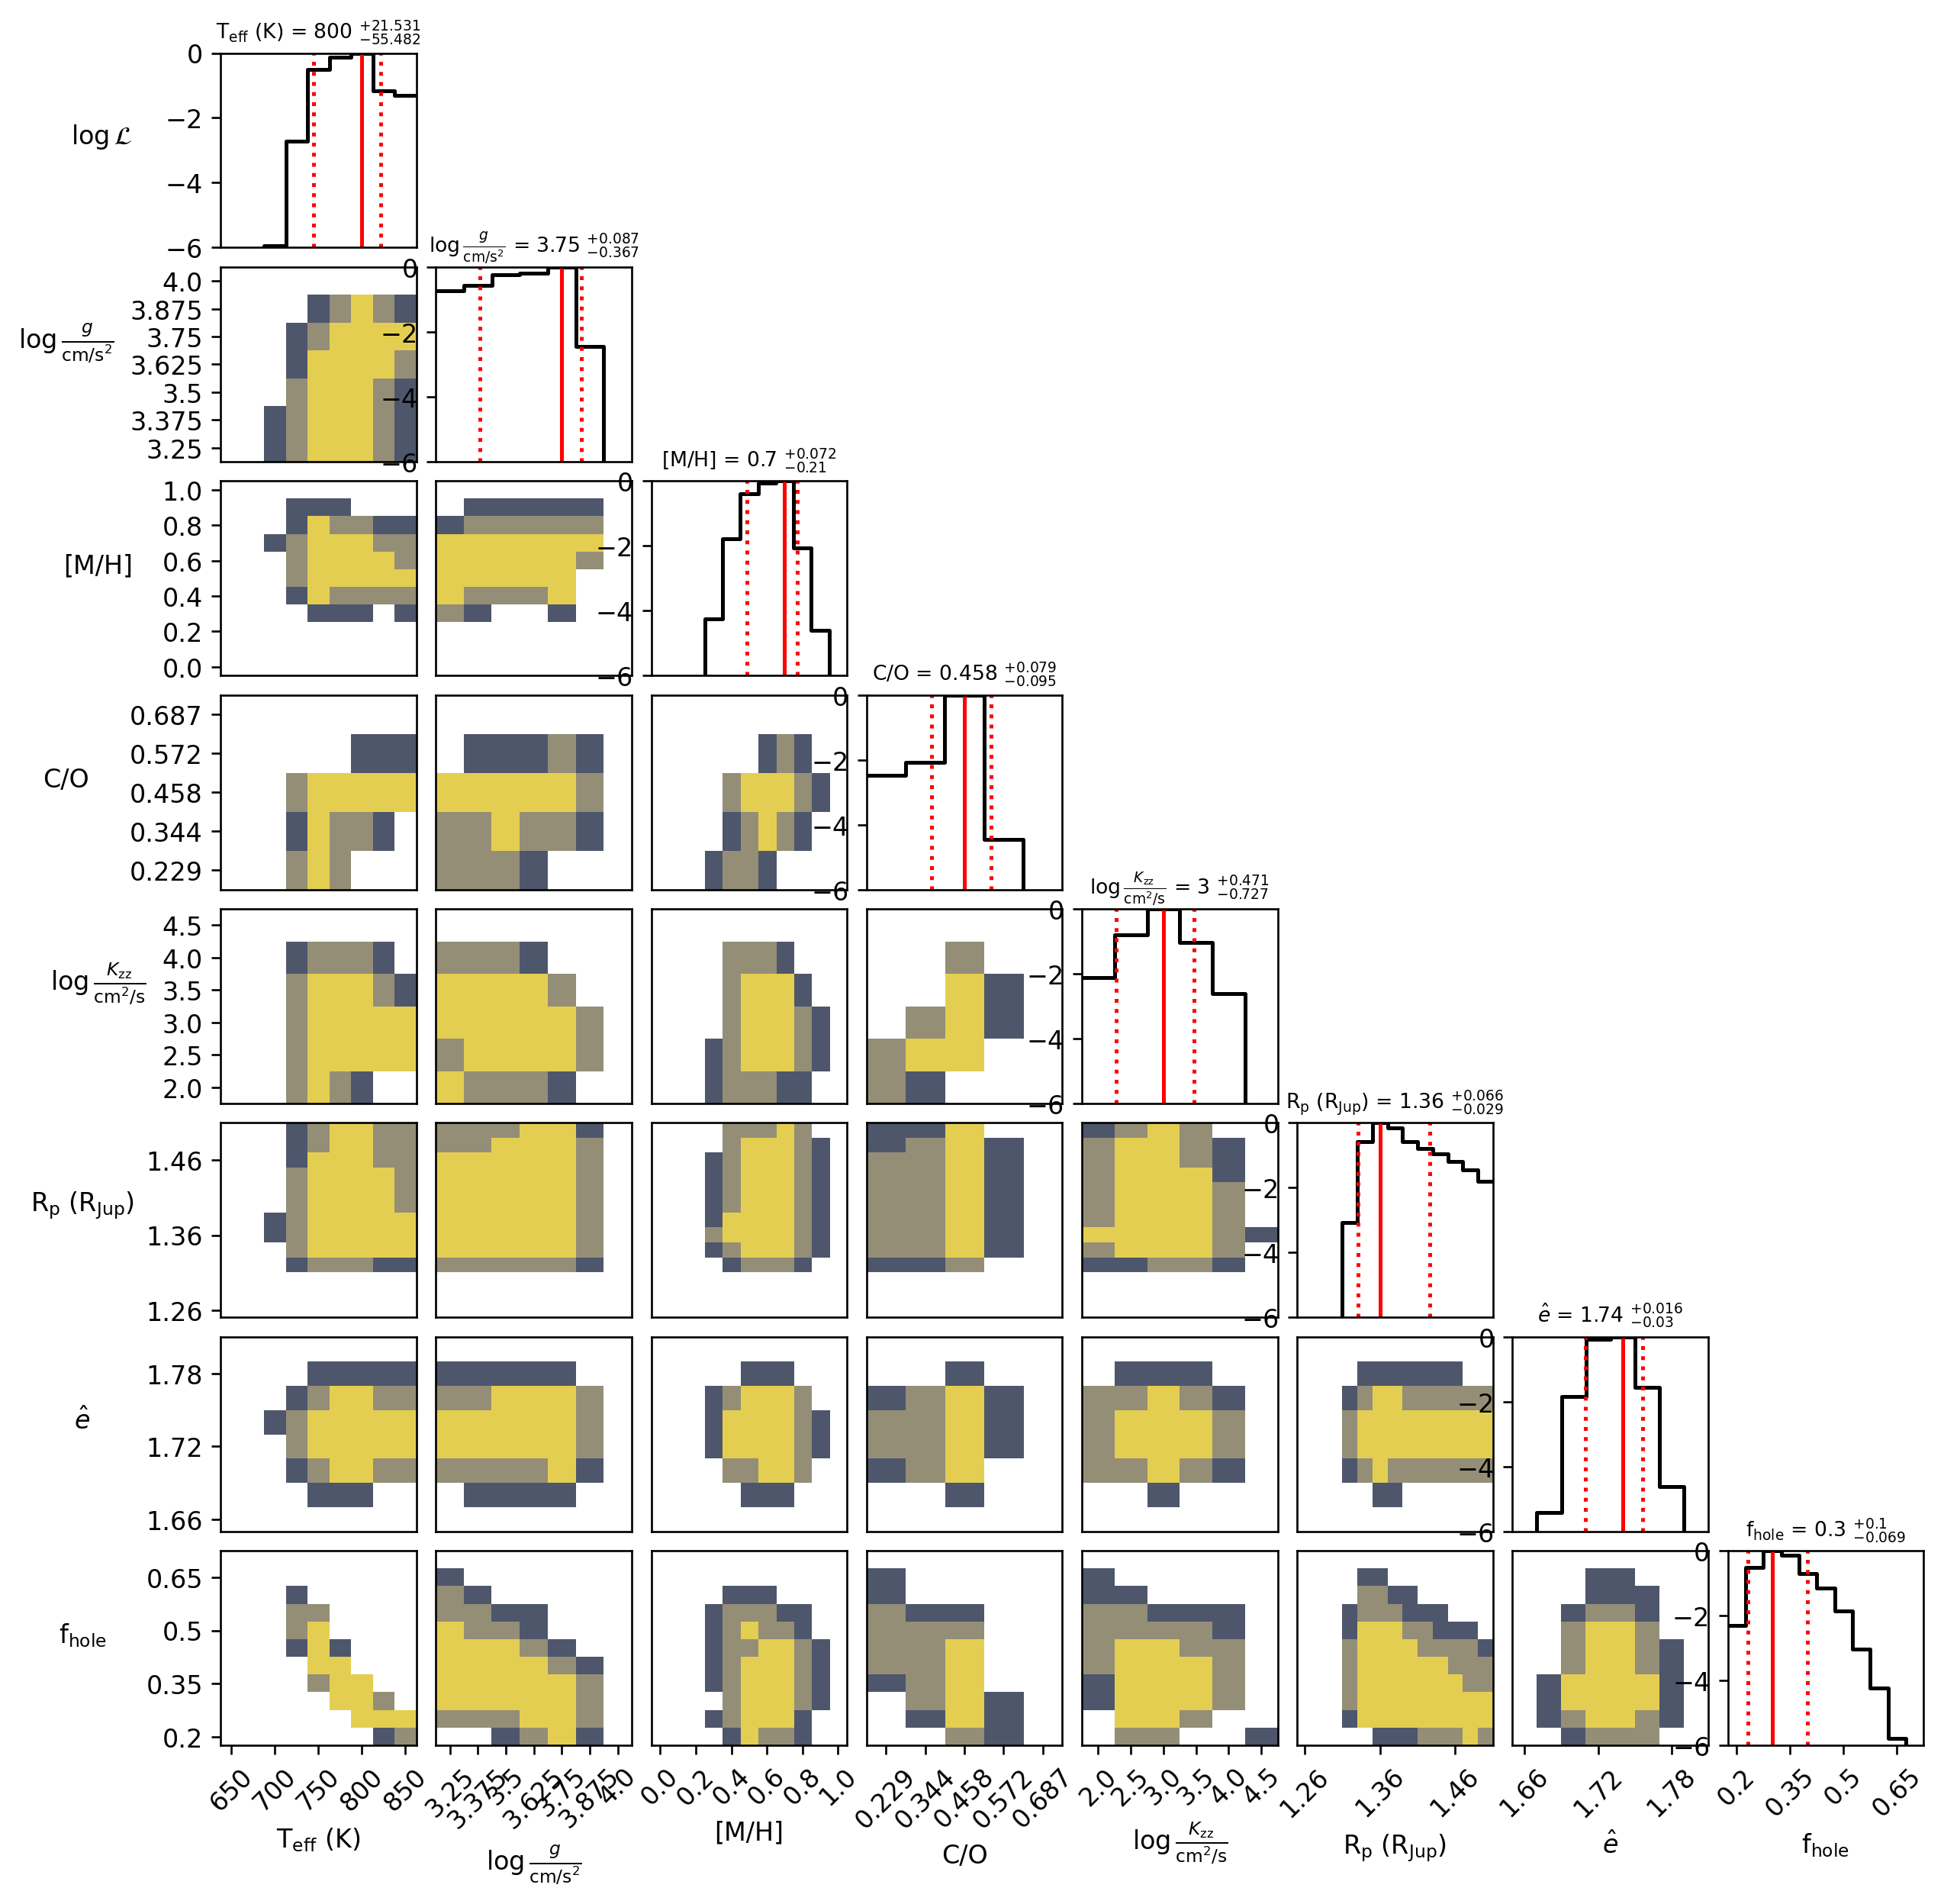

/tmp/ipykernel_3564295/874804166.py:3: RuntimeWarning: divide by zero encountered in log10
  GPI_ims2, GPI_diag2 = triangle(logLike_GPI_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


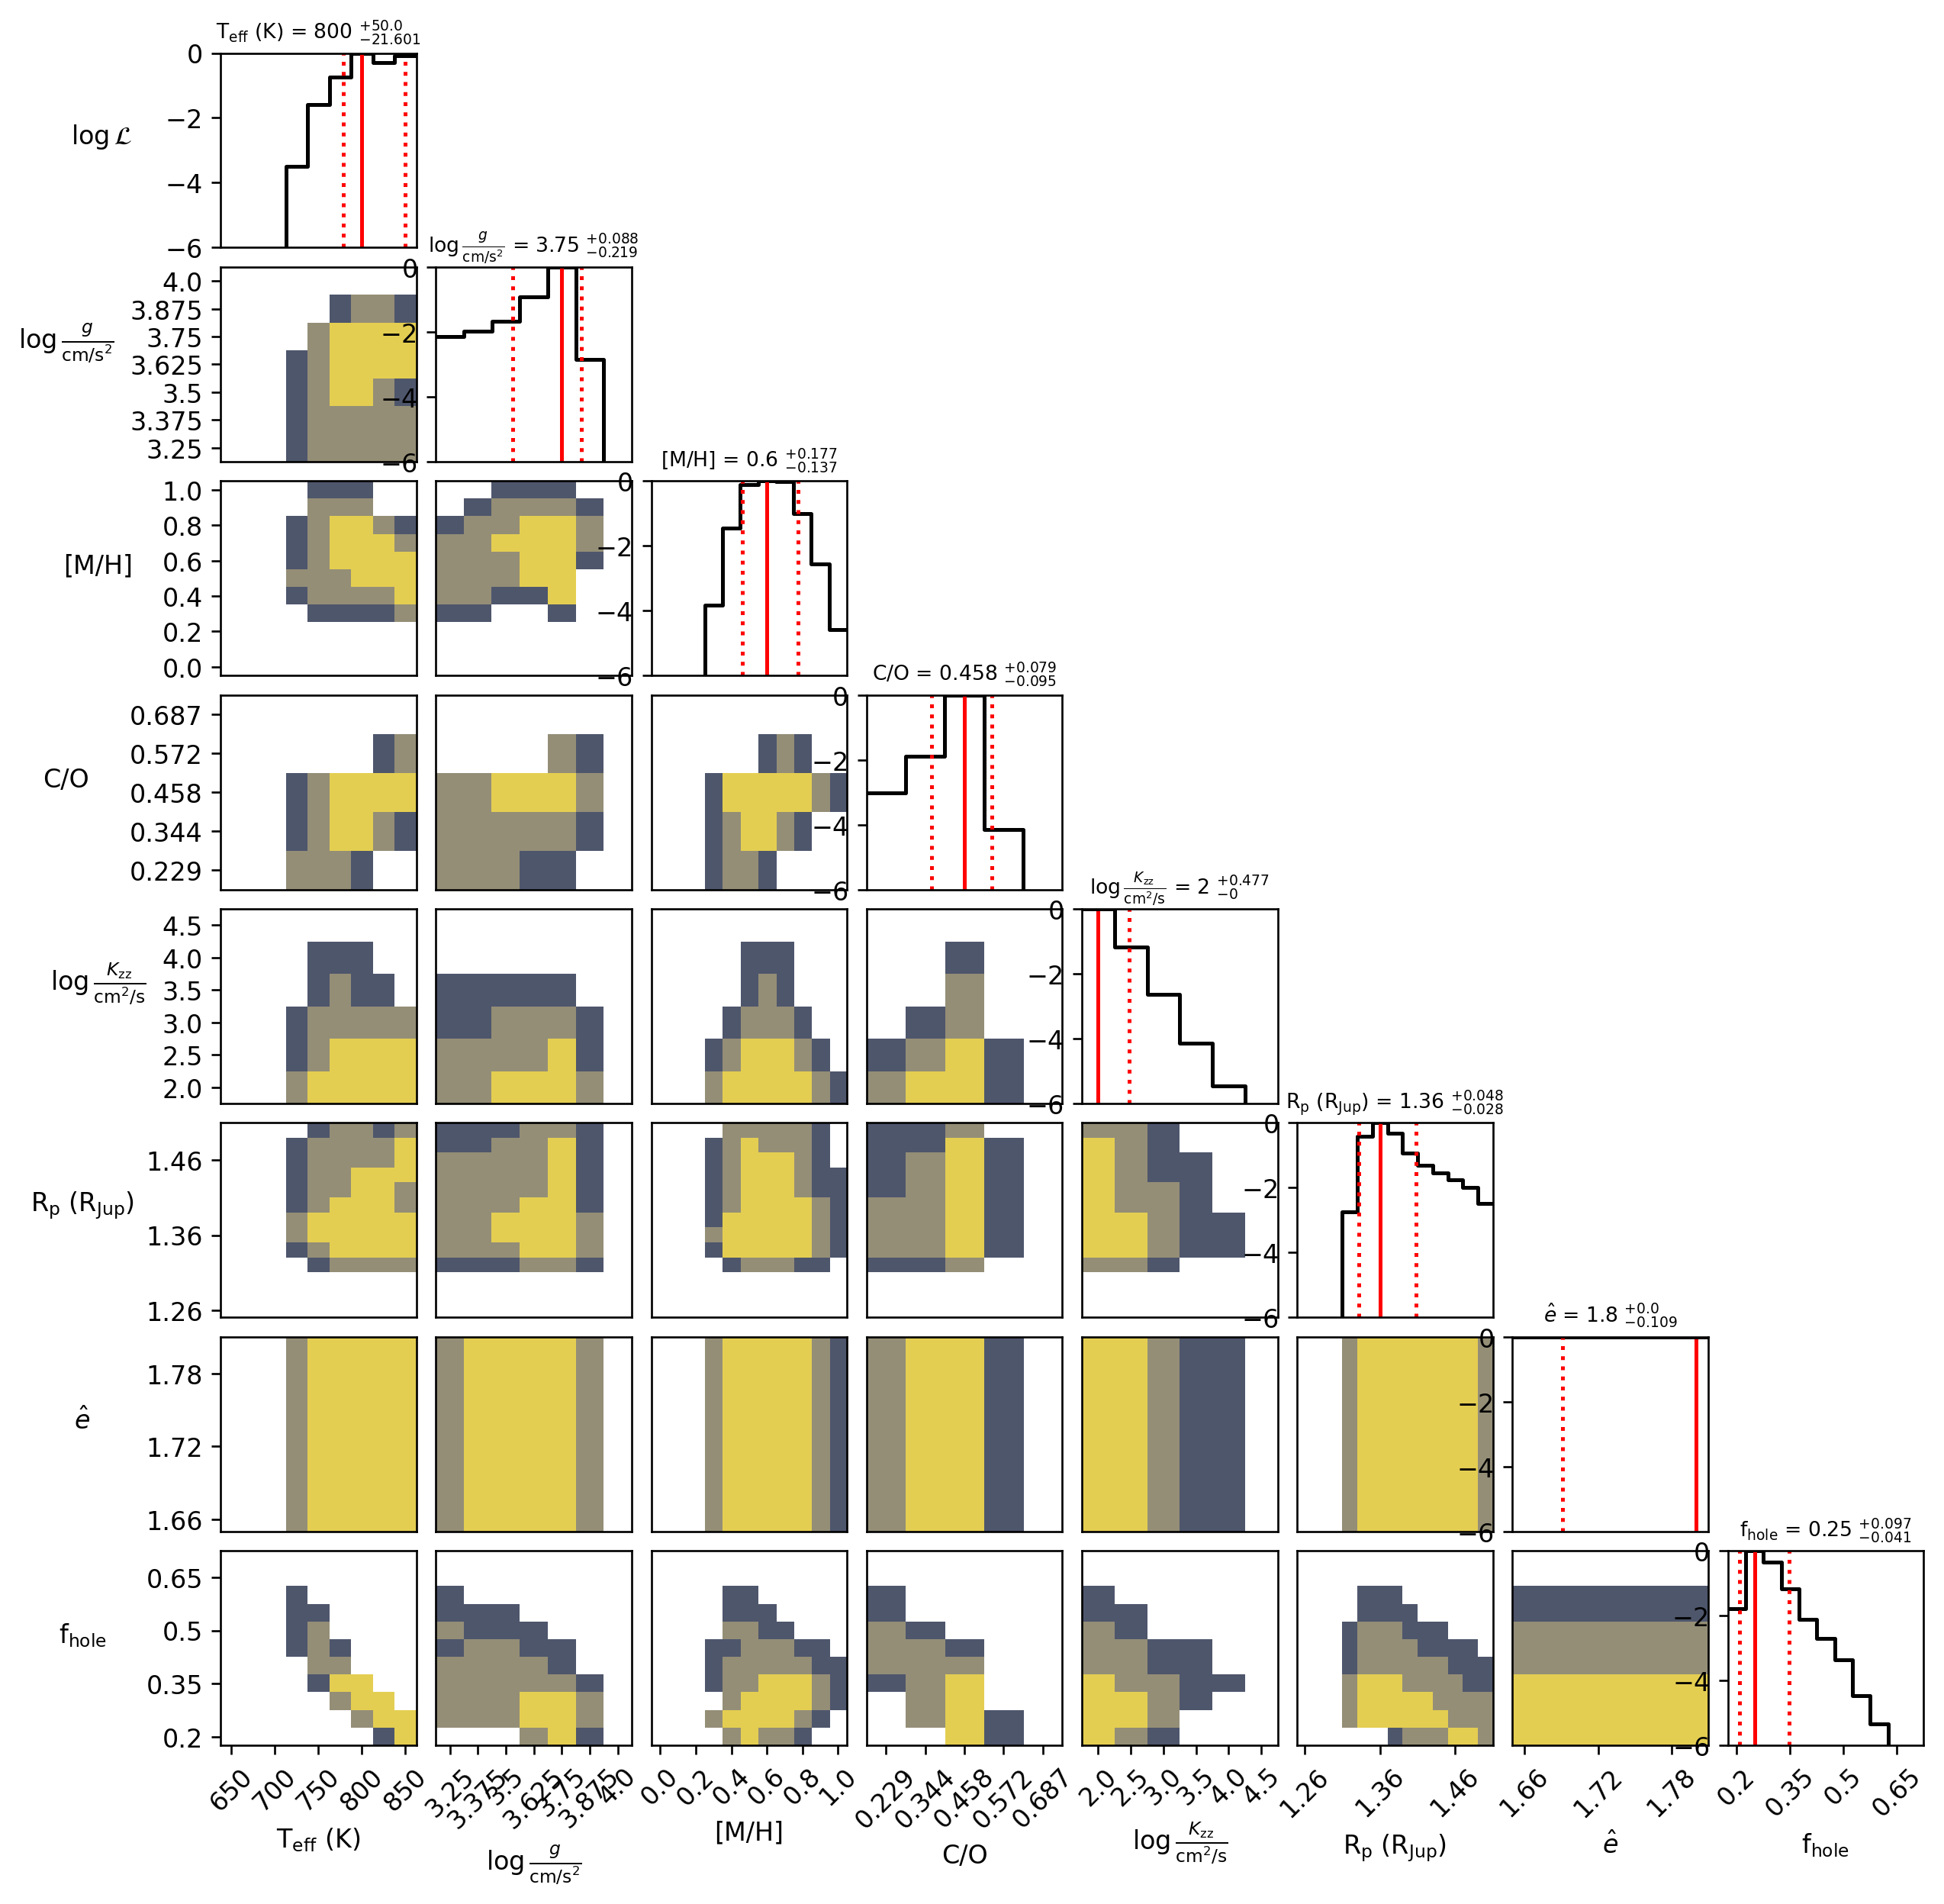

/tmp/ipykernel_3564295/874804166.py:4: RuntimeWarning: divide by zero encountered in log10
  phot_ims2, phot_diag2 = triangle(logLike_phot_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


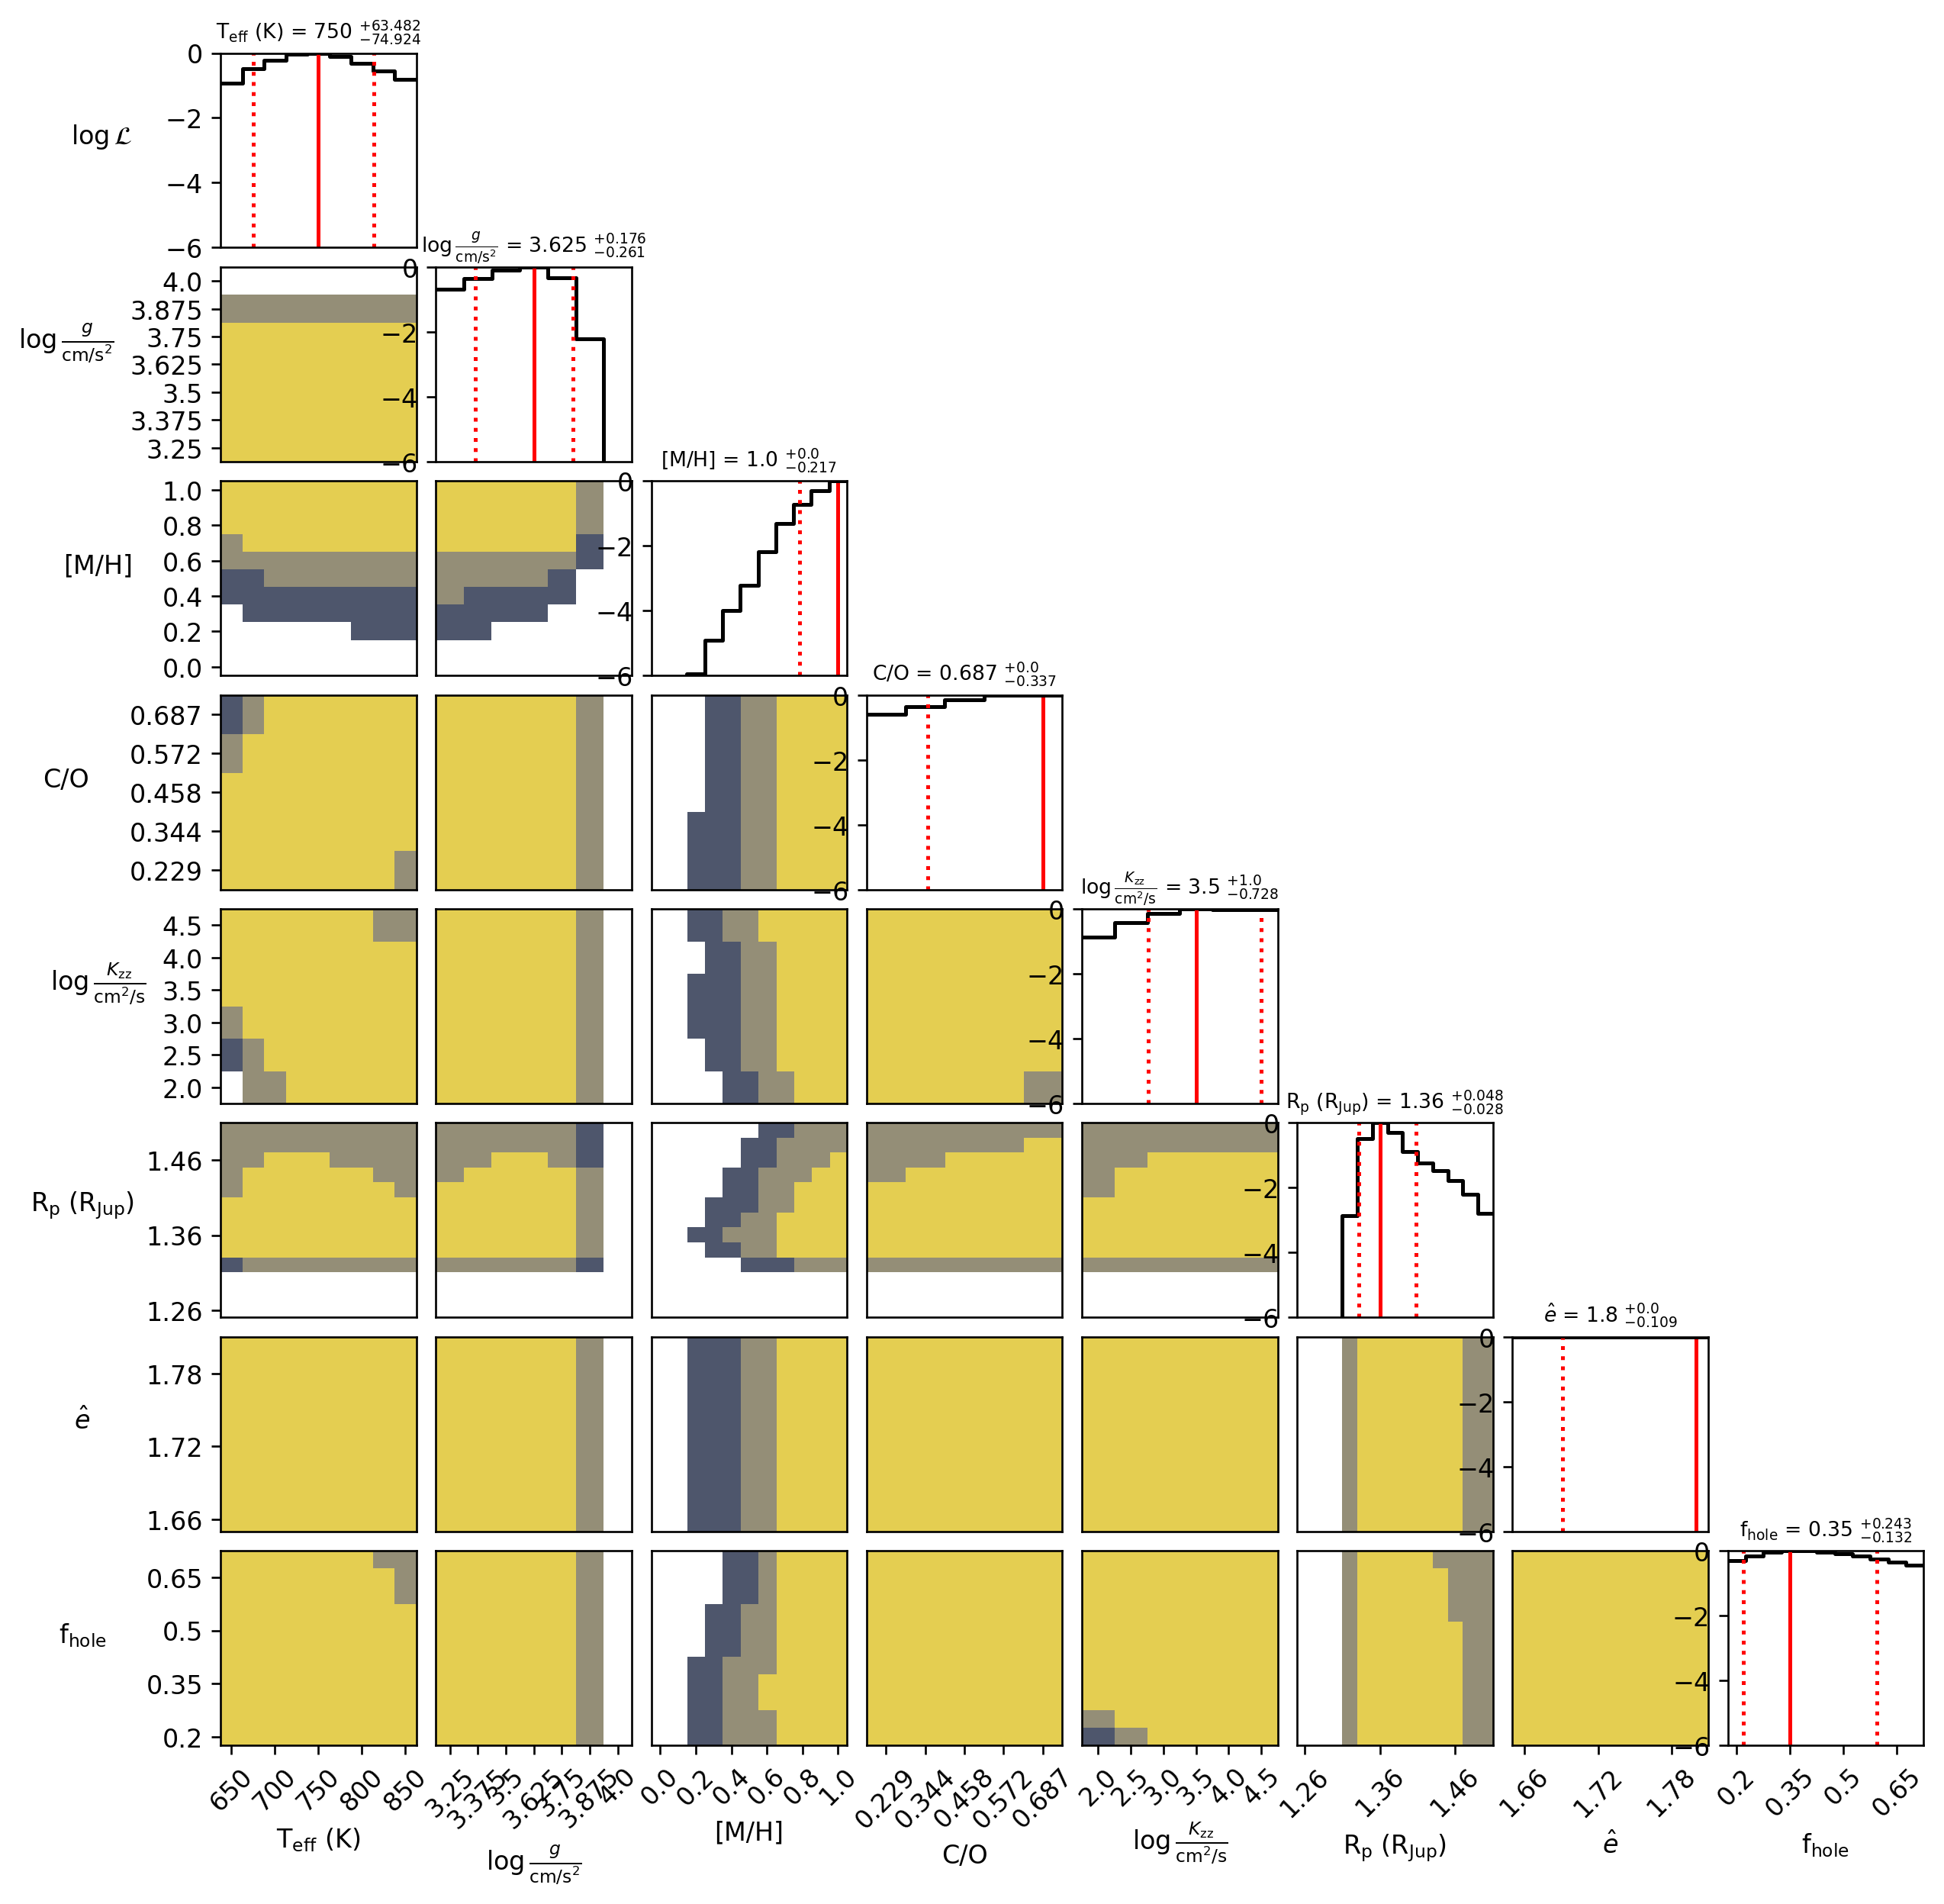

/tmp/ipykernel_3564295/874804166.py:5: RuntimeWarning: divide by zero encountered in log10
  nirspec_ims2, nirspec_diag2 = triangle(logLike_nirspec_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


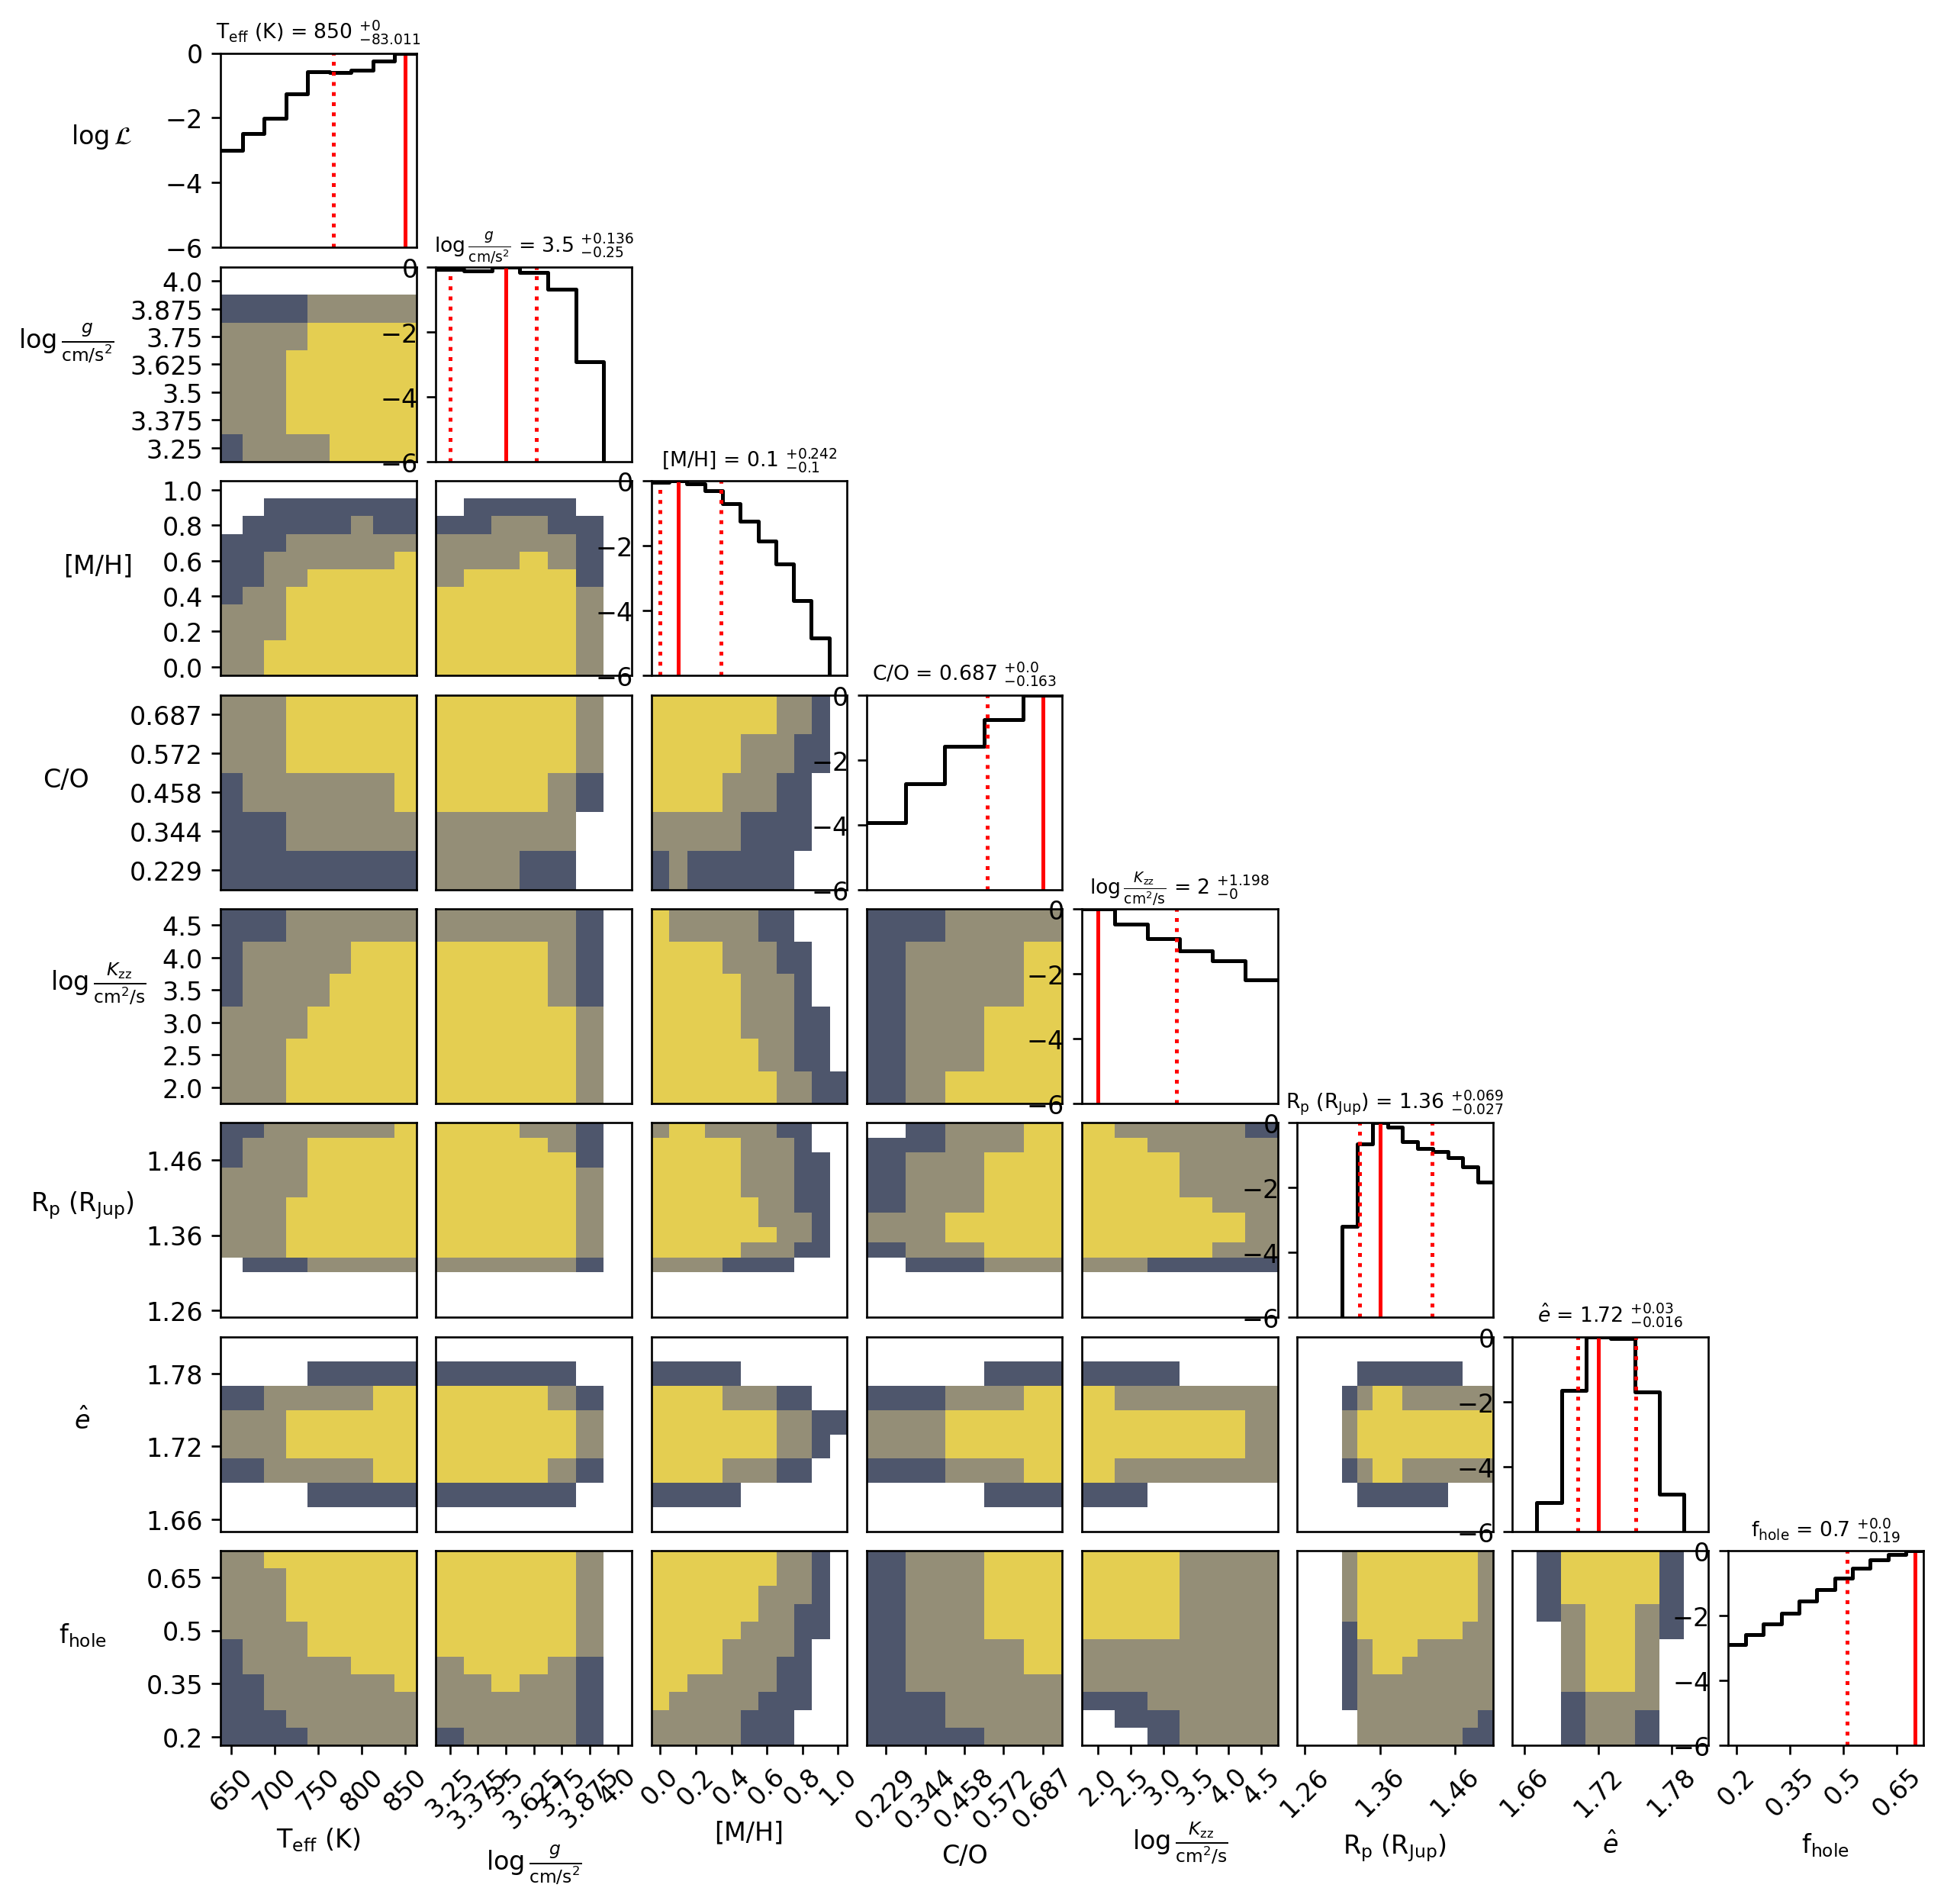

/tmp/ipykernel_3564295/874804166.py:7: RuntimeWarning: divide by zero encountered in log10
  GPIphot_ims2, GPIphot_diag2 = triangle(logLike_GPIphot_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


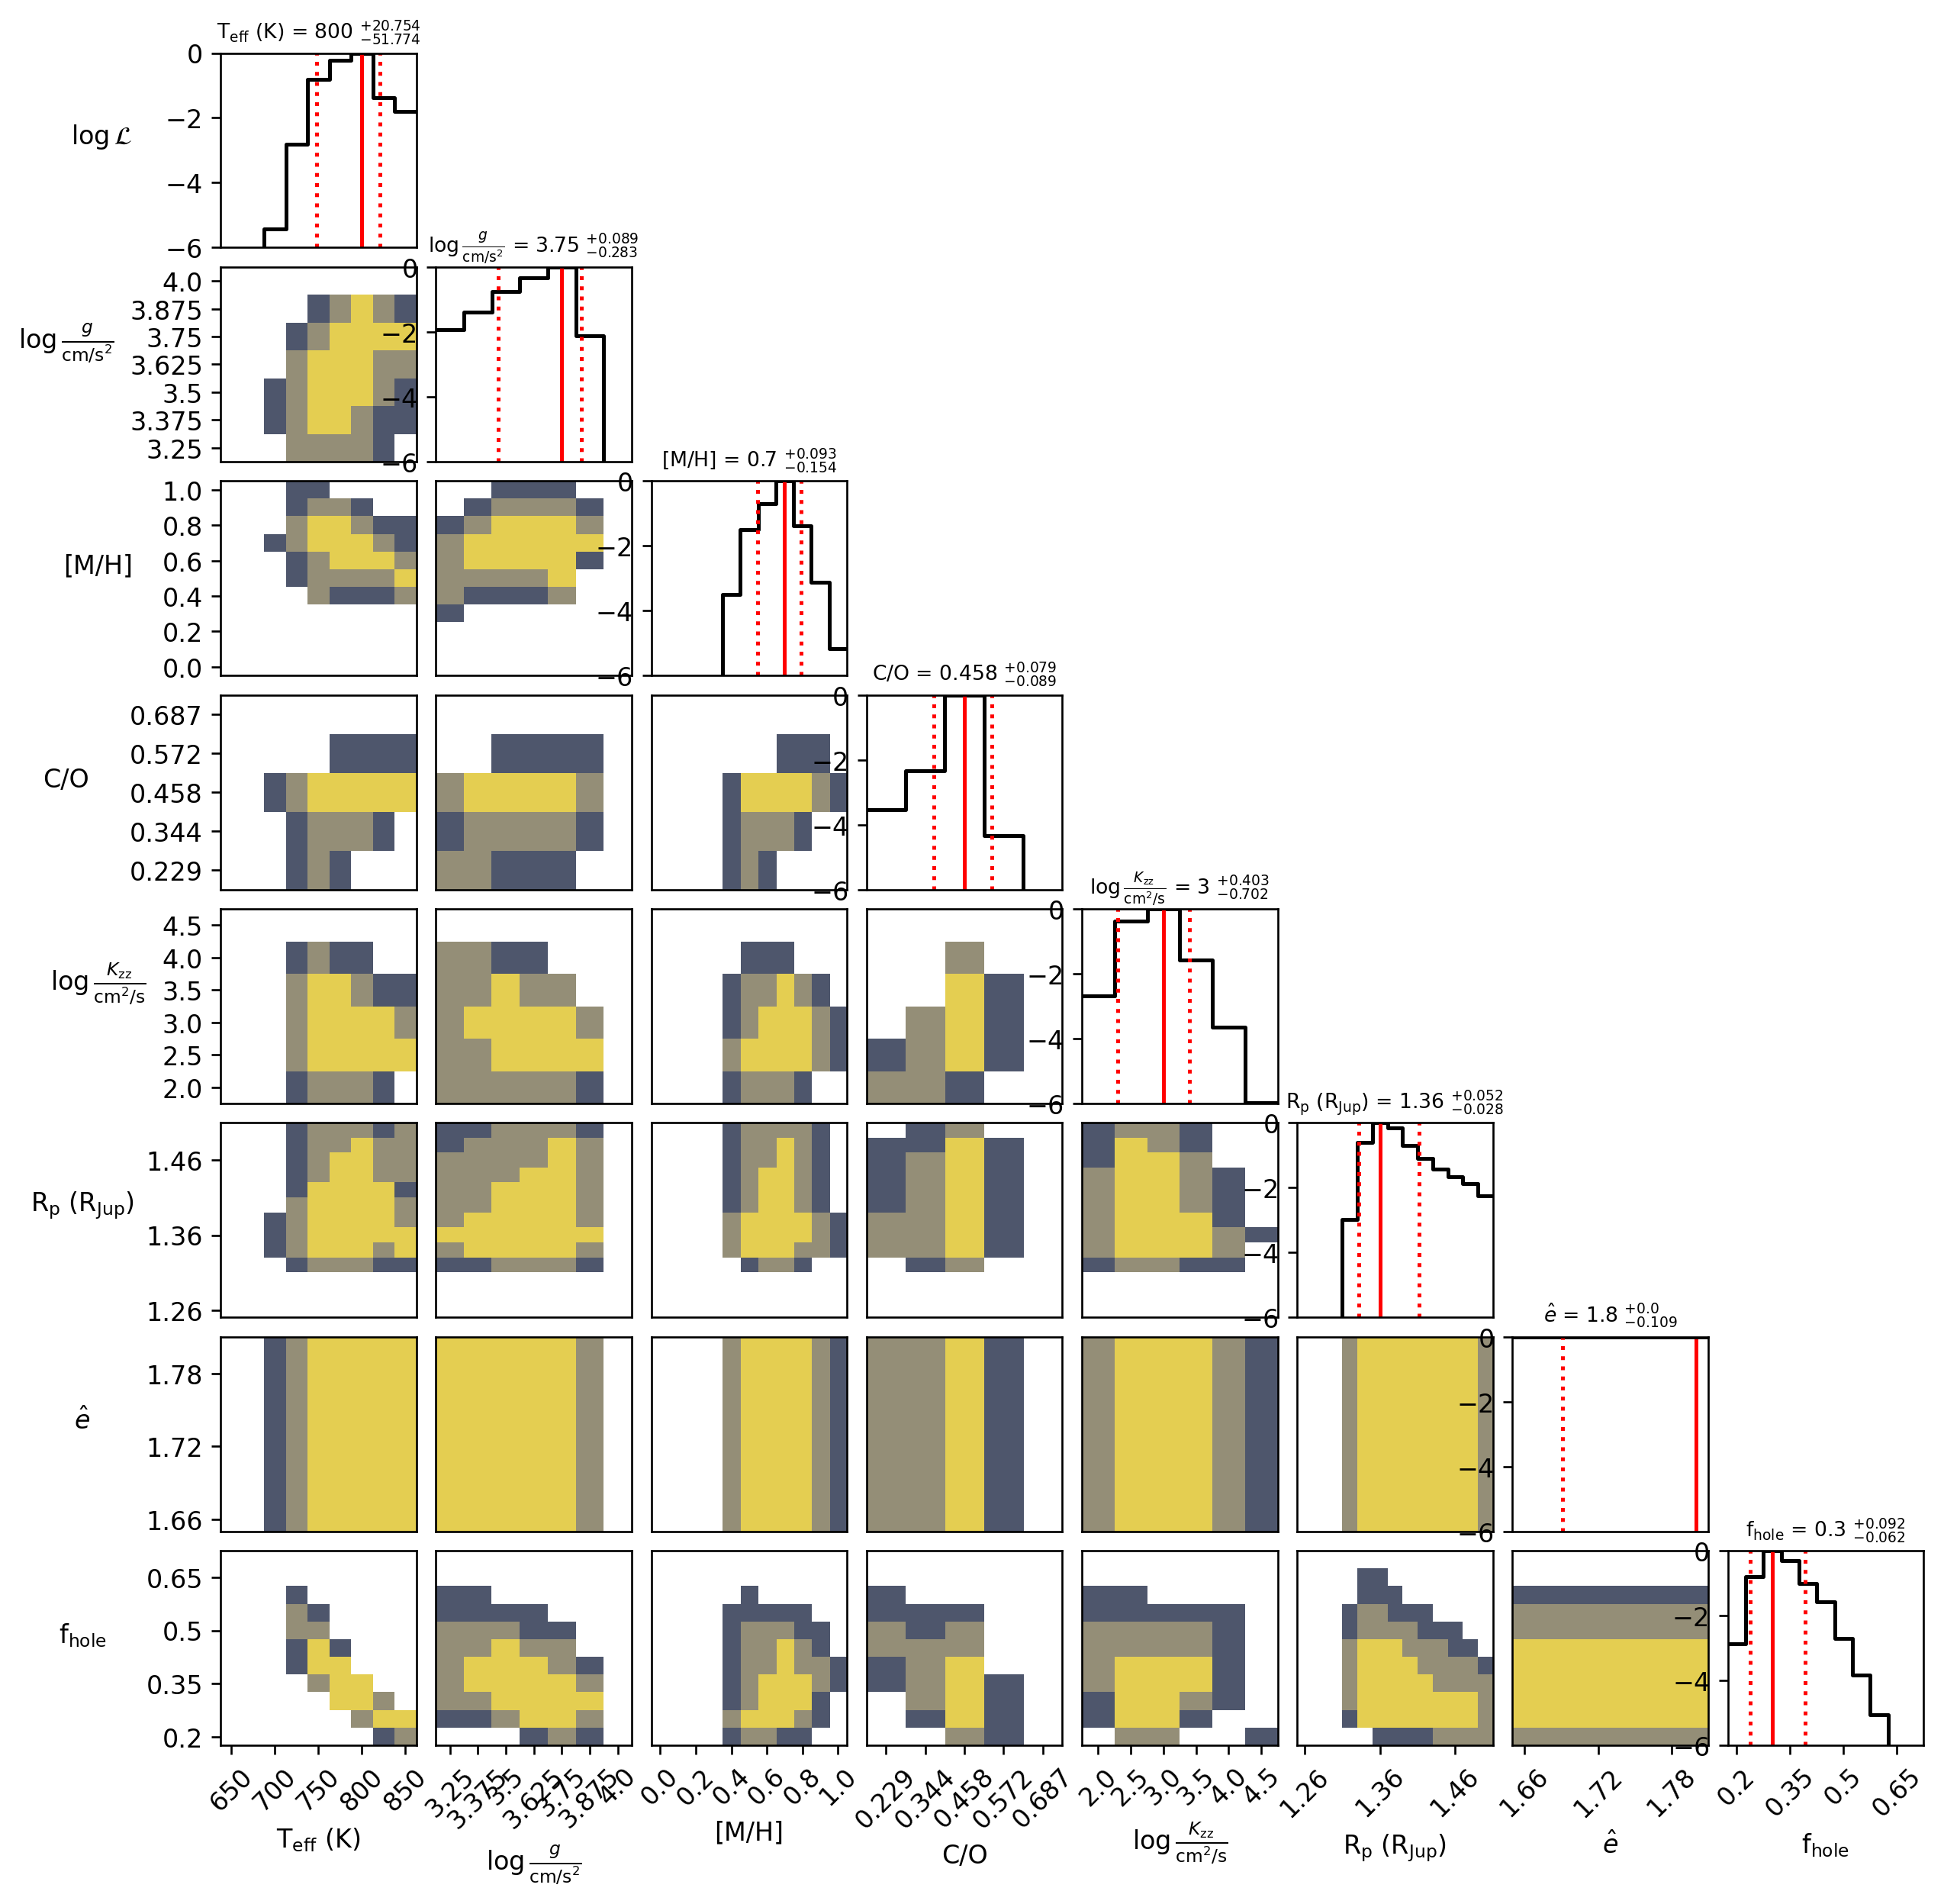

/tmp/ipykernel_3564295/874804166.py:8: RuntimeWarning: divide by zero encountered in log10
  GPInirspec_ims2, GPInirspec_diag2 = triangle(logLike_GPInirspec_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


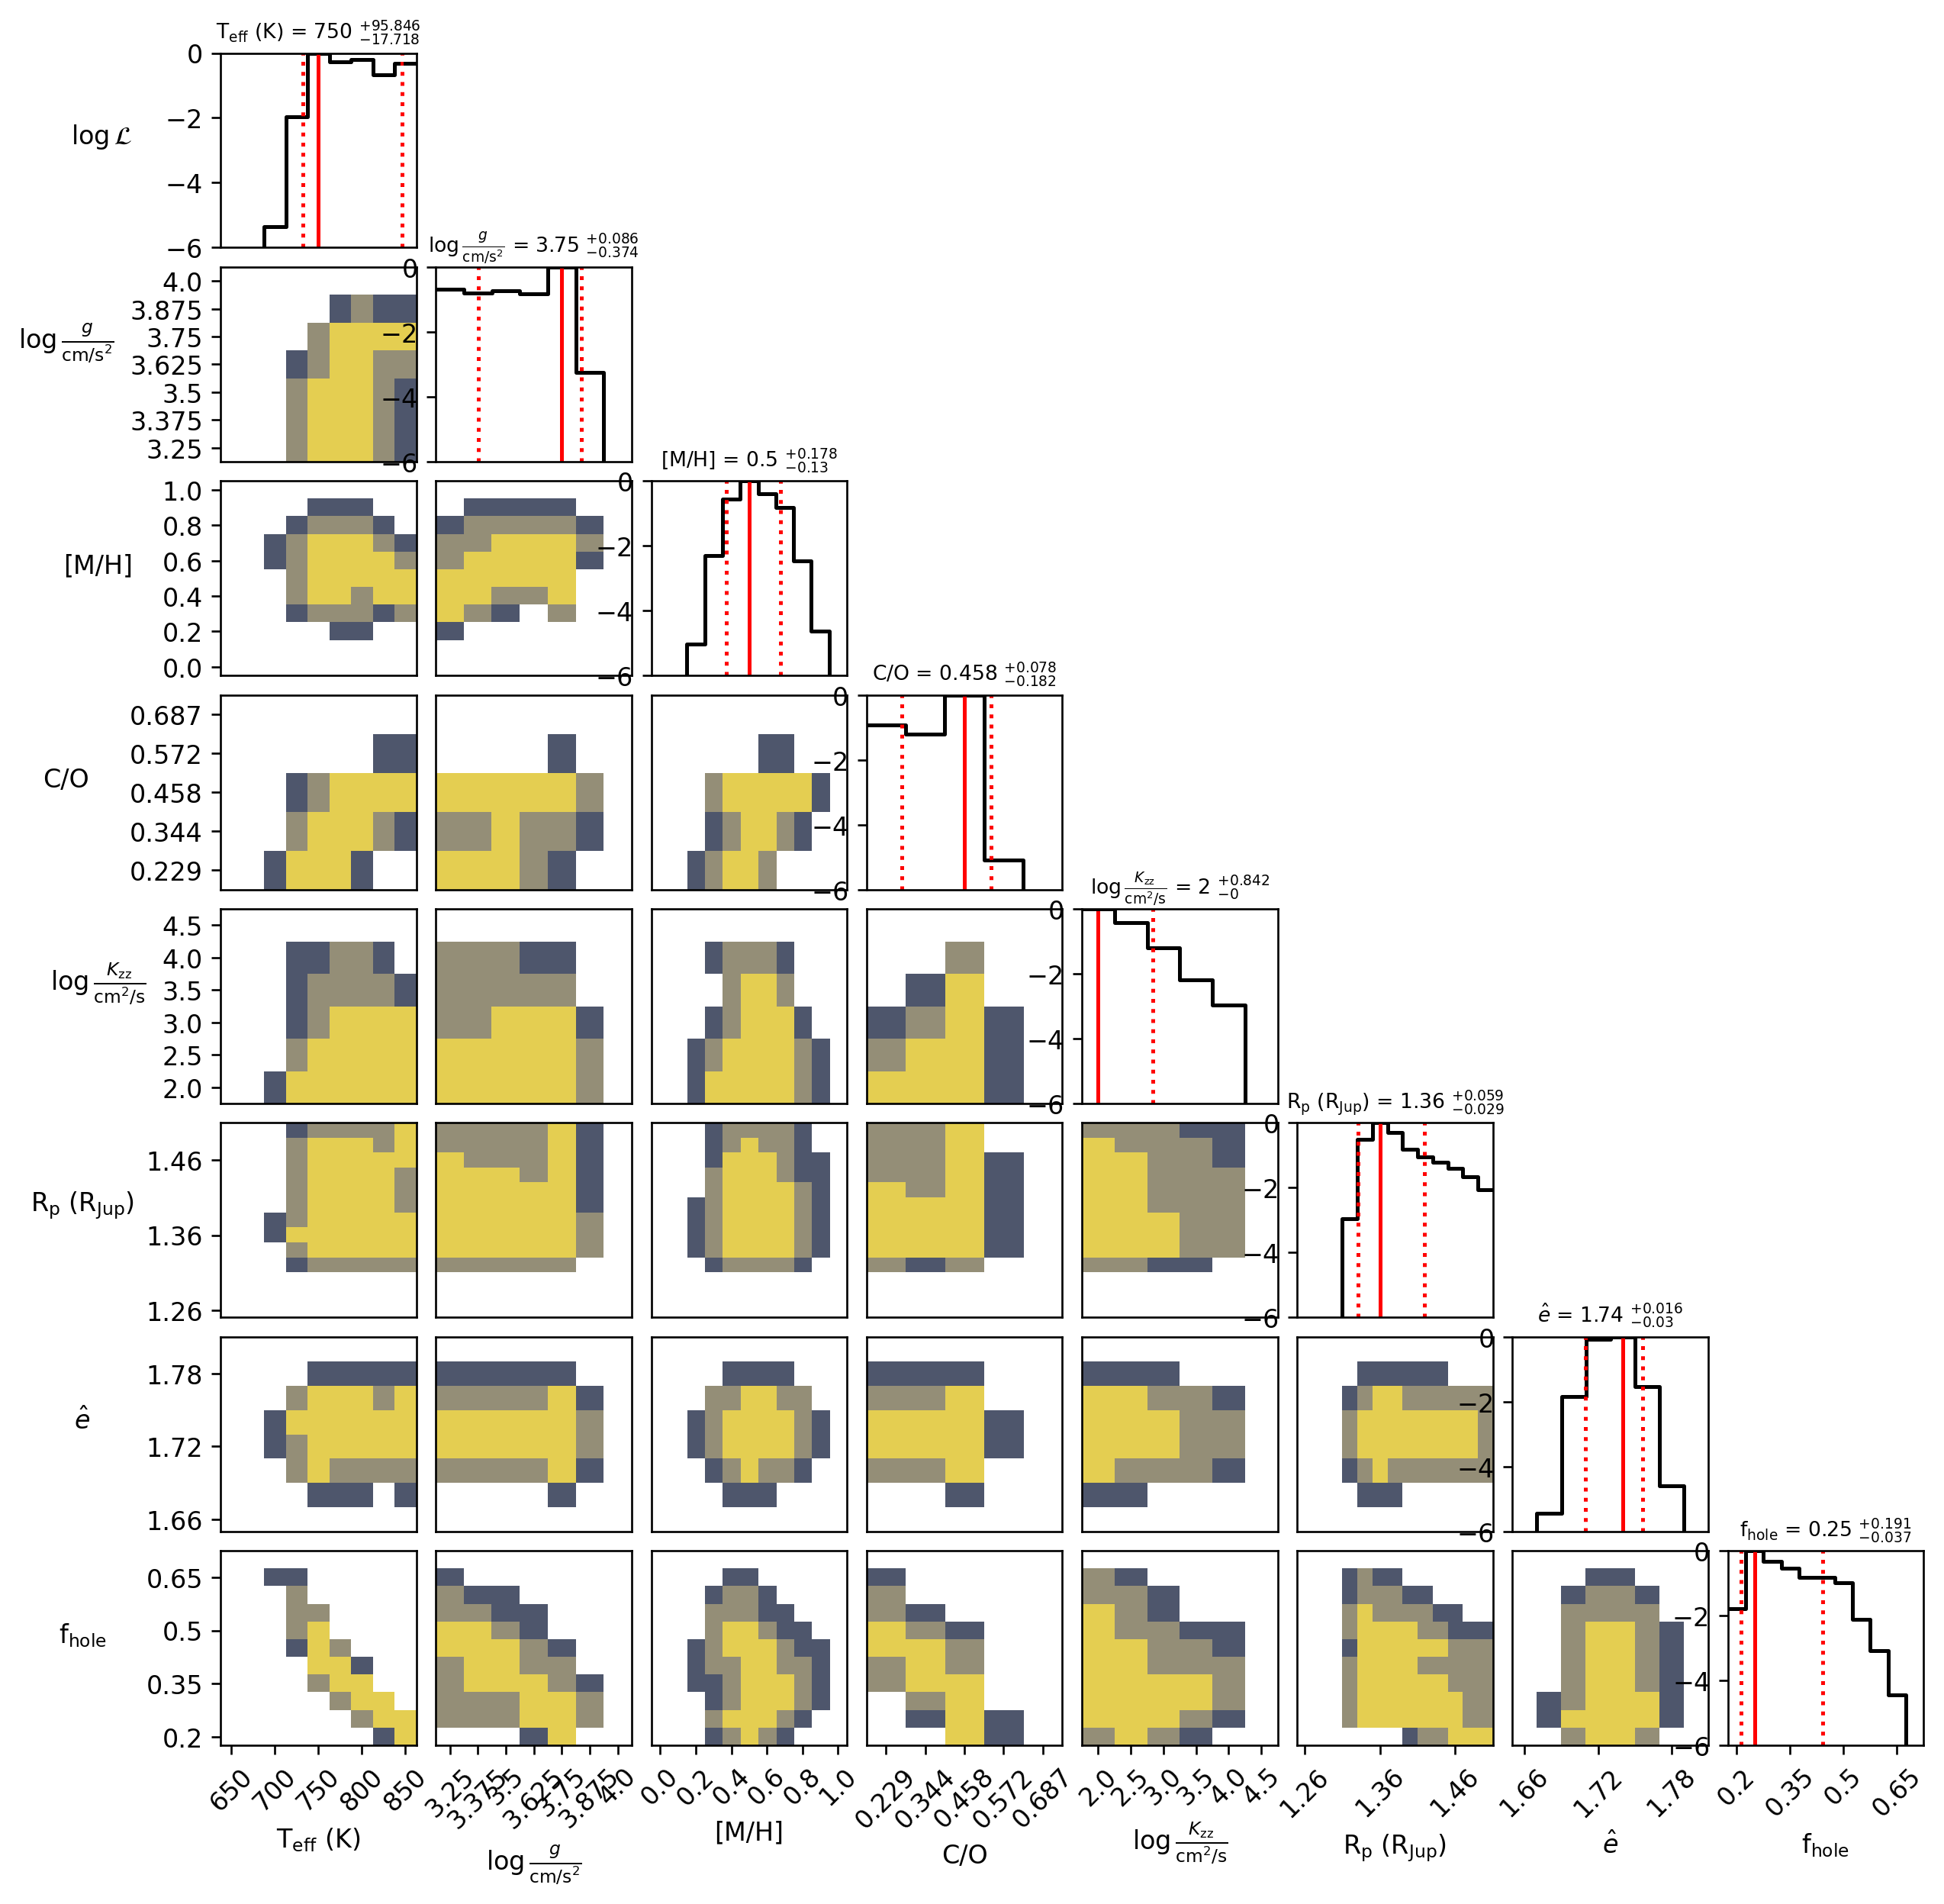

/tmp/ipykernel_3564295/874804166.py:9: RuntimeWarning: divide by zero encountered in log10
  photnirspec_ims2, photnirspec_diag2 = triangle(logLike_photnirspec_hc2+np.log10(prior_hypercube2))
/tmp/ipykernel_3564295/1997366694.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(meanLike)


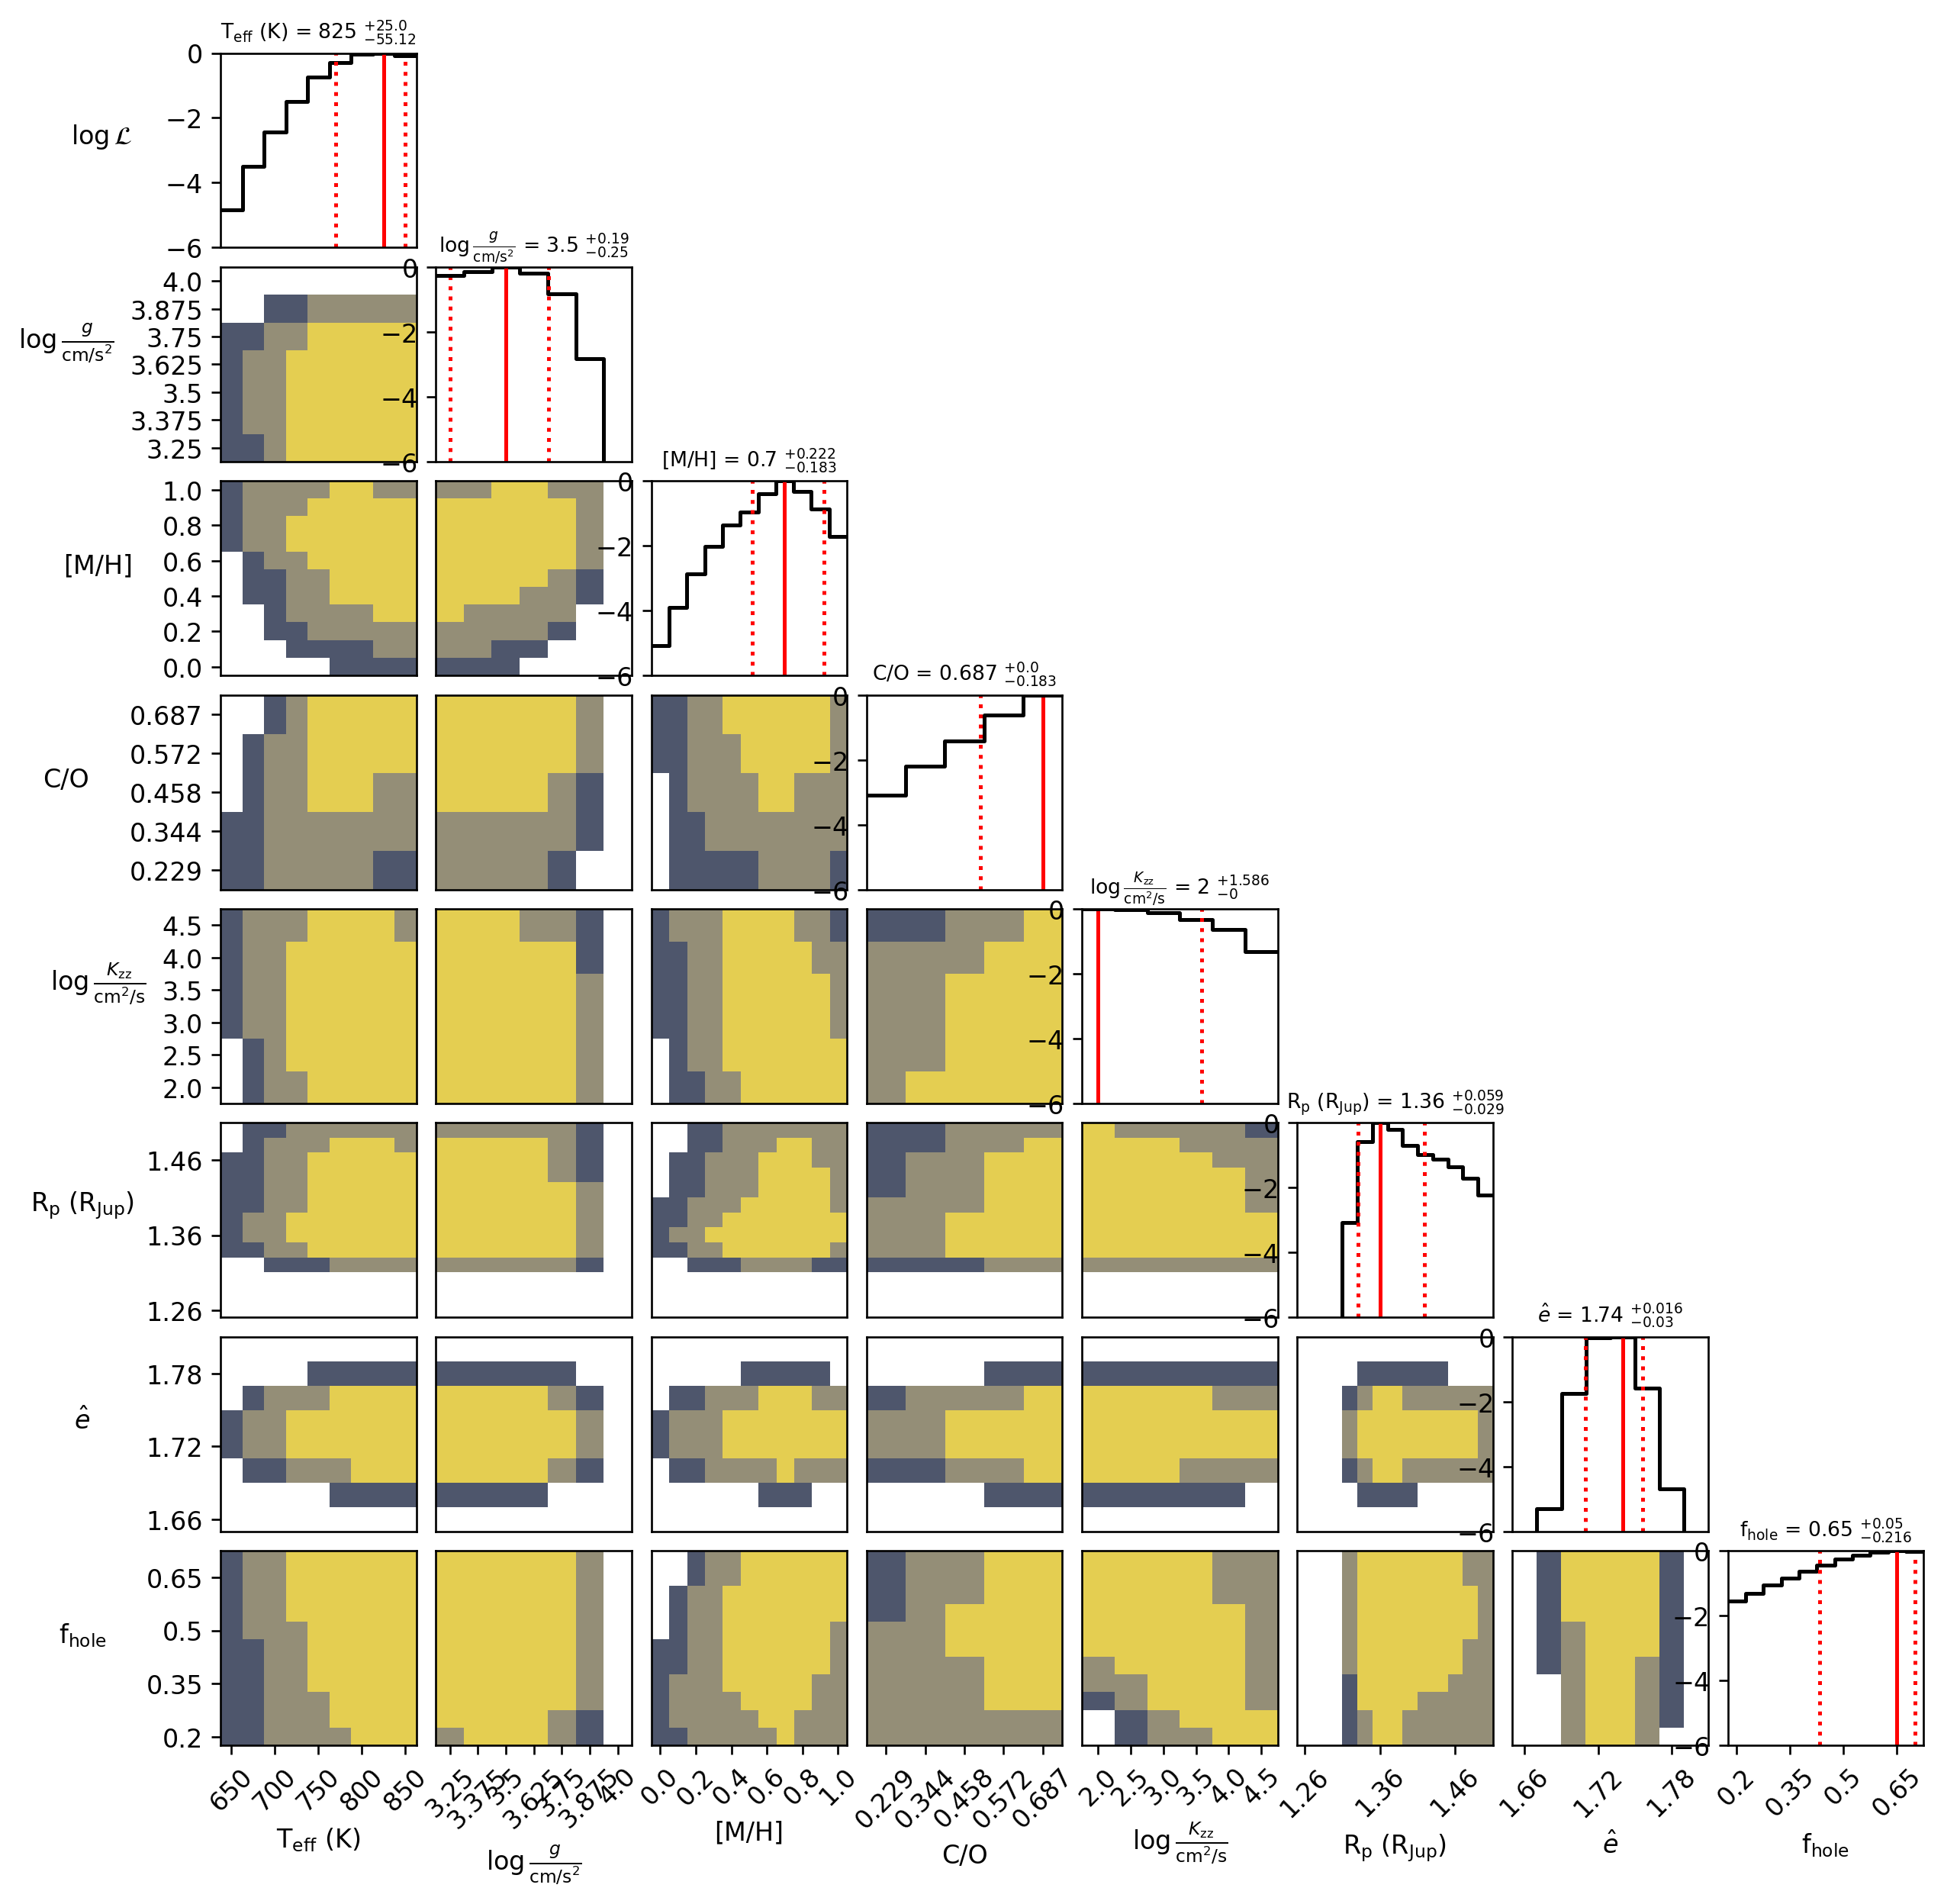

In [385]:
full_ims2, full_diag2 = triangle(logLike_hypercube2+np.log10(prior_hypercube2))

GPI_ims2, GPI_diag2 = triangle(logLike_GPI_hc2+np.log10(prior_hypercube2))
phot_ims2, phot_diag2 = triangle(logLike_phot_hc2+np.log10(prior_hypercube2))
nirspec_ims2, nirspec_diag2 = triangle(logLike_nirspec_hc2+np.log10(prior_hypercube2))

GPIphot_ims2, GPIphot_diag2 = triangle(logLike_GPIphot_hc2+np.log10(prior_hypercube2))
GPInirspec_ims2, GPInirspec_diag2 = triangle(logLike_GPInirspec_hc2+np.log10(prior_hypercube2))
photnirspec_ims2, photnirspec_diag2 = triangle(logLike_photnirspec_hc2+np.log10(prior_hypercube2))

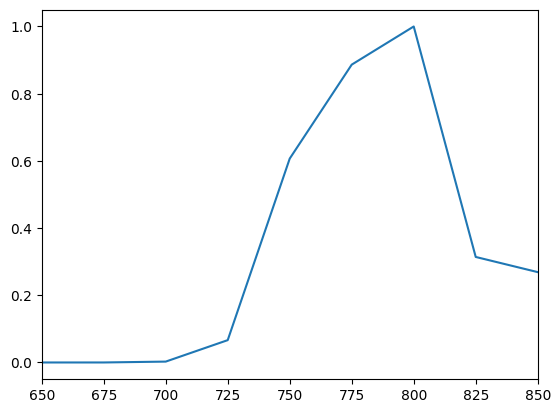

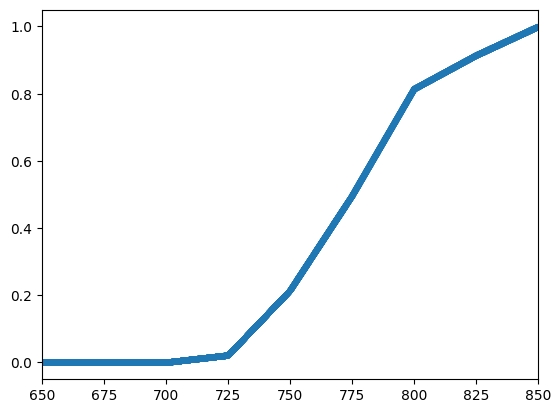

[650, 675, 700, 725, 750, 775, 800, 825, 850]


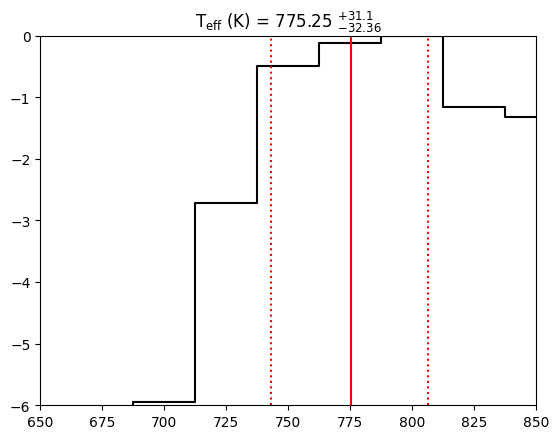

In [192]:
'''i = 0
step = full_diag2[i]
p = np.exp(step)
plt.plot(full_param_list[i],p)
plt.xlim([full_param_list[i][0],full_param_list[i][-1]])
plt.show()

cumulativePDF = np.cumsum(p)/np.sum(p)
interp_CPDF = lambda x: np.interp(x,full_param_list[i],cumulativePDF)
xi = np.linspace(full_param_list[i][0],full_param_list[i][-1],10000)

percentiles = [16, 50, 84]
xs = []
for perc in percentiles:
    f = lambda x: (interp_CPDF(x) - perc/100.)**2
    fx = f(xi)
    xopt = xi[np.argmin(fx)]
    xs.append(xopt)
    
plt.plot(xi,interp_CPDF(xi),'.')
plt.xlim([full_param_list[i][0],full_param_list[i][-1]])
plt.show()

print(full_param_list[i])

plt.step(full_param_list[i],step,'k',where='mid')
for _,x in enumerate(xs):
    if _ == 1:
        linestyle = '-'
    else:
        linestyle = ':'
    plt.axvline(x=x,color='r',linestyle=linestyle)
plt.ylim([-6,0])
plt.xlim([full_param_list[i][0],full_param_list[i][-1]])


plt.title(str(names[i])+' = '+str(np.round(xs[1],2))+r' $^{+'+str(np.round(xs[2]-xs[1],2))+r'}_{-'+str(np.round(xs[1]-xs[0],2))+r'}$')
plt.show()'''

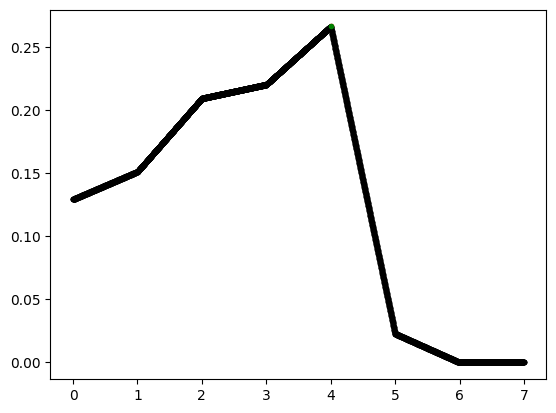

In [276]:
'''i = 1
step = full_diag2[i]
p = np.exp(step)
p /= np.sum(p)
imax = np.argmax(p)

interp_PDF = lambda x: np.interp(x,range(len(p)),p)
xi = np.linspace(0,len(p),5000)

plt.plot(p)
plt.plot(imax,p[imax],'r.')
plt.plot(xi,interp_PDF(xi),'k.')
plt.plot(imax, interp_PDF(imax),'g.')
plt.show()'''

In [283]:
'''dxi = 1
condition = True
mini = np.argmin(abs(xi - imax))
while condition:
    integral = np.sum(interp_PDF(xi[mini-dxi:mini])*np.mean(np.diff(xi)))
    condition = not(integral > .34)
    dxi += 1
    if mini-dxi <= 1:
        condition = False
        print('left edge condition on i = {}, integral = {}'.format(i, integral))

ind_value = xi[mini-dxi]
left_val = np.interp(ind_value, range(len(p)), full_param_list[i])

dxi = 1
condition = True
mini = np.argmin(abs(xi - imax))
while condition:
    integral = np.sum(interp_PDF(xi[mini:mini+dxi])*np.mean(np.diff(xi)))
    condition = not(integral > .34)
    dxi += 1
    if mini+dxi >= len(xi)-1:
        condition = False
        print('right edge condition on i = {}, integral = {}'.format(i, integral))

ind_value = xi[mini+dxi]
right_val = np.interp(ind_value, range(len(p)), full_param_list[i])

mid_val = np.interp(xi[mini], range(len(p)), full_param_list[i])

left_val,mid_val,right_val'''

right edge condition on i = 1, integral = 0.156112309582787


(3.5694388877775554, 3.7500750150030004, 4.0)

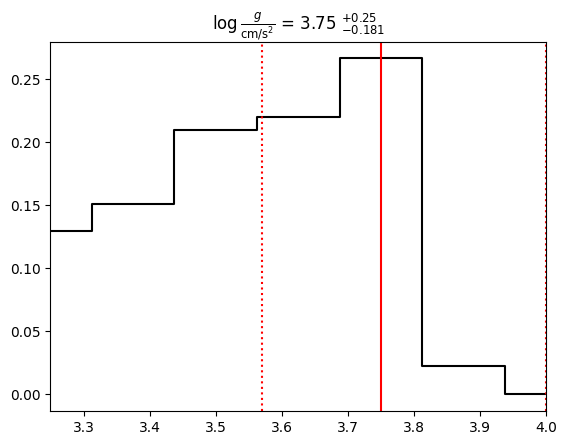

In [284]:
'''plt.step(full_param_list[i],p,'k',where='mid')

plt.axvline(x=left_val,color='r',linestyle=':')
plt.axvline(x=mid_val,color='r',linestyle='-')
plt.axvline(x=right_val,color='r',linestyle=':')
#plt.ylim([-6,0])
plt.xlim([full_param_list[i][0],full_param_list[i][-1]])


plt.title(str(names[i])+' = '+str(np.round(mid_val,3))+r' $^{+'+str(np.round(right_val-mid_val,3))+r'}_{-'+str(np.round(mid_val-left_val,3))+r'}$')
plt.show()'''

In [285]:
from breads.utils import get_err_from_posterior

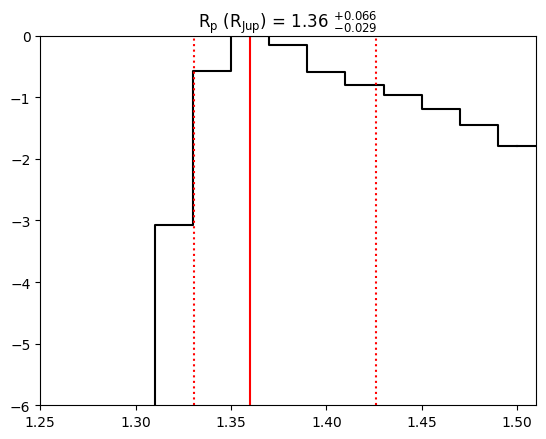

In [319]:
i = 5
step = full_diag2[i]
p = np.exp(step)
p /= np.sum(p)

mid_val, left_err, right_err = get_err_from_posterior(full_param_list[i],p)

plt.step(full_param_list[i],step,'k',where='mid')

plt.axvline(x=mid_val-left_err,color='r',linestyle=':')
plt.axvline(x=mid_val,color='r',linestyle='-')
plt.axvline(x=mid_val+right_err,color='r',linestyle=':')
plt.ylim([-6,0])
half_pixel_size = (full_param_list[i][1] - full_param_list[i][0])/2.
plt.xlim([full_param_list[i][0]-half_pixel_size,full_param_list[i][-1]+half_pixel_size])

#extend edges
xmax = (full_param_list[i][0]- (full_param_list[i][0]-half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size))
plt.axhline(y=step[0], xmax=xmax, color='k' )

xmin = 1+ ((full_param_list[i][-1]- (full_param_list[i][-1]+half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size)))
plt.axhline(y=step[-1], xmin=xmin, color='k' )


plt.title(str(names[i])+' = '+str(np.round(mid_val,3))+r' $^{+'+str(np.round(right_err,3))+r'}_{-'+str(np.round(left_err,3))+r'}$')
plt.show()

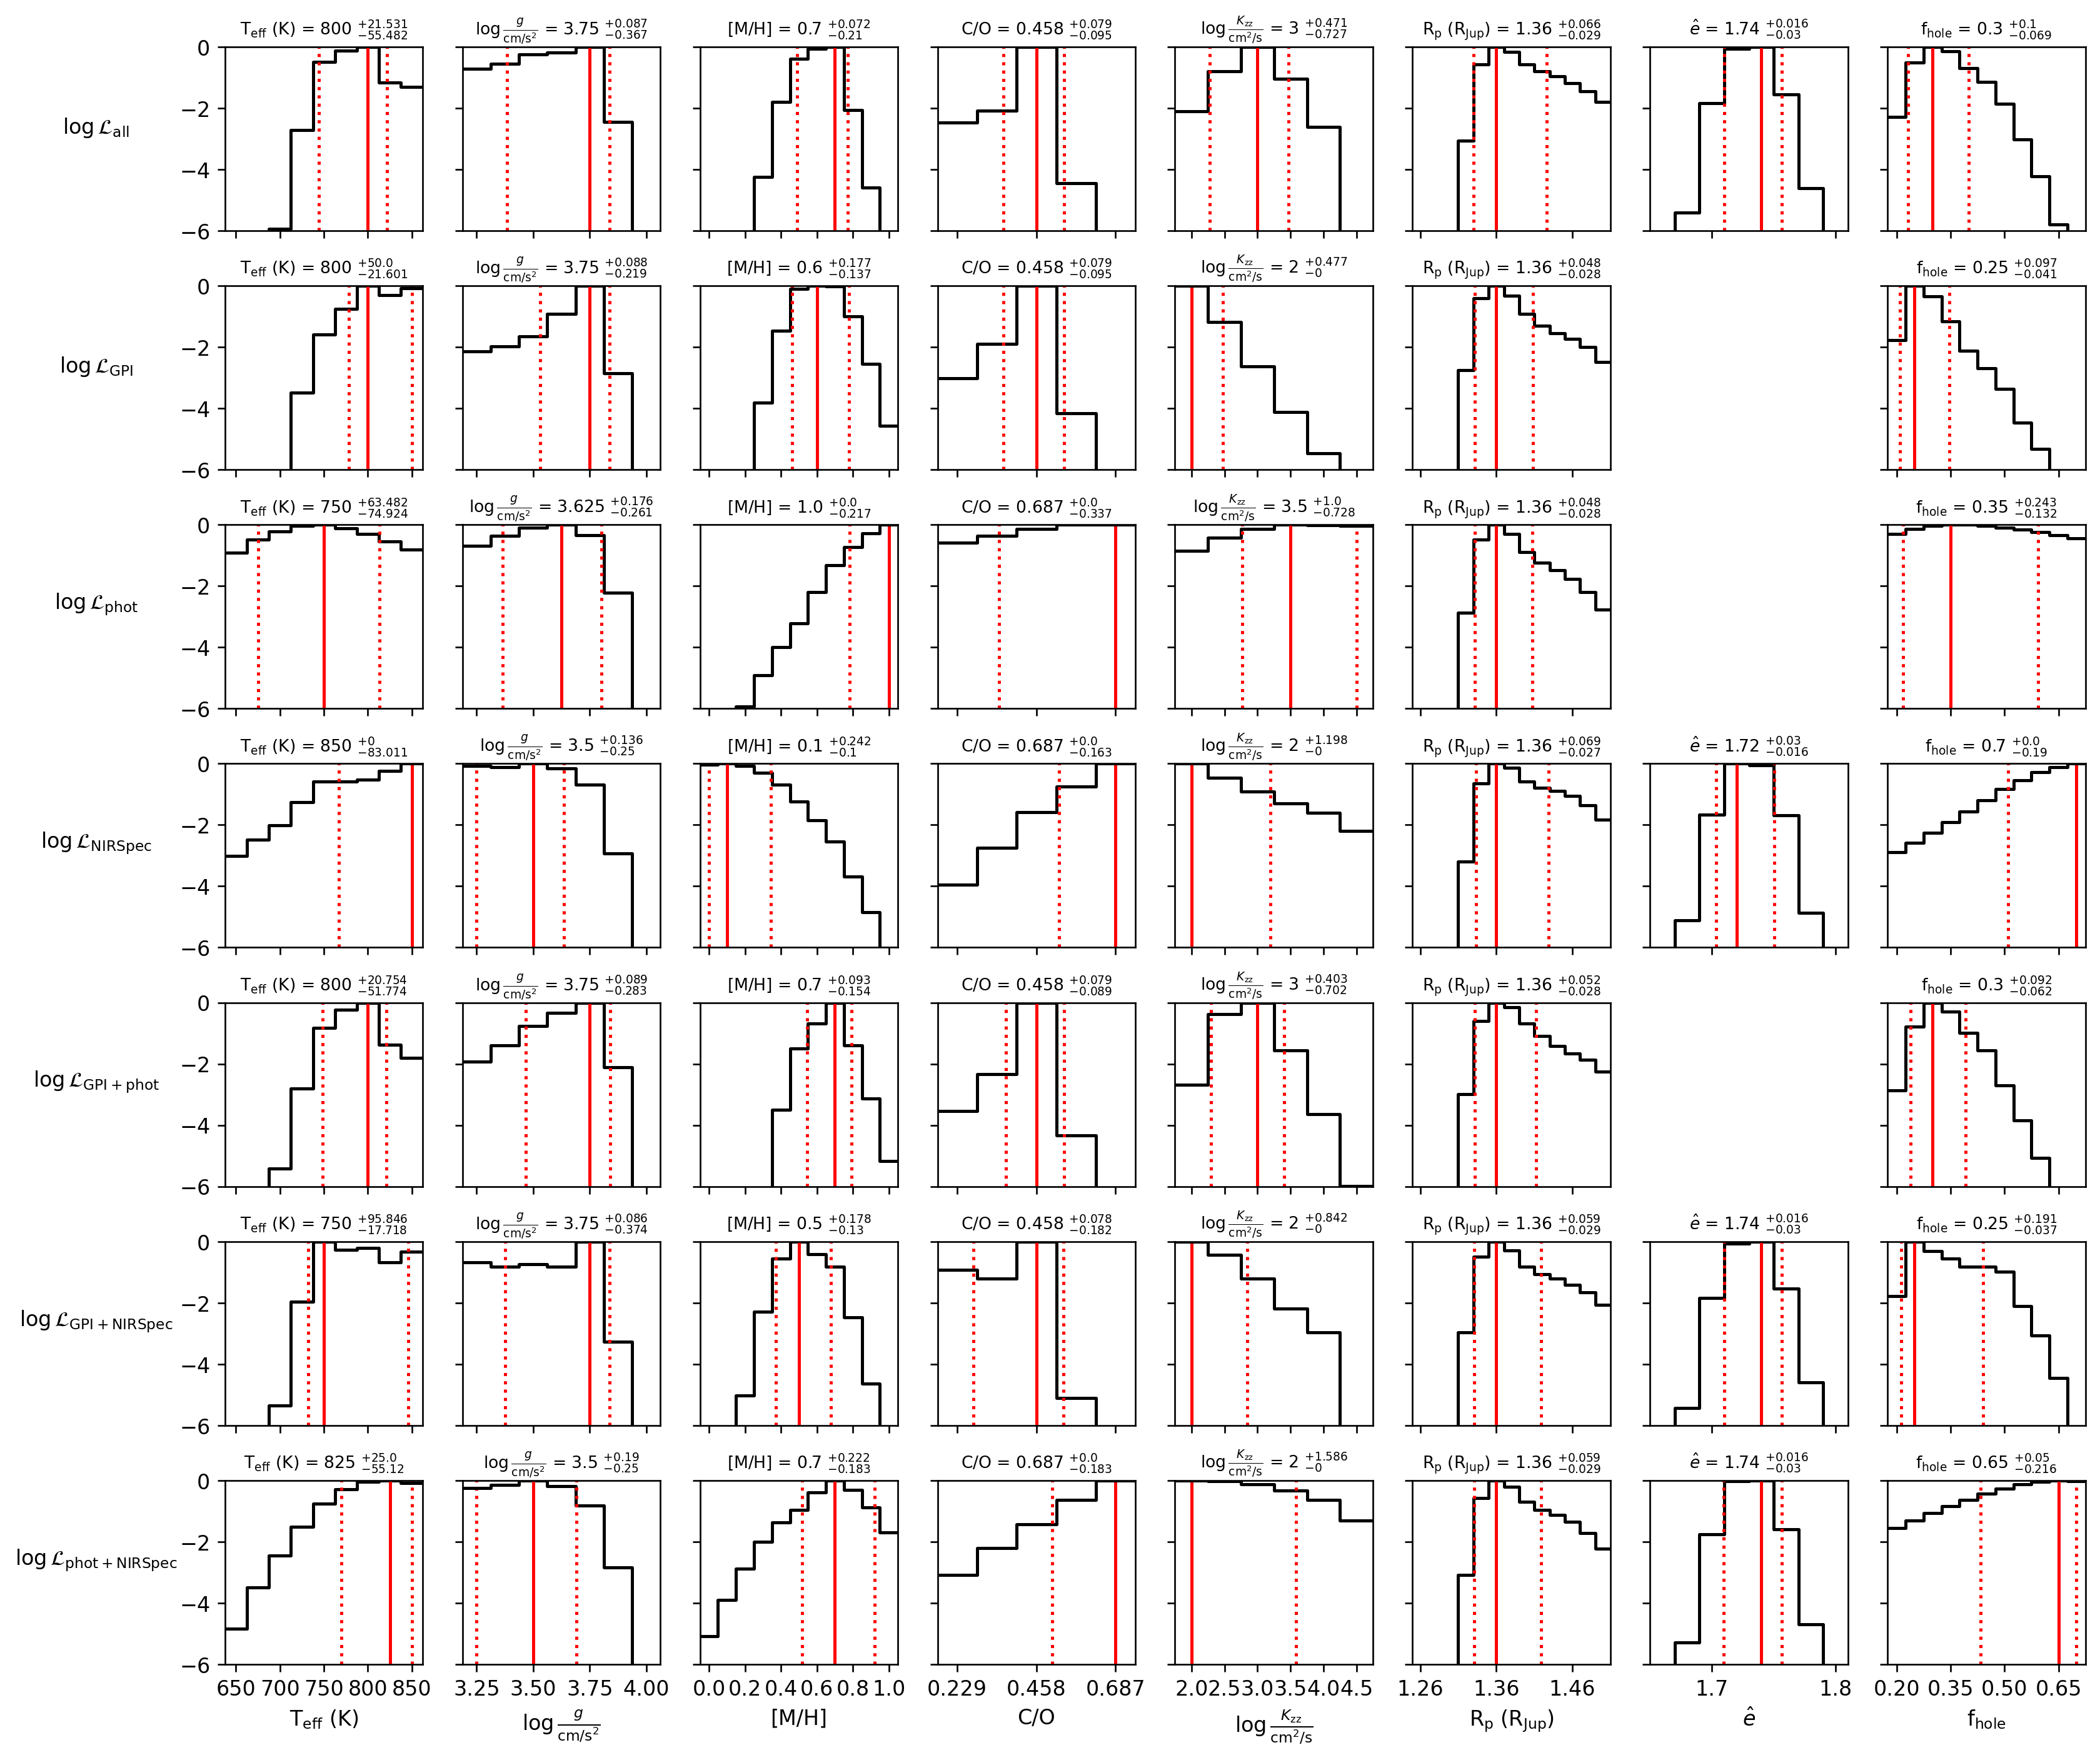

In [409]:
diag_list = [full_diag2, GPI_diag2, phot_diag2, nirspec_diag2, GPIphot_diag2, GPInirspec_diag2, photnirspec_diag2]
dataset_names = ['all', 'GPI', 'phot', 'NIRSpec', 'GPI+phot', 'GPI+NIRSpec', 'phot+NIRSpec']

fig,ax = plt.subplots(len(diag_list), len(full_param_list),figsize=(len(full_param_list)*2,len(diag_list)*2),dpi=240,sharey=True,sharex='col')

for j,diag in enumerate(diag_list):
    for i,step in enumerate(diag):

        xmod = [0] + full_param_list[i] + []
        ax[j,i].step(full_param_list[i],step,'k',where='mid')
        
        #diagonals.append(step)
        ax[j,i].set_yticks([-6,-4,-2,0])
        ax[j,i].set_ylim([-6,0])
        
        #1sigma percentiles and title
        p = np.exp(step)
        p /= np.sum(p)
        mid_val, left_err, right_err = get_err_from_posterior(full_param_list[i],p)
        ax[j,i].axvline(x=mid_val-left_err,color='r',linestyle=':')
        ax[j,i].axvline(x=mid_val,color='r',linestyle='-')
        ax[j,i].axvline(x=mid_val+right_err,color='r',linestyle=':')
        
        ax[j,i].set_title(str(names[i])+' = '+str(np.round(mid_val,3))+r' $^{+'+str(np.round(right_err,3))+r'}_{-'+str(np.round(left_err,3))+r'}$',fontsize=8)
        
        #match xlims
        half_pixel_size = (full_param_list[i][1] - full_param_list[i][0])/2.
        ax[j,i].set_xlim([full_param_list[i][0]-half_pixel_size,full_param_list[i][-1]+half_pixel_size])
        
        #extend step edges
        xmax = (full_param_list[i][0]- (full_param_list[i][0]-half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size))
        ax[j,i].axhline(y=step[0], xmax=xmax, color='k' )
        xmin = 1+ ((full_param_list[i][-1]- (full_param_list[i][-1]+half_pixel_size)) / (full_param_list[i][-1]+half_pixel_size - (full_param_list[i][0]-half_pixel_size)))
        ax[j,i].axhline(y=step[-1], xmin=xmin, color='k' )

    #names
    ax[j,0].set_ylabel(r'$\log \mathcal{L}_\mathrm{'+str(dataset_names[j])+r'}$',rotation=0, labelpad=40, fontsize=10)


rounds = [3,3,2,3,2,2,3,3]
dss = [2,2,2,2,1,5,3,3]
for i in range(0,8):
    ds = dss[i]
    ax[-1,i].set_xticks(np.round(full_param_list[i],rounds[i])[::ds])
    ax[-1,i].set_xlabel(names[i])

plt.subplots_adjust(hspace=0.3)

for j in [1,2,4]:
    ax[j, 6].cla()
    ax[j, 6].axis('off')

plt.savefig('posteriors.png')
plt.show()
